In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

df = pd.read_csv("./log_data.csv") # Data for training
df.head()

,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU,lithology,munsel_color
0,0.0724,5.8481,0.0959,1.3131,-0.1712,1950.0000,1765.0116,0.0915,Sandy Mud,5R 4 10
1,0.0736,0.5881,0.0116,0.1206,0.0077,46.6488,124.4472,1.5966,Sandy Mud,10PB 0.2 18
2,0.0880,1.9945,0.0354,0.4317,0.0501,1950.0000,1950.0000,0.1589,Interbedded sand and mud,2.5YR 8 10
3,0.0920,22.4306,0.6522,3.3707,0.0916,1950.0000,1950.0000,9700.0000,Sandy Mud,10PB 0.2 18
4,0.2248,7.6691,0.1369,1.6566,-0.2301,1950.0000,1765.0116,0.0915,Sandy Mud,10PB 0.2 18


In [3]:
# Inspection
print(df.shape)
print(df.duplicated().sum())

(11631, 10)
551


In [4]:
# Remove duplicate entries
df = df[~df.duplicated()] # Alternative to this is df.drop_duplicates()
print(df.shape)
print(df.duplicated().sum())

(11080, 10)
0


In [5]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

<Axes: xlabel='DEPTH_WMSF', ylabel='lithology'>

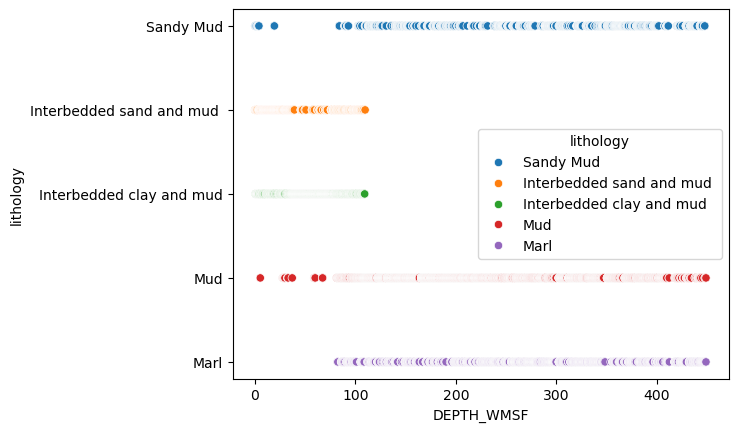

In [6]:
sns.scatterplot(data=df, x="DEPTH_WMSF", y="lithology", hue="lithology")

In [7]:
def custom_train_test_split(data, min_threshold, max_threshold):
    data_test = data[(data["DEPTH_WMSF"] >= min_threshold) & (data["DEPTH_WMSF"] <= max_threshold)]
    data_train = data[(data["DEPTH_WMSF"] < min_threshold) | (data["DEPTH_WMSF"] > max_threshold)]
    return data_train, data_test

In [8]:
training_data, test_data = custom_train_test_split(df, 85, 165)
print(f"Percentage of data in test set is {(len(test_data) * 100/len(df)):.2f}%")

Percentage of data in test set is 21.98%


In [9]:
print(training_data["lithology"].value_counts())
print(test_data["lithology"].value_counts())

lithology
Mud                          3435
Marl                         1678
Interbedded clay and mud     1616
Sandy Mud                    1160
Interbedded sand and mud      756
Name: count, dtype: int64
lithology
Mud                          1498
Marl                          325
Interbedded clay and mud      230
Sandy Mud                     209
Interbedded sand and mud      173
Name: count, dtype: int64


In [10]:
eda_train_set = training_data.copy(deep=True)
eda_train_set.describe(include="all")

,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU,lithology,munsel_color
count,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645,8645
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,40
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mud,10B 8 12
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3435,2797
mean,219.082236,38.131423,1.029344,6.199051,1.490388,368.278207,426.310959,599.926439,NaN,NaN
std,129.632030,21.314662,0.634712,3.249309,0.842865,758.244064,788.382452,2335.089100,NaN,NaN
min,0.072400,0.029500,-0.070000,-0.136600,-0.414000,0.362000,0.438100,0.091500,NaN,NaN
25%,75.030000,18.775500,0.467600,3.045500,0.781900,1.191000,1.119000,0.628100,NaN,NaN
50%,232.939600,40.084900,1.025000,6.746200,1.470400,1.389300,1.287500,0.785400,NaN,NaN
75%,324.547600,54.876100,1.523200,8.714100,2.039800,46.648800,124.447200,1.107600,NaN,NaN


In [11]:
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

set_config(transform_output="pandas")

In [12]:
class ValuesFilter(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, min_threshold: int = 0, max_threshold: int = 100):
        self.min_threshold = min_threshold
        self.max_threshold = max_threshold
        return

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.columns = X.columns
        if isinstance(X, pd.Series):
            self.columns = [X.name]
        if isinstance(X, np.ndarray):
            raise TypeError("X must be a pandas DataFrame or Series")
        return self

    def transform(self, X):
        vals = X.values
        vals[vals < self.min_threshold] = np.nan
        vals[vals > self.max_threshold] = np.nan
        return vals
        
    def get_feature_names_out(self):
        return self.columns
        

In [13]:
values_filter = ValuesFilter(min_threshold=0, max_threshold=1000)
filtered_df = values_filter.fit_transform(eda_train_set.drop(columns=["lithology", "munsel_color"]))
print(values_filter.columns)
print(filtered_df.shape)

Index(['DEPTH_WMSF', 'HCGR', 'HFK', 'HTHO', 'HURA', 'IDPH', 'IMPH', 'SFLU'], dtype='object')
(8645, 8)


In [14]:
filtered_df["lithology"] = eda_train_set["lithology"]
filtered_df["munsel_color"] = eda_train_set["munsel_color"]
eda_train_set = filtered_df

eda_train_set.describe(include="all")

,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU,lithology,munsel_color
count,8645.000000,8645.000000,8625.000000,8636.000000,8580.000000,7030.000000,6746.000000,8111.000000,8645,8645
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,40
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mud,10B 8 12
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3435,2797
mean,219.082236,38.131423,1.031801,6.205594,1.502659,4.909687,11.243240,0.809280,NaN,NaN
std,129.632030,21.314662,0.633390,3.244671,0.834089,12.130832,33.637453,0.406254,NaN,NaN
min,0.072400,0.029500,0.000000,0.038000,0.002200,0.362000,0.438100,0.091500,NaN,NaN
25%,75.030000,18.775500,0.471500,3.052350,0.802350,1.164500,1.086400,0.619000,NaN,NaN
50%,232.939600,40.084900,1.028000,6.748500,1.481200,1.286200,1.213400,0.751600,NaN,NaN
75%,324.547600,54.876100,1.524700,8.716400,2.044200,1.536275,1.355475,1.060350,NaN,NaN


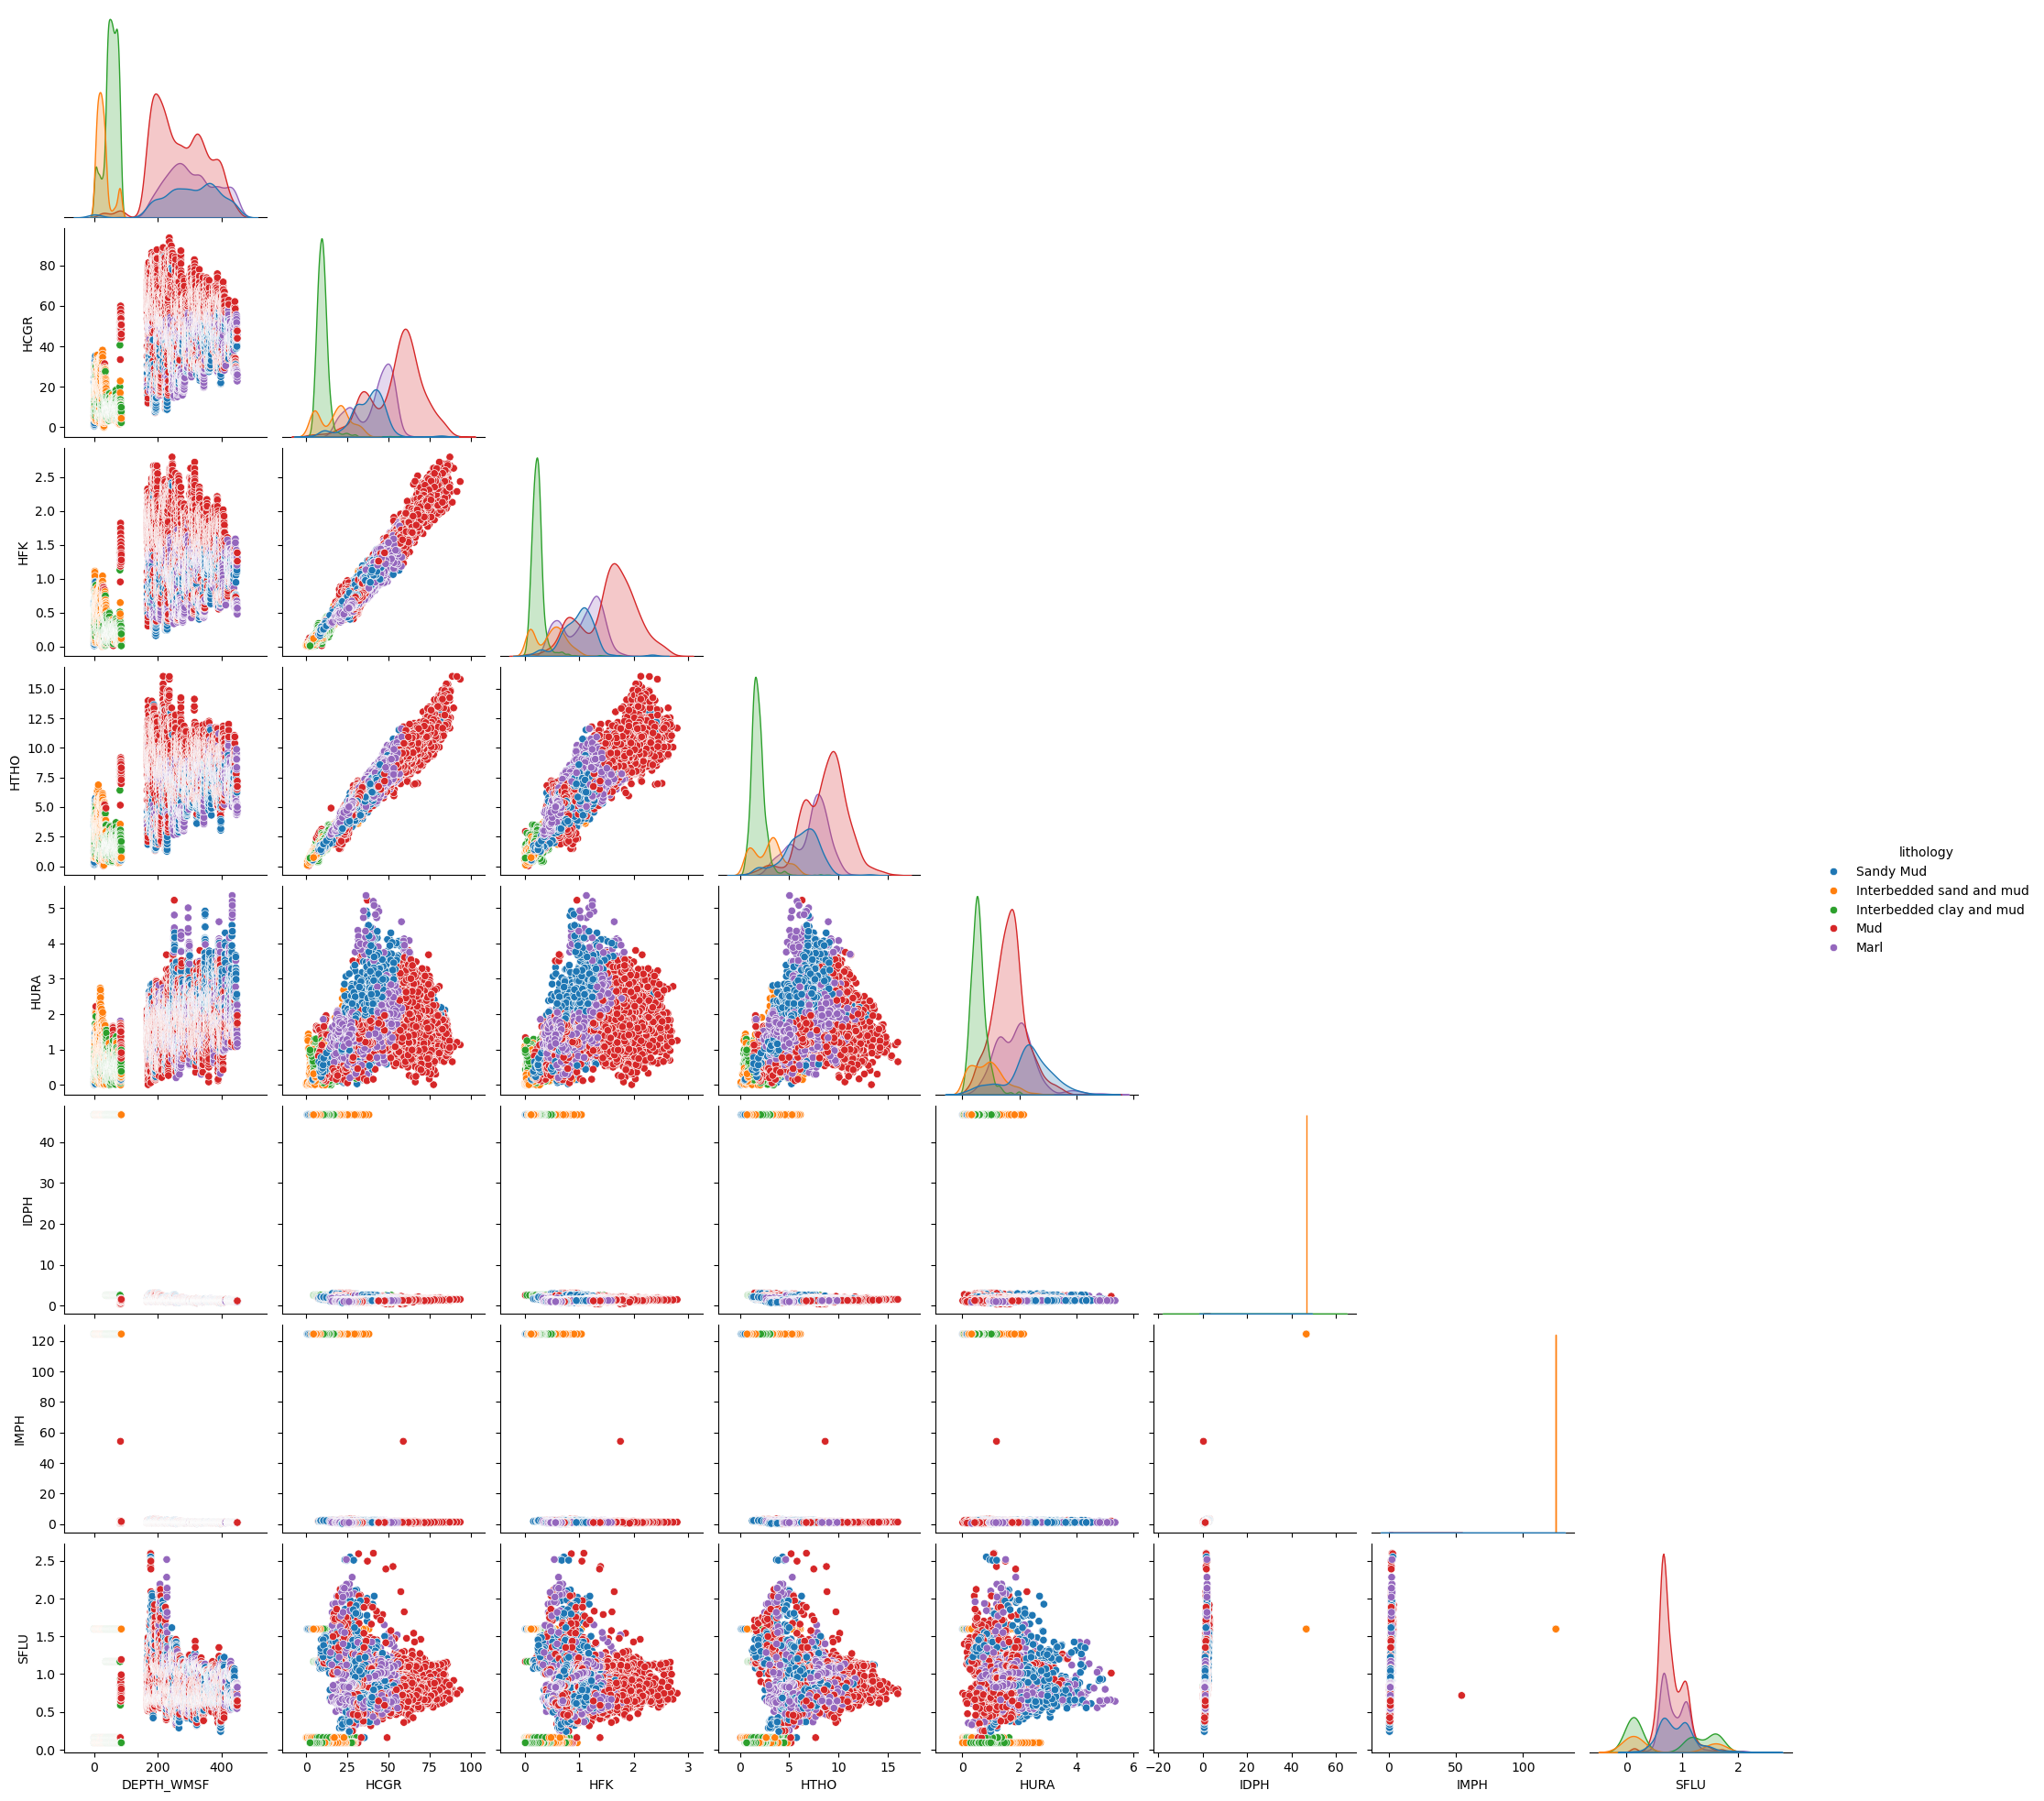

In [15]:
sns.pairplot(data=eda_train_set, hue="lithology", corner=True)

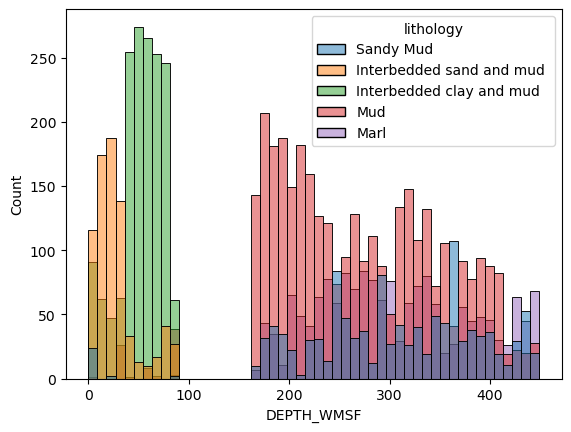

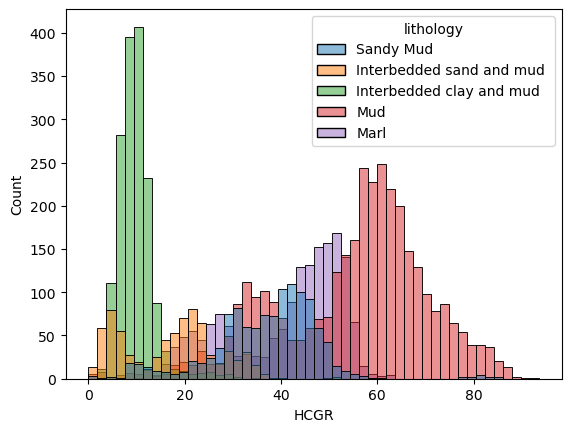

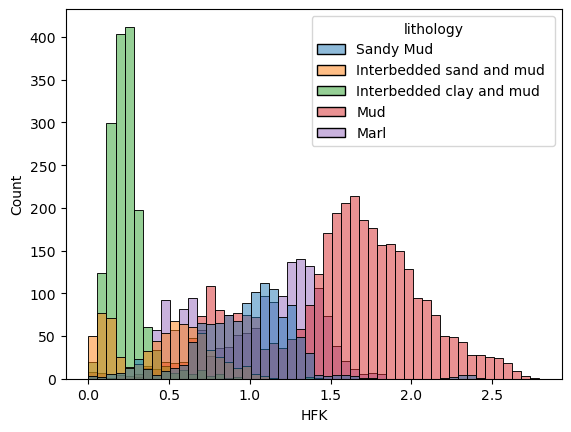

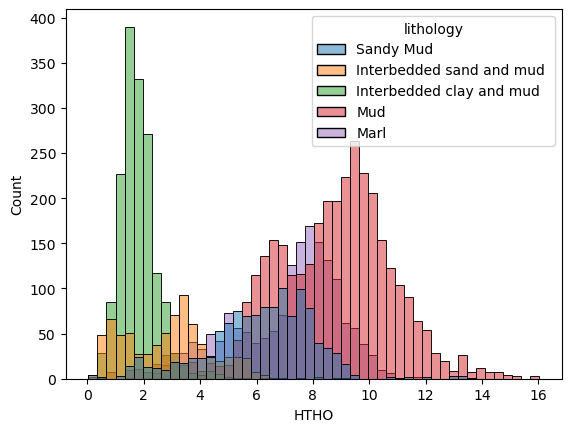

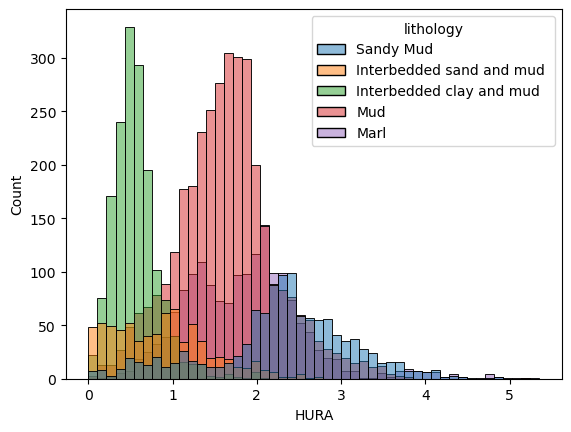

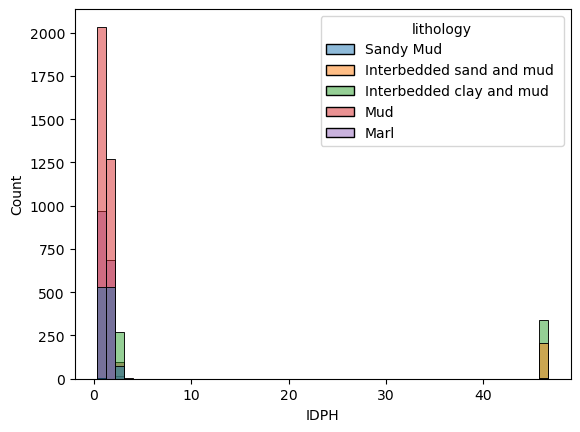

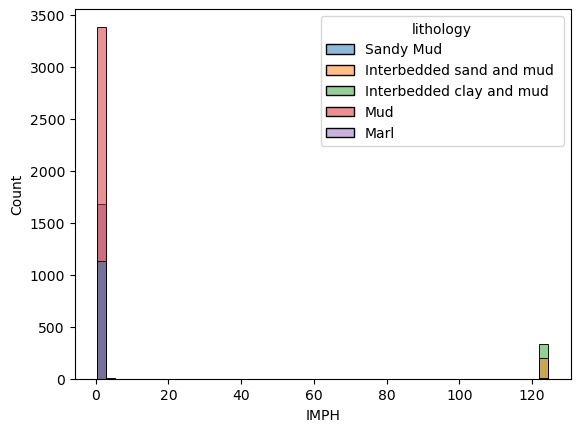

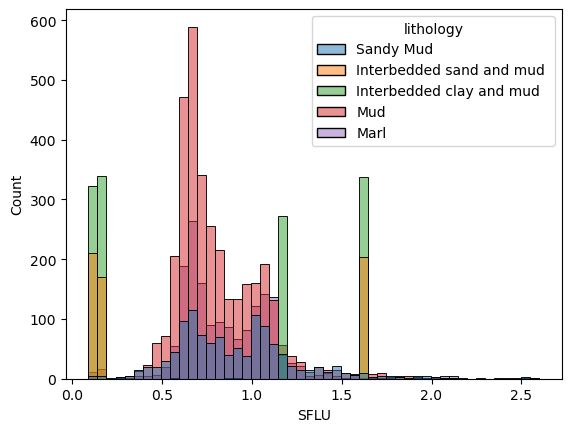

In [16]:

columns = ['DEPTH_WMSF', 'HCGR', 'HFK', 'HTHO', 'HURA', 'IDPH', 'IMPH', 'SFLU']
for column in columns:
    sns.histplot(data=eda_train_set, x=column, hue="lithology", bins=50)
    plt.show()

In [17]:
class LogTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self):
        return

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.columns = X.columns
        if isinstance(X, pd.Series):
            self.columns = [X.name]
        if isinstance(X, np.ndarray):
            raise TypeError("X must be a pandas DataFrame or Series")
        return self

    def transform(self, X):
        return np.log(X)

    def get_feature_names_out(self):
        return self.columns

<Axes: ylabel='Count'>

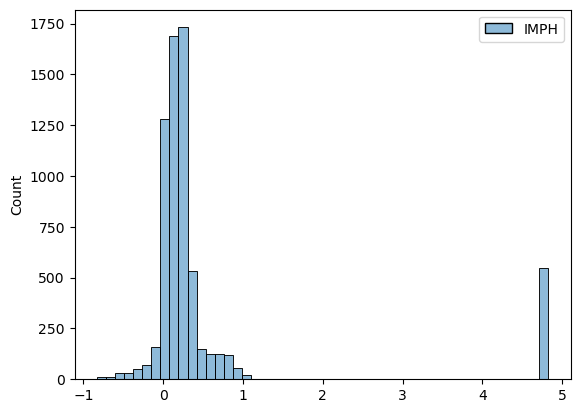

In [18]:
log_transformer = LogTransformer()
log_transformed_imph = log_transformer.fit_transform(eda_train_set["IMPH"])
sns.histplot(log_transformed_imph, bins=50)

<Axes: xlabel='IMPH_log', ylabel='Count'>

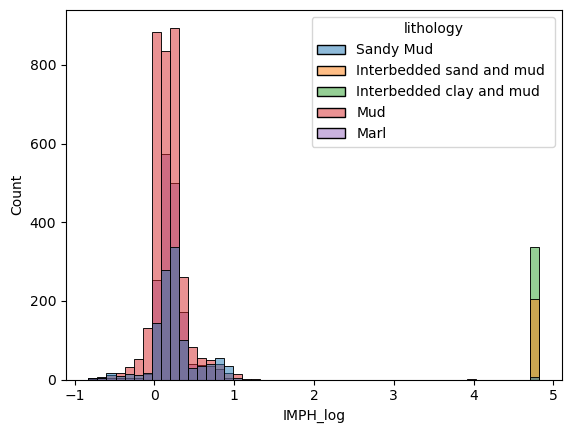

In [19]:
eda_train_set["IMPH_log"] = log_transformed_imph
sns.histplot(data=eda_train_set, x="IMPH_log", hue="lithology", bins=50)

In [20]:
eda_train_set.head()

,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU,lithology,munsel_color,IMPH_log
0,0.0724,5.8481,0.0959,1.3131,NaN,NaN,NaN,0.0915,Sandy Mud,5R 4 10,NaN
1,0.0736,0.5881,0.0116,0.1206,0.0077,46.6488,124.4472,1.5966,Sandy Mud,10PB 0.2 18,4.823882
2,0.0880,1.9945,0.0354,0.4317,0.0501,NaN,NaN,0.1589,Interbedded sand and mud,2.5YR 8 10,NaN
3,0.0920,22.4306,0.6522,3.3707,0.0916,NaN,NaN,NaN,Sandy Mud,10PB 0.2 18,NaN
4,0.2248,7.6691,0.1369,1.6566,NaN,NaN,NaN,0.0915,Sandy Mud,10PB 0.2 18,NaN


<Axes: xlabel='IDPH_log', ylabel='Count'>

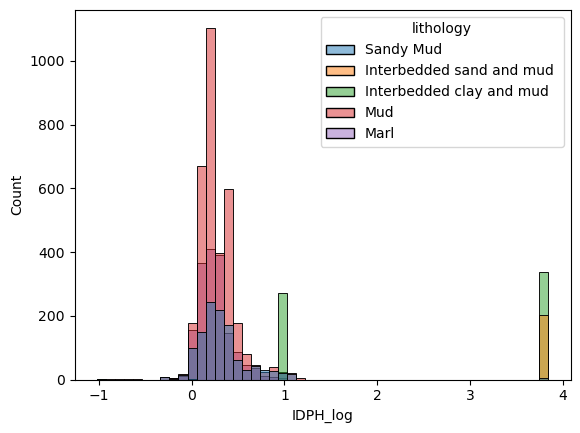

In [21]:
log_transformed_idph = log_transformer.fit_transform(eda_train_set["IDPH"])
eda_train_set["IDPH_log"] = log_transformed_idph
sns.histplot(data=eda_train_set, x="IDPH_log", hue="lithology", bins=50)

In [22]:
# print(eda_train_set["munsel_color"].value_counts())
print(eda_train_set["munsel_color"].value_counts().shape)

(40,)


In [23]:
# Taken from https://github.com/samdroid-apps/python-munsell/blob/master/table.py
table = {
 '10B 0.2 2': [0.133, 0.149, 0.237],
 '10B 0.2 4': [0.088, 0.102, 0.237],
 '10B 0.2 6': [0.063, 0.074, 0.237],
 '10B 0.4 2': [0.183, 0.203, 0.467],
 '10B 0.4 4': [0.126, 0.145, 0.467],
 '10B 0.4 6': [0.093, 0.105, 0.467],
 '10B 0.4 8': [0.067, 0.067, 0.467],
 '10B 0.6 2': [0.209, 0.227, 0.699],
 '10B 0.6 4': [0.153, 0.172, 0.699],
 '10B 0.6 6': [0.115, 0.128, 0.699],
 '10B 0.6 8': [0.084, 0.091, 0.699],
 '10B 0.8 10': [0.071, 0.083, 0.943],
 '10B 0.8 2': [0.222, 0.241, 0.943],
 '10B 0.8 4': [0.168, 0.187, 0.943],
 '10B 0.8 6': [0.128, 0.145, 0.943],
 '10B 0.8 8': [0.097, 0.112, 0.943],
 '10B 1 10': [0.084, 0.094, 1.21],
 '10B 1 2': [0.2309, 0.2491, 1.21],
 '10B 1 4': [0.1783, 0.1974, 1.21],
 '10B 1 6': [0.1392, 0.1563, 1.21],
 '10B 1 8': [0.1077, 0.1218, 1.21],
 '10B 10 2': [0.296, 0.309, 102.57],
 '10B 10 4': [0.272, 0.294, 102.57],
 '10B 10 6': [0.251, 0.28, 102.57],
 '10B 2 10': [0.1157, 0.1346, 3.126],
 '10B 2 12': [0.099, 0.115, 3.126],
 '10B 2 14': [0.083, 0.097, 3.126],
 '10B 2 2': [0.2558, 0.2725, 3.126],
 '10B 2 4': [0.2102, 0.2313, 3.126],
 '10B 2 6': [0.1716, 0.1937, 3.126],
 '10B 2 8': [0.1396, 0.1603, 3.126],
 '10B 3 10': [0.1432, 0.1675, 6.55],
 '10B 3 12': [0.1228, 0.146, 6.55],
 '10B 3 14': [0.1065, 0.1285, 6.55],
 '10B 3 16': [0.095, 0.115, 6.55],
 '10B 3 18': [0.084, 0.1, 6.55],
 '10B 3 2': [0.2631, 0.2801, 6.55],
 '10B 3 4': [0.2246, 0.2467, 6.55],
 '10B 3 6': [0.1933, 0.2173, 6.55],
 '10B 3 8': [0.1658, 0.1905, 6.55],
 '10B 4 10': [0.1681, 0.1954, 12.0],
 '10B 4 12': [0.1487, 0.176, 12.0],
 '10B 4 14': [0.131, 0.158, 12.0],
 '10B 4 16': [0.1155, 0.1416, 12.0],
 '10B 4 18': [0.103, 0.128, 12.0],
 '10B 4 2': [0.2753, 0.291, 12.0],
 '10B 4 20': [0.092, 0.117, 12.0],
 '10B 4 4': [0.2429, 0.2648, 12.0],
 '10B 4 6': [0.2157, 0.2407, 12.0],
 '10B 4 8': [0.1893, 0.216, 12.0],
 '10B 5 10': [0.186, 0.2149, 19.77],
 '10B 5 12': [0.1666, 0.1964, 19.77],
 '10B 5 14': [0.1492, 0.1797, 19.77],
 '10B 5 16': [0.1326, 0.1632, 19.77],
 '10B 5 18': [0.1203, 0.1505, 19.77],
 '10B 5 2': [0.2821, 0.2966, 19.77],
 '10B 5 20': [0.108, 0.137, 19.77],
 '10B 5 22': [0.096, 0.126, 19.77],
 '10B 5 4': [0.2547, 0.2757, 19.77],
 '10B 5 6': [0.2299, 0.2548, 19.77],
 '10B 5 8': [0.2067, 0.2344, 19.77],
 '10B 6 10': [0.2, 0.2298, 30.03],
 '10B 6 12': [0.1803, 0.2114, 30.03],
 '10B 6 14': [0.1629, 0.1947, 30.03],
 '10B 6 16': [0.1454, 0.1778, 30.03],
 '10B 6 18': [0.131, 0.164, 30.03],
 '10B 6 2': [0.2871, 0.3012, 30.03],
 '10B 6 20': [0.12, 0.153, 30.03],
 '10B 6 22': [0.111, 0.144, 30.03],
 '10B 6 24': [0.099, 0.133, 30.03],
 '10B 6 4': [0.2637, 0.284, 30.03],
 '10B 6 6': [0.2399, 0.265, 30.03],
 '10B 6 8': [0.2189, 0.2468, 30.03],
 '10B 7 10': [0.2078, 0.2382, 43.06],
 '10B 7 12': [0.1883, 0.2203, 43.06],
 '10B 7 14': [0.172, 0.206, 43.06],
 '10B 7 16': [0.156, 0.19, 43.06],
 '10B 7 18': [0.141, 0.176, 43.06],
 '10B 7 2': [0.2908, 0.3039, 43.06],
 '10B 7 20': [0.128, 0.162, 43.06],
 '10B 7 4': [0.2685, 0.2886, 43.06],
 '10B 7 6': [0.2478, 0.2728, 43.06],
 '10B 7 8': [0.2277, 0.2559, 43.06],
 '10B 8 10': [0.21, 0.242, 59.1],
 '10B 8 12': [0.19, 0.224, 59.1],
 '10B 8 14': [0.174, 0.206, 59.1],
 '10B 8 2': [0.2935, 0.3062, 59.1],
 '10B 8 4': [0.2718, 0.2911, 59.1],
 '10B 8 6': [0.2512, 0.276, 59.1],
 '10B 8 8': [0.2294, 0.2587, 59.1],
 '10B 9 10': [0.216, 0.25, 78.66],
 '10B 9 2': [0.2949, 0.3076, 78.66],
 '10B 9 4': [0.2712, 0.2924, 78.66],
 '10B 9 6': [0.25, 0.278, 78.66],
 '10B 9 8': [0.233, 0.265, 78.66],
 '10BG 0.2 2': [0.085, 0.195, 0.237],
 '10BG 0.2 4': [0.015, 0.148, 0.237],
 '10BG 0.4 2': [0.169, 0.249, 0.467],
 '10BG 0.4 4': [0.074, 0.187, 0.467],
 '10BG 0.4 6': [0.032, 0.149, 0.467],
 '10BG 0.6 2': [0.206, 0.276, 0.699],
 '10BG 0.6 4': [0.116, 0.221, 0.699],
 '10BG 0.6 6': [0.052, 0.176, 0.699],
 '10BG 0.8 2': [0.223, 0.28, 0.943],
 '10BG 0.8 4': [0.146, 0.237, 0.943],
 '10BG 0.8 6': [0.086, 0.199, 0.943],
 '10BG 0.8 8': [0.033, 0.164, 0.943],
 '10BG 1 2': [0.2362, 0.2882, 1.21],
 '10BG 1 4': [0.1658, 0.2496, 1.21],
 '10BG 1 6': [0.1074, 0.2129, 1.21],
 '10BG 1 8': [0.06, 0.18, 1.21],
 '10BG 10 10': [0.219, 0.308, 102.57],
 '10BG 10 12': [0.203, 0.305, 102.57],
 '10BG 10 2': [0.293, 0.315, 102.57],
 '10BG 10 4': [0.27, 0.313, 102.57],
 '10BG 10 6': [0.251, 0.311, 102.57],
 '10BG 10 8': [0.234, 0.31, 102.57],
 '10BG 2 10': [0.0929, 0.2133, 3.126],
 '10BG 2 12': [0.068, 0.194, 3.126],
 '10BG 2 14': [0.05, 0.181, 3.126],
 '10BG 2 2': [0.2606, 0.301, 3.126],
 '10BG 2 4': [0.2096, 0.279, 3.126],
 '10BG 2 6': [0.1669, 0.257, 3.126],
 '10BG 2 8': [0.1258, 0.2331, 3.126],
 '10BG 3 10': [0.125, 0.2411, 6.55],
 '10BG 3 12': [0.1018, 0.2281, 6.55],
 '10BG 3 14': [0.0798, 0.2151, 6.55],
 '10BG 3 16': [0.065, 0.206, 6.55],
 '10BG 3 18': [0.053, 0.199, 6.55],
 '10BG 3 2': [0.266, 0.305, 6.55],
 '10BG 3 4': [0.2221, 0.2886, 6.55],
 '10BG 3 6': [0.1861, 0.2722, 6.55],
 '10BG 3 8': [0.1551, 0.2571, 6.55],
 '10BG 4 10': [0.148, 0.26, 12.0],
 '10BG 4 12': [0.1248, 0.2484, 12.0],
 '10BG 4 14': [0.1033, 0.2376, 12.0],
 '10BG 4 16': [0.0888, 0.2298, 12.0],
 '10BG 4 18': [0.073, 0.221, 12.0],
 '10BG 4 2': [0.274, 0.3091, 12.0],
 '10BG 4 20': [0.062, 0.214, 12.0],
 '10BG 4 22': [0.051, 0.207, 12.0],
 '10BG 4 4': [0.2384, 0.2984, 12.0],
 '10BG 4 6': [0.2065, 0.2863, 12.0],
 '10BG 4 8': [0.176, 0.273, 12.0],
 '10BG 5 10': [0.1716, 0.276, 19.77],
 '10BG 5 12': [0.1485, 0.2662, 19.77],
 '10BG 5 14': [0.1308, 0.2582, 19.77],
 '10BG 5 16': [0.1108, 0.2489, 19.77],
 '10BG 5 18': [0.093, 0.24, 19.77],
 '10BG 5 2': [0.2796, 0.3111, 19.77],
 '10BG 5 20': [0.079, 0.232, 19.77],
 '10BG 5 22': [0.066, 0.226, 19.77],
 '10BG 5 24': [0.058, 0.221, 19.77],
 '10BG 5 4': [0.2512, 0.304, 19.77],
 '10BG 5 6': [0.2234, 0.2952, 19.77],
 '10BG 5 8': [0.197, 0.286, 19.77],
 '10BG 6 10': [0.1909, 0.2881, 30.03],
 '10BG 6 12': [0.1698, 0.2802, 30.03],
 '10BG 6 14': [0.1518, 0.2729, 30.03],
 '10BG 6 16': [0.1337, 0.2651, 30.03],
 '10BG 6 18': [0.1181, 0.2581, 30.03],
 '10BG 6 2': [0.2837, 0.3132, 30.03],
 '10BG 6 20': [0.101, 0.251, 30.03],
 '10BG 6 22': [0.086, 0.244, 30.03],
 '10BG 6 24': [0.072, 0.237, 30.03],
 '10BG 6 4': [0.2578, 0.3078, 30.03],
 '10BG 6 6': [0.2335, 0.3015, 30.03],
 '10BG 6 8': [0.2116, 0.295, 30.03],
 '10BG 7 10': [0.2035, 0.2956, 43.06],
 '10BG 7 12': [0.1841, 0.2892, 43.06],
 '10BG 7 14': [0.1671, 0.2832, 43.06],
 '10BG 7 16': [0.1489, 0.2768, 43.06],
 '10BG 7 18': [0.134, 0.271, 43.06],
 '10BG 7 2': [0.2869, 0.3143, 43.06],
 '10BG 7 20': [0.122, 0.266, 43.06],
 '10BG 7 22': [0.108, 0.26, 43.06],
 '10BG 7 24': [0.094, 0.253, 43.06],
 '10BG 7 4': [0.2642, 0.3109, 43.06],
 '10BG 7 6': [0.2448, 0.3069, 43.06],
 '10BG 7 8': [0.2235, 0.3014, 43.06],
 '10BG 8 10': [0.212, 0.3025, 59.1],
 '10BG 8 12': [0.1937, 0.2978, 59.1],
 '10BG 8 14': [0.1788, 0.2936, 59.1],
 '10BG 8 16': [0.161, 0.288, 59.1],
 '10BG 8 18': [0.145, 0.282, 59.1],
 '10BG 8 2': [0.2894, 0.3152, 59.1],
 '10BG 8 20': [0.133, 0.278, 59.1],
 '10BG 8 22': [0.118, 0.273, 59.1],
 '10BG 8 4': [0.2686, 0.313, 59.1],
 '10BG 8 6': [0.2489, 0.3099, 59.1],
 '10BG 8 8': [0.2302, 0.3063, 59.1],
 '10BG 9 10': [0.214, 0.306, 78.66],
 '10BG 9 12': [0.196, 0.304, 78.66],
 '10BG 9 14': [0.18, 0.301, 78.66],
 '10BG 9 16': [0.162, 0.298, 78.66],
 '10BG 9 18': [0.147, 0.294, 78.66],
 '10BG 9 2': [0.2907, 0.3159, 78.66],
 '10BG 9 4': [0.27, 0.314, 78.66],
 '10BG 9 6': [0.2501, 0.3118, 78.66],
 '10BG 9 8': [0.232, 0.31, 78.66],
 '10G 0.2 2': [0.08, 0.397, 0.237],
 '10G 0.2 4': [-0.137, 0.425, 0.237],
 '10G 0.4 2': [0.213, 0.361, 0.467],
 '10G 0.4 4': [-0.004, 0.405, 0.467],
 '10G 0.6 2': [0.247, 0.349, 0.699],
 '10G 0.6 4': [0.124, 0.389, 0.699],
 '10G 0.6 6': [-0.068, 0.425, 0.699],
 '10G 0.8 2': [0.265, 0.346, 0.943],
 '10G 0.8 4': [0.178, 0.382, 0.943],
 '10G 0.8 6': [0.07, 0.408, 0.943],
 '10G 0.8 8': [-0.1, 0.428, 0.943],
 '10G 1 10': [-0.018, 0.424, 1.21],
 '10G 1 2': [0.2689, 0.3407, 1.21],
 '10G 1 4': [0.204, 0.3724, 1.21],
 '10G 1 6': [0.1249, 0.4019, 1.21],
 '10G 1 8': [0.0511, 0.4158, 1.21],
 '10G 10 10': [0.248, 0.369, 102.57],
 '10G 10 12': [0.235, 0.378, 102.57],
 '10G 10 14': [0.223, 0.387, 102.57],
 '10G 10 2': [0.296, 0.331, 102.57],
 '10G 10 4': [0.284, 0.341, 102.57],
 '10G 10 6': [0.271, 0.351, 102.57],
 '10G 10 8': [0.258, 0.361, 102.57],
 '10G 2 10': [0.1321, 0.4059, 3.126],
 '10G 2 12': [0.0934, 0.4183, 3.126],
 '10G 2 14': [0.0599, 0.427, 3.126],
 '10G 2 16': [0.0285, 0.4327, 3.126],
 '10G 2 18': [-0.007, 0.441, 3.126],
 '10G 2 2': [0.282, 0.3341, 3.126],
 '10G 2 4': [0.2442, 0.3559, 3.126],
 '10G 2 6': [0.2092, 0.3739, 3.126],
 '10G 2 8': [0.1705, 0.3911, 3.126],
 '10G 3 10': [0.1688, 0.3974, 6.55],
 '10G 3 12': [0.1411, 0.4095, 6.55],
 '10G 3 14': [0.1161, 0.4192, 6.55],
 '10G 3 16': [0.0925, 0.4275, 6.55],
 '10G 3 18': [0.0718, 0.434, 6.55],
 '10G 3 2': [0.2844, 0.3337, 6.55],
 '10G 3 20': [0.0528, 0.4393, 6.55],
 '10G 3 22': [0.0333, 0.4444, 6.55],
 '10G 3 24': [0.009, 0.45, 6.55],
 '10G 3 4': [0.2525, 0.3537, 6.55],
 '10G 3 6': [0.224, 0.3699, 6.55],
 '10G 3 8': [0.197, 0.3841, 6.55],
 '10G 4 10': [0.1876, 0.3933, 12.0],
 '10G 4 12': [0.1602, 0.407, 12.0],
 '10G 4 14': [0.1398, 0.4168, 12.0],
 '10G 4 16': [0.1212, 0.4245, 12.0],
 '10G 4 18': [0.1006, 0.433, 12.0],
 '10G 4 2': [0.288, 0.3327, 12.0],
 '10G 4 20': [0.085, 0.4388, 12.0],
 '10G 4 22': [0.0702, 0.444, 12.0],
 '10G 4 24': [0.0553, 0.4492, 12.0],
 '10G 4 26': [0.04, 0.4545, 12.0],
 '10G 4 28': [0.023, 0.46, 12.0],
 '10G 4 30': [0.008, 0.465, 12.0],
 '10G 4 4': [0.2628, 0.3498, 12.0],
 '10G 4 6': [0.2374, 0.3655, 12.0],
 '10G 4 8': [0.2124, 0.3799, 12.0],
 '10G 5 10': [0.2095, 0.3853, 19.77],
 '10G 5 12': [0.1852, 0.3992, 19.77],
 '10G 5 14': [0.1671, 0.4089, 19.77],
 '10G 5 16': [0.1469, 0.4192, 19.77],
 '10G 5 18': [0.1275, 0.4288, 19.77],
 '10G 5 2': [0.291, 0.331, 19.77],
 '10G 5 20': [0.112, 0.436, 19.77],
 '10G 5 22': [0.0958, 0.4428, 19.77],
 '10G 5 24': [0.0811, 0.4491, 19.77],
 '10G 5 26': [0.069, 0.4542, 19.77],
 '10G 5 28': [0.0572, 0.459, 19.77],
 '10G 5 30': [0.041, 0.466, 19.77],
 '10G 5 32': [0.023, 0.474, 19.77],
 '10G 5 4': [0.2711, 0.3455, 19.77],
 '10G 5 6': [0.2519, 0.3587, 19.77],
 '10G 5 8': [0.2297, 0.373, 19.77],
 '10G 6 10': [0.2247, 0.3796, 30.03],
 '10G 6 12': [0.206, 0.3914, 30.03],
 '10G 6 14': [0.1895, 0.4015, 30.03],
 '10G 6 16': [0.1722, 0.4113, 30.03],
 '10G 6 18': [0.1551, 0.4208, 30.03],
 '10G 6 2': [0.2929, 0.3303, 30.03],
 '10G 6 20': [0.1382, 0.4299, 30.03],
 '10G 6 22': [0.123, 0.4378, 30.03],
 '10G 6 24': [0.107, 0.4458, 30.03],
 '10G 6 26': [0.0941, 0.452, 30.03],
 '10G 6 28': [0.081, 0.458, 30.03],
 '10G 6 30': [0.066, 0.465, 30.03],
 '10G 6 32': [0.052, 0.471, 30.03],
 '10G 6 34': [0.035, 0.48, 30.03],
 '10G 6 4': [0.2749, 0.3443, 30.03],
 '10G 6 6': [0.2591, 0.3558, 30.03],
 '10G 6 8': [0.242, 0.3679, 30.03],
 '10G 7 10': [0.2352, 0.3748, 43.06],
 '10G 7 12': [0.2195, 0.3854, 43.06],
 '10G 7 14': [0.2033, 0.3956, 43.06],
 '10G 7 16': [0.1881, 0.4049, 43.06],
 '10G 7 18': [0.1734, 0.4135, 43.06],
 '10G 7 2': [0.2945, 0.3297, 43.06],
 '10G 7 20': [0.1589, 0.422, 43.06],
 '10G 7 22': [0.1434, 0.4306, 43.06],
 '10G 7 24': [0.131, 0.4377, 43.06],
 '10G 7 26': [0.121, 0.443, 43.06],
 '10G 7 28': [0.108, 0.449, 43.06],
 '10G 7 30': [0.094, 0.457, 43.06],
 '10G 7 32': [0.083, 0.463, 43.06],
 '10G 7 4': [0.2803, 0.3415, 43.06],
 '10G 7 6': [0.2662, 0.3526, 43.06],
 '10G 7 8': [0.2513, 0.3635, 43.06],
 '10G 8 10': [0.243, 0.371, 59.1],
 '10G 8 12': [0.2282, 0.3811, 59.1],
 '10G 8 14': [0.2148, 0.3903, 59.1],
 '10G 8 16': [0.2012, 0.3992, 59.1],
 '10G 8 18': [0.1866, 0.4086, 59.1],
 '10G 8 2': [0.2957, 0.3293, 59.1],
 '10G 8 20': [0.1734, 0.4164, 59.1],
 '10G 8 22': [0.159, 0.424, 59.1],
 '10G 8 24': [0.142, 0.433, 59.1],
 '10G 8 26': [0.127, 0.441, 59.1],
 '10G 8 28': [0.112, 0.448, 59.1],
 '10G 8 4': [0.2828, 0.3403, 59.1],
 '10G 8 6': [0.2693, 0.3512, 59.1],
 '10G 8 8': [0.2564, 0.3611, 59.1],
 '10G 9 10': [0.2457, 0.3702, 78.66],
 '10G 9 12': [0.2325, 0.3796, 78.66],
 '10G 9 14': [0.217, 0.388, 78.66],
 '10G 9 16': [0.203, 0.396, 78.66],
 '10G 9 18': [0.188, 0.405, 78.66],
 '10G 9 2': [0.2965, 0.3293, 78.66],
 '10G 9 20': [0.175, 0.411, 78.66],
 '10G 9 22': [0.161, 0.419, 78.66],
 '10G 9 24': [0.147, 0.425, 78.66],
 '10G 9 4': [0.284, 0.3402, 78.66],
 '10G 9 6': [0.2703, 0.3513, 78.66],
 '10G 9 8': [0.2574, 0.3618, 78.66],
 '10GY 0.2 2': [0.185, 0.676, 0.237],
 '10GY 0.2 4': [-0.257, 1.233, 0.237],
 '10GY 0.4 2': [0.277, 0.445, 0.467],
 '10GY 0.4 4': [0.041, 0.906, 0.467],
 '10GY 0.6 2': [0.292, 0.399, 0.699],
 '10GY 0.6 4': [0.208, 0.652, 0.699],
 '10GY 0.6 6': [-0.128, 1.125, 0.699],
 '10GY 0.8 2': [0.298, 0.381, 0.943],
 '10GY 0.8 4': [0.254, 0.537, 0.943],
 '10GY 0.8 6': [0.15, 0.791, 0.943],
 '10GY 0.8 8': [-0.156, 1.22, 0.943],
 '10GY 1 10': [-0.013, 1.065, 1.21],
 '10GY 1 2': [0.3006, 0.372, 1.21],
 '10GY 1 4': [0.2722, 0.4903, 1.21],
 '10GY 1 6': [0.2232, 0.6392, 1.21],
 '10GY 1 8': [0.11, 0.883, 1.21],
 '10GY 10 10': [0.314, 0.454, 102.57],
 '10GY 10 12': [0.314, 0.474, 102.57],
 '10GY 10 14': [0.313, 0.5, 102.57],
 '10GY 10 16': [0.31, 0.527, 102.57],
 '10GY 10 18': [0.307, 0.556, 102.57],
 '10GY 10 2': [0.312, 0.346, 102.57],
 '10GY 10 20': [0.303, 0.58, 102.57],
 '10GY 10 22': [0.299, 0.6, 102.57],
 '10GY 10 4': [0.314, 0.37, 102.57],
 '10GY 10 6': [0.314, 0.4, 102.57],
 '10GY 10 8': [0.314, 0.423, 102.57],
 '10GY 2 10': [0.2307, 0.6814, 3.126],
 '10GY 2 12': [0.1907, 0.7798, 3.126],
 '10GY 2 14': [0.141, 0.876, 3.126],
 '10GY 2 16': [0.061, 0.998, 3.126],
 '10GY 2 18': [-0.03, 1.11, 3.126],
 '10GY 2 2': [0.3069, 0.358, 3.126],
 '10GY 2 4': [0.2986, 0.424, 3.126],
 '10GY 2 6': [0.2852, 0.4972, 3.126],
 '10GY 2 8': [0.2628, 0.5837, 3.126],
 '10GY 3 10': [0.2724, 0.6026, 6.55],
 '10GY 3 12': [0.2531, 0.67, 6.55],
 '10GY 3 14': [0.2283, 0.7423, 6.55],
 '10GY 3 16': [0.202, 0.807, 6.55],
 '10GY 3 18': [0.168, 0.88, 6.55],
 '10GY 3 2': [0.3088, 0.3578, 6.55],
 '10GY 3 20': [0.13, 0.948, 6.55],
 '10GY 3 22': [0.089, 1.014, 6.55],
 '10GY 3 24': [0.046, 1.078, 6.55],
 '10GY 3 4': [0.3053, 0.4123, 6.55],
 '10GY 3 6': [0.2992, 0.4717, 6.55],
 '10GY 3 8': [0.2887, 0.5361, 6.55],
 '10GY 4 10': [0.2908, 0.5672, 12.0],
 '10GY 4 12': [0.2758, 0.6282, 12.0],
 '10GY 4 14': [0.259, 0.6858, 12.0],
 '10GY 4 16': [0.2422, 0.736, 12.0],
 '10GY 4 18': [0.221, 0.793, 12.0],
 '10GY 4 2': [0.3109, 0.355, 12.0],
 '10GY 4 20': [0.192, 0.86, 12.0],
 '10GY 4 22': [0.165, 0.917, 12.0],
 '10GY 4 24': [0.142, 0.964, 12.0],
 '10GY 4 26': [0.106, 1.028, 12.0],
 '10GY 4 28': [0.058, 1.1, 12.0],
 '10GY 4 4': [0.31, 0.4018, 12.0],
 '10GY 4 6': [0.3069, 0.455, 12.0],
 '10GY 4 8': [0.3008, 0.5095, 12.0],
 '10GY 5 10': [0.3028, 0.5237, 19.77],
 '10GY 5 12': [0.294, 0.5751, 19.77],
 '10GY 5 14': [0.2838, 0.6208, 19.77],
 '10GY 5 16': [0.2702, 0.67, 19.77],
 '10GY 5 18': [0.2549, 0.7179, 19.77],
 '10GY 5 2': [0.311, 0.3508, 19.77],
 '10GY 5 20': [0.237, 0.767, 19.77],
 '10GY 5 22': [0.221, 0.808, 19.77],
 '10GY 5 24': [0.202, 0.852, 19.77],
 '10GY 5 26': [0.179, 0.898, 19.77],
 '10GY 5 28': [0.154, 0.949, 19.77],
 '10GY 5 30': [0.125, 1.0, 19.77],
 '10GY 5 32': [0.097, 1.048, 19.77],
 '10GY 5 4': [0.3111, 0.3881, 19.77],
 '10GY 5 6': [0.3108, 0.4301, 19.77],
 '10GY 5 8': [0.308, 0.4759, 19.77],
 '10GY 6 10': [0.3086, 0.4949, 30.03],
 '10GY 6 12': [0.3037, 0.5358, 30.03],
 '10GY 6 14': [0.2962, 0.5802, 30.03],
 '10GY 6 16': [0.2872, 0.6199, 30.03],
 '10GY 6 18': [0.2763, 0.6616, 30.03],
 '10GY 6 2': [0.3112, 0.3496, 30.03],
 '10GY 6 20': [0.2648, 0.7004, 30.03],
 '10GY 6 22': [0.253, 0.738, 30.03],
 '10GY 6 24': [0.238, 0.782, 30.03],
 '10GY 6 26': [0.225, 0.82, 30.03],
 '10GY 6 28': [0.208, 0.863, 30.03],
 '10GY 6 30': [0.188, 0.905, 30.03],
 '10GY 6 32': [0.171, 0.939, 30.03],
 '10GY 6 4': [0.3124, 0.3822, 30.03],
 '10GY 6 6': [0.3128, 0.4175, 30.03],
 '10GY 6 8': [0.3116, 0.4563, 30.03],
 '10GY 7 10': [0.3123, 0.4732, 43.06],
 '10GY 7 12': [0.3092, 0.5095, 43.06],
 '10GY 7 14': [0.3047, 0.5458, 43.06],
 '10GY 7 16': [0.2981, 0.5835, 43.06],
 '10GY 7 18': [0.2905, 0.6186, 43.06],
 '10GY 7 2': [0.3117, 0.3469, 43.06],
 '10GY 7 20': [0.2816, 0.6563, 43.06],
 '10GY 7 22': [0.2728, 0.6893, 43.06],
 '10GY 7 24': [0.262, 0.727, 43.06],
 '10GY 7 26': [0.252, 0.758, 43.06],
 '10GY 7 28': [0.242, 0.79, 43.06],
 '10GY 7 30': [0.233, 0.819, 43.06],
 '10GY 7 32': [0.224, 0.851, 43.06],
 '10GY 7 4': [0.3133, 0.3764, 43.06],
 '10GY 7 6': [0.3142, 0.4058, 43.06],
 '10GY 7 8': [0.314, 0.4387, 43.06],
 '10GY 8 10': [0.314, 0.4601, 59.1],
 '10GY 8 12': [0.3124, 0.4926, 59.1],
 '10GY 8 14': [0.3091, 0.5247, 59.1],
 '10GY 8 16': [0.3043, 0.5578, 59.1],
 '10GY 8 18': [0.2987, 0.5919, 59.1],
 '10GY 8 2': [0.3121, 0.3459, 59.1],
 '10GY 8 20': [0.2918, 0.6255, 59.1],
 '10GY 8 22': [0.2846, 0.6564, 59.1],
 '10GY 8 24': [0.2781, 0.684, 59.1],
 '10GY 8 26': [0.271, 0.702, 59.1],
 '10GY 8 28': [0.262, 0.726, 59.1],
 '10GY 8 30': [0.252, 0.752, 59.1],
 '10GY 8 32': [0.24, 0.784, 59.1],
 '10GY 8 4': [0.314, 0.3727, 59.1],
 '10GY 8 6': [0.315, 0.4014, 59.1],
 '10GY 8 8': [0.3149, 0.4284, 59.1],
 '10GY 9 10': [0.3155, 0.4558, 78.66],
 '10GY 9 12': [0.3139, 0.4829, 78.66],
 '10GY 9 14': [0.3115, 0.5129, 78.66],
 '10GY 9 16': [0.3079, 0.544, 78.66],
 '10GY 9 18': [0.3032, 0.5748, 78.66],
 '10GY 9 2': [0.3124, 0.3454, 78.66],
 '10GY 9 20': [0.298, 0.602, 78.66],
 '10GY 9 22': [0.292, 0.627, 78.66],
 '10GY 9 24': [0.284, 0.653, 78.66],
 '10GY 9 26': [0.277, 0.681, 78.66],
 '10GY 9 28': [0.268, 0.707, 78.66],
 '10GY 9 4': [0.3144, 0.3711, 78.66],
 '10GY 9 6': [0.3153, 0.4008, 78.66],
 '10GY 9 8': [0.3157, 0.4259, 78.66],
 '10P 0.2 10': [0.29, 0.051, 0.237],
 '10P 0.2 2': [0.3, 0.134, 0.237],
 '10P 0.2 4': [0.296, 0.097, 0.237],
 '10P 0.2 6': [0.293, 0.075, 0.237],
 '10P 0.2 8': [0.291, 0.06, 0.237],
 '10P 0.4 10': [0.296, 0.073, 0.467],
 '10P 0.4 12': [0.294, 0.061, 0.467],
 '10P 0.4 14': [0.293, 0.052, 0.467],
 '10P 0.4 16': [0.291, 0.043, 0.467],
 '10P 0.4 2': [0.309, 0.189, 0.467],
 '10P 0.4 4': [0.304, 0.146, 0.467],
 '10P 0.4 6': [0.302, 0.119, 0.467],
 '10P 0.4 8': [0.298, 0.095, 0.467],
 '10P 0.6 10': [0.302, 0.101, 0.699],
 '10P 0.6 12': [0.301, 0.087, 0.699],
 '10P 0.6 14': [0.299, 0.069, 0.699],
 '10P 0.6 16': [0.298, 0.06, 0.699],
 '10P 0.6 18': [0.297, 0.051, 0.699],
 '10P 0.6 2': [0.311, 0.214, 0.699],
 '10P 0.6 4': [0.308, 0.174, 0.699],
 '10P 0.6 6': [0.306, 0.145, 0.699],
 '10P 0.6 8': [0.304, 0.119, 0.699],
 '10P 0.8 10': [0.307, 0.123, 0.943],
 '10P 0.8 12': [0.306, 0.106, 0.943],
 '10P 0.8 14': [0.304, 0.089, 0.943],
 '10P 0.8 16': [0.303, 0.078, 0.943],
 '10P 0.8 18': [0.302, 0.071, 0.943],
 '10P 0.8 2': [0.312, 0.232, 0.943],
 '10P 0.8 20': [0.302, 0.065, 0.943],
 '10P 0.8 22': [0.302, 0.059, 0.943],
 '10P 0.8 24': [0.302, 0.053, 0.943],
 '10P 0.8 4': [0.31, 0.189, 0.943],
 '10P 0.8 6': [0.309, 0.162, 0.943],
 '10P 0.8 8': [0.308, 0.137, 0.943],
 '10P 1 10': [0.3102, 0.1282, 1.21],
 '10P 1 12': [0.3094, 0.111, 1.21],
 '10P 1 14': [0.3084, 0.0952, 1.21],
 '10P 1 16': [0.3078, 0.0839, 1.21],
 '10P 1 18': [0.3069, 0.0748, 1.21],
 '10P 1 2': [0.3132, 0.2404, 1.21],
 '10P 1 20': [0.307, 0.066, 1.21],
 '10P 1 22': [0.306, 0.058, 1.21],
 '10P 1 24': [0.305, 0.051, 1.21],
 '10P 1 4': [0.3132, 0.2032, 1.21],
 '10P 1 6': [0.3126, 0.1737, 1.21],
 '10P 1 8': [0.3114, 0.1481, 1.21],
 '10P 10 10': [0.328, 0.264, 102.57],
 '10P 10 2': [0.313, 0.309, 102.57],
 '10P 10 4': [0.317, 0.297, 102.57],
 '10P 10 6': [0.321, 0.284, 102.57],
 '10P 10 8': [0.326, 0.273, 102.57],
 '10P 2 10': [0.323, 0.1659, 3.126],
 '10P 2 12': [0.3233, 0.1477, 3.126],
 '10P 2 14': [0.3235, 0.1317, 3.126],
 '10P 2 16': [0.3235, 0.1181, 3.126],
 '10P 2 18': [0.3233, 0.1063, 3.126],
 '10P 2 2': [0.3161, 0.2691, 3.126],
 '10P 2 20': [0.3231, 0.0962, 3.126],
 '10P 2 22': [0.323, 0.0861, 3.126],
 '10P 2 24': [0.322, 0.076, 3.126],
 '10P 2 26': [0.322, 0.068, 3.126],
 '10P 2 28': [0.322, 0.058, 3.126],
 '10P 2 4': [0.3189, 0.239, 3.126],
 '10P 2 6': [0.3207, 0.2132, 3.126],
 '10P 2 8': [0.3219, 0.1862, 3.126],
 '10P 3 10': [0.3286, 0.1889, 6.55],
 '10P 3 12': [0.3301, 0.1715, 6.55],
 '10P 3 14': [0.3309, 0.1572, 6.55],
 '10P 3 16': [0.332, 0.1456, 6.55],
 '10P 3 18': [0.3329, 0.1332, 6.55],
 '10P 3 2': [0.317, 0.279, 6.55],
 '10P 3 20': [0.3332, 0.124, 6.55],
 '10P 3 22': [0.334, 0.1146, 6.55],
 '10P 3 24': [0.3341, 0.1055, 6.55],
 '10P 3 26': [0.3343, 0.0978, 6.55],
 '10P 3 28': [0.335, 0.088, 6.55],
 '10P 3 30': [0.335, 0.081, 6.55],
 '10P 3 32': [0.335, 0.072, 6.55],
 '10P 3 34': [0.335, 0.063, 6.55],
 '10P 3 4': [0.3214, 0.2517, 6.55],
 '10P 3 6': [0.3243, 0.2293, 6.55],
 '10P 3 8': [0.3269, 0.2075, 6.55],
 '10P 4 10': [0.3306, 0.2162, 12.0],
 '10P 4 12': [0.3331, 0.2014, 12.0],
 '10P 4 14': [0.3351, 0.1875, 12.0],
 '10P 4 16': [0.337, 0.1756, 12.0],
 '10P 4 18': [0.3386, 0.1626, 12.0],
 '10P 4 2': [0.3162, 0.2902, 12.0],
 '10P 4 20': [0.34, 0.15, 12.0],
 '10P 4 22': [0.3411, 0.1424, 12.0],
 '10P 4 24': [0.3421, 0.1337, 12.0],
 '10P 4 26': [0.3428, 0.1248, 12.0],
 '10P 4 28': [0.3432, 0.1172, 12.0],
 '10P 4 30': [0.344, 0.108, 12.0],
 '10P 4 32': [0.345, 0.1, 12.0],
 '10P 4 34': [0.346, 0.093, 12.0],
 '10P 4 36': [0.346, 0.085, 12.0],
 '10P 4 38': [0.347, 0.078, 12.0],
 '10P 4 4': [0.321, 0.2686, 12.0],
 '10P 4 6': [0.3248, 0.2493, 12.0],
 '10P 4 8': [0.328, 0.2318, 12.0],
 '10P 5 10': [0.3308, 0.2328, 19.77],
 '10P 5 12': [0.3335, 0.2187, 19.77],
 '10P 5 14': [0.336, 0.2066, 19.77],
 '10P 5 16': [0.3382, 0.1951, 19.77],
 '10P 5 18': [0.3401, 0.184, 19.77],
 '10P 5 2': [0.3148, 0.2986, 19.77],
 '10P 5 20': [0.3422, 0.1735, 19.77],
 '10P 5 22': [0.3437, 0.1644, 19.77],
 '10P 5 24': [0.345, 0.1555, 19.77],
 '10P 5 26': [0.3468, 0.146, 19.77],
 '10P 5 28': [0.3478, 0.1388, 19.77],
 '10P 5 30': [0.349, 0.1308, 19.77],
 '10P 5 32': [0.35, 0.124, 19.77],
 '10P 5 34': [0.351, 0.115, 19.77],
 '10P 5 36': [0.352, 0.107, 19.77],
 '10P 5 38': [0.353, 0.102, 19.77],
 '10P 5 4': [0.3198, 0.2807, 19.77],
 '10P 5 40': [0.354, 0.096, 19.77],
 '10P 5 6': [0.3243, 0.263, 19.77],
 '10P 5 8': [0.328, 0.2464, 19.77],
 '10P 6 10': [0.3293, 0.245, 30.03],
 '10P 6 12': [0.3321, 0.2329, 30.03],
 '10P 6 14': [0.3349, 0.2203, 30.03],
 '10P 6 16': [0.337, 0.2095, 30.03],
 '10P 6 18': [0.3388, 0.1995, 30.03],
 '10P 6 2': [0.3146, 0.3018, 30.03],
 '10P 6 20': [0.3409, 0.1882, 30.03],
 '10P 6 22': [0.3426, 0.1785, 30.03],
 '10P 6 24': [0.3441, 0.1698, 30.03],
 '10P 6 26': [0.3457, 0.1604, 30.03],
 '10P 6 28': [0.347, 0.151, 30.03],
 '10P 6 30': [0.349, 0.144, 30.03],
 '10P 6 32': [0.35, 0.136, 30.03],
 '10P 6 34': [0.351, 0.129, 30.03],
 '10P 6 36': [0.352, 0.123, 30.03],
 '10P 6 4': [0.3181, 0.2871, 30.03],
 '10P 6 6': [0.3226, 0.2716, 30.03],
 '10P 6 8': [0.3259, 0.2584, 30.03],
 '10P 7 10': [0.3288, 0.2531, 43.06],
 '10P 7 12': [0.3314, 0.2423, 43.06],
 '10P 7 14': [0.3341, 0.2308, 43.06],
 '10P 7 16': [0.3368, 0.2192, 43.06],
 '10P 7 18': [0.3391, 0.2088, 43.06],
 '10P 7 2': [0.3138, 0.3054, 43.06],
 '10P 7 20': [0.341, 0.1988, 43.06],
 '10P 7 22': [0.343, 0.1883, 43.06],
 '10P 7 24': [0.344, 0.179, 43.06],
 '10P 7 26': [0.344, 0.17, 43.06],
 '10P 7 28': [0.345, 0.162, 43.06],
 '10P 7 30': [0.346, 0.154, 43.06],
 '10P 7 4': [0.3181, 0.292, 43.06],
 '10P 7 6': [0.3221, 0.2786, 43.06],
 '10P 7 8': [0.3256, 0.2654, 43.06],
 '10P 8 10': [0.3282, 0.2582, 59.1],
 '10P 8 12': [0.3312, 0.247, 59.1],
 '10P 8 14': [0.3342, 0.2349, 59.1],
 '10P 8 16': [0.337, 0.225, 59.1],
 '10P 8 18': [0.339, 0.217, 59.1],
 '10P 8 2': [0.3131, 0.3084, 59.1],
 '10P 8 20': [0.341, 0.207, 59.1],
 '10P 8 22': [0.344, 0.196, 59.1],
 '10P 8 24': [0.346, 0.186, 59.1],
 '10P 8 26': [0.348, 0.176, 59.1],
 '10P 8 4': [0.3175, 0.2955, 59.1],
 '10P 8 6': [0.3213, 0.2829, 59.1],
 '10P 8 8': [0.325, 0.27, 59.1],
 '10P 9 10': [0.33, 0.257, 78.66],
 '10P 9 12': [0.334, 0.246, 78.66],
 '10P 9 14': [0.336, 0.235, 78.66],
 '10P 9 16': [0.339, 0.224, 78.66],
 '10P 9 2': [0.3128, 0.3094, 78.66],
 '10P 9 4': [0.3176, 0.2966, 78.66],
 '10P 9 6': [0.3218, 0.2845, 78.66],
 '10P 9 8': [0.326, 0.27, 78.66],
 '10PB 0.2 10': [0.2, 0.04, 0.237],
 '10PB 0.2 12': [0.198, 0.031, 0.237],
 '10PB 0.2 14': [0.196, 0.024, 0.237],
 '10PB 0.2 16': [0.195, 0.018, 0.237],
 '10PB 0.2 18': [0.193, 0.012, 0.237],
 '10PB 0.2 2': [0.227, 0.126, 0.237],
 '10PB 0.2 20': [0.192, 0.006, 0.237],
 '10PB 0.2 4': [0.213, 0.088, 0.237],
 '10PB 0.2 6': [0.206, 0.064, 0.237],
 '10PB 0.2 8': [0.202, 0.049, 0.237],
 '10PB 0.4 10': [0.202, 0.062, 0.467],
 '10PB 0.4 12': [0.199, 0.05, 0.467],
 '10PB 0.4 14': [0.197, 0.043, 0.467],
 '10PB 0.4 16': [0.195, 0.036, 0.467],
 '10PB 0.4 18': [0.193, 0.029, 0.467],
 '10PB 0.4 2': [0.241, 0.176, 0.467],
 '10PB 0.4 20': [0.192, 0.024, 0.467],
 '10PB 0.4 22': [0.191, 0.018, 0.467],
 '10PB 0.4 24': [0.19, 0.013, 0.467],
 '10PB 0.4 26': [0.188, 0.008, 0.467],
 '10PB 0.4 28': [0.187, 0.004, 0.467],
 '10PB 0.4 4': [0.223, 0.131, 0.467],
 '10PB 0.4 6': [0.212, 0.1, 0.467],
 '10PB 0.4 8': [0.206, 0.078, 0.467],
 '10PB 0.6 10': [0.211, 0.082, 0.699],
 '10PB 0.6 12': [0.208, 0.07, 0.699],
 '10PB 0.6 14': [0.204, 0.058, 0.699],
 '10PB 0.6 16': [0.202, 0.05, 0.699],
 '10PB 0.6 18': [0.2, 0.042, 0.699],
 '10PB 0.6 2': [0.257, 0.204, 0.699],
 '10PB 0.6 20': [0.198, 0.035, 0.699],
 '10PB 0.6 22': [0.196, 0.029, 0.699],
 '10PB 0.6 24': [0.195, 0.024, 0.699],
 '10PB 0.6 26': [0.194, 0.018, 0.699],
 '10PB 0.6 28': [0.192, 0.012, 0.699],
 '10PB 0.6 30': [0.19, 0.006, 0.699],
 '10PB 0.6 4': [0.237, 0.157, 0.699],
 '10PB 0.6 6': [0.225, 0.124, 0.699],
 '10PB 0.6 8': [0.216, 0.098, 0.699],
 '10PB 0.8 10': [0.215, 0.097, 0.943],
 '10PB 0.8 12': [0.21, 0.081, 0.943],
 '10PB 0.8 14': [0.206, 0.068, 0.943],
 '10PB 0.8 16': [0.203, 0.057, 0.943],
 '10PB 0.8 18': [0.2, 0.05, 0.943],
 '10PB 0.8 2': [0.263, 0.219, 0.943],
 '10PB 0.8 20': [0.199, 0.043, 0.943],
 '10PB 0.8 22': [0.197, 0.036, 0.943],
 '10PB 0.8 24': [0.196, 0.03, 0.943],
 '10PB 0.8 26': [0.194, 0.026, 0.943],
 '10PB 0.8 28': [0.193, 0.021, 0.943],
 '10PB 0.8 30': [0.192, 0.018, 0.943],
 '10PB 0.8 32': [0.191, 0.014, 0.943],
 '10PB 0.8 34': [0.19, 0.01, 0.943],
 '10PB 0.8 36': [0.189, 0.008, 0.943],
 '10PB 0.8 4': [0.242, 0.17, 0.943],
 '10PB 0.8 6': [0.229, 0.137, 0.943],
 '10PB 0.8 8': [0.22, 0.112, 0.943],
 '10PB 1 10': [0.212, 0.1029, 1.21],
 '10PB 1 12': [0.207, 0.0869, 1.21],
 '10PB 1 14': [0.2038, 0.0745, 1.21],
 '10PB 1 16': [0.2008, 0.0638, 1.21],
 '10PB 1 18': [0.1991, 0.0564, 1.21],
 '10PB 1 2': [0.2677, 0.228, 1.21],
 '10PB 1 20': [0.1976, 0.0493, 1.21],
 '10PB 1 22': [0.1965, 0.0436, 1.21],
 '10PB 1 24': [0.1952, 0.038, 1.21],
 '10PB 1 26': [0.1942, 0.0326, 1.21],
 '10PB 1 28': [0.1936, 0.0281, 1.21],
 '10PB 1 30': [0.1928, 0.024, 1.21],
 '10PB 1 32': [0.193, 0.021, 1.21],
 '10PB 1 34': [0.193, 0.019, 1.21],
 '10PB 1 36': [0.193, 0.016, 1.21],
 '10PB 1 38': [0.193, 0.014, 1.21],
 '10PB 1 4': [0.2459, 0.1828, 1.21],
 '10PB 1 40': [0.193, 0.013, 1.21],
 '10PB 1 42': [0.192, 0.011, 1.21],
 '10PB 1 44': [0.192, 0.009, 1.21],
 '10PB 1 46': [0.192, 0.007, 1.21],
 '10PB 1 48': [0.192, 0.005, 1.21],
 '10PB 1 6': [0.229, 0.147, 1.21],
 '10PB 1 8': [0.219, 0.1228, 1.21],
 '10PB 10 2': [0.303, 0.307, 102.57],
 '10PB 10 4': [0.291, 0.286, 102.57],
 '10PB 10 6': [0.28, 0.268, 102.57],
 '10PB 2 10': [0.22, 0.133, 3.126],
 '10PB 2 12': [0.2139, 0.117, 3.126],
 '10PB 2 14': [0.2087, 0.1026, 3.126],
 '10PB 2 16': [0.2052, 0.091, 3.126],
 '10PB 2 18': [0.2021, 0.0808, 3.126],
 '10PB 2 2': [0.2803, 0.2567, 3.126],
 '10PB 2 20': [0.1998, 0.0718, 3.126],
 '10PB 2 22': [0.1978, 0.0643, 3.126],
 '10PB 2 24': [0.1962, 0.0578, 3.126],
 '10PB 2 26': [0.1949, 0.052, 3.126],
 '10PB 2 28': [0.1937, 0.0471, 3.126],
 '10PB 2 30': [0.1925, 0.042, 3.126],
 '10PB 2 32': [0.1918, 0.0379, 3.126],
 '10PB 2 34': [0.1911, 0.0344, 3.126],
 '10PB 2 36': [0.19, 0.031, 3.126],
 '10PB 2 38': [0.19, 0.028, 3.126],
 '10PB 2 4': [0.26, 0.2162, 3.126],
 '10PB 2 40': [0.19, 0.025, 3.126],
 '10PB 2 42': [0.189, 0.022, 3.126],
 '10PB 2 44': [0.189, 0.019, 3.126],
 '10PB 2 46': [0.189, 0.016, 3.126],
 '10PB 2 48': [0.188, 0.013, 3.126],
 '10PB 2 50': [0.188, 0.01, 3.126],
 '10PB 2 6': [0.244, 0.184, 3.126],
 '10PB 2 8': [0.2294, 0.1551, 3.126],
 '10PB 3 10': [0.2278, 0.1565, 6.55],
 '10PB 3 12': [0.2206, 0.1407, 6.55],
 '10PB 3 14': [0.2142, 0.125, 6.55],
 '10PB 3 16': [0.2092, 0.1118, 6.55],
 '10PB 3 18': [0.206, 0.102, 6.55],
 '10PB 3 2': [0.2847, 0.267, 6.55],
 '10PB 3 20': [0.203, 0.093, 6.55],
 '10PB 3 22': [0.2004, 0.0847, 6.55],
 '10PB 3 24': [0.1982, 0.0772, 6.55],
 '10PB 3 26': [0.1963, 0.0708, 6.55],
 '10PB 3 28': [0.195, 0.065, 6.55],
 '10PB 3 30': [0.1938, 0.0599, 6.55],
 '10PB 3 32': [0.1926, 0.0542, 6.55],
 '10PB 3 34': [0.1918, 0.0503, 6.55],
 '10PB 3 36': [0.19, 0.046, 6.55],
 '10PB 3 38': [0.19, 0.042, 6.55],
 '10PB 3 4': [0.266, 0.2319, 6.55],
 '10PB 3 40': [0.189, 0.038, 6.55],
 '10PB 3 42': [0.189, 0.034, 6.55],
 '10PB 3 44': [0.188, 0.031, 6.55],
 '10PB 3 46': [0.188, 0.028, 6.55],
 '10PB 3 48': [0.188, 0.025, 6.55],
 '10PB 3 50': [0.188, 0.022, 6.55],
 '10PB 3 6': [0.2511, 0.2031, 6.55],
 '10PB 3 8': [0.2387, 0.1786, 6.55],
 '10PB 4 10': [0.2388, 0.1837, 12.0],
 '10PB 4 12': [0.2298, 0.1659, 12.0],
 '10PB 4 14': [0.222, 0.1503, 12.0],
 '10PB 4 16': [0.217, 0.1373, 12.0],
 '10PB 4 18': [0.212, 0.1256, 12.0],
 '10PB 4 2': [0.2911, 0.2804, 12.0],
 '10PB 4 20': [0.2075, 0.114, 12.0],
 '10PB 4 22': [0.2048, 0.1064, 12.0],
 '10PB 4 24': [0.202, 0.0985, 12.0],
 '10PB 4 26': [0.1994, 0.0904, 12.0],
 '10PB 4 28': [0.1971, 0.084, 12.0],
 '10PB 4 30': [0.1952, 0.0778, 12.0],
 '10PB 4 32': [0.192, 0.071, 12.0],
 '10PB 4 34': [0.191, 0.064, 12.0],
 '10PB 4 36': [0.189, 0.058, 12.0],
 '10PB 4 38': [0.187, 0.052, 12.0],
 '10PB 4 4': [0.2759, 0.2522, 12.0],
 '10PB 4 40': [0.184, 0.046, 12.0],
 '10PB 4 6': [0.2618, 0.2263, 12.0],
 '10PB 4 8': [0.2497, 0.2038, 12.0],
 '10PB 5 10': [0.2478, 0.203, 19.77],
 '10PB 5 12': [0.2384, 0.1857, 19.77],
 '10PB 5 14': [0.2299, 0.1698, 19.77],
 '10PB 5 16': [0.2224, 0.1555, 19.77],
 '10PB 5 18': [0.2174, 0.1444, 19.77],
 '10PB 5 2': [0.2959, 0.2905, 19.77],
 '10PB 5 20': [0.2121, 0.1329, 19.77],
 '10PB 5 22': [0.2082, 0.1225, 19.77],
 '10PB 5 24': [0.204, 0.113, 19.77],
 '10PB 5 26': [0.2, 0.103, 19.77],
 '10PB 5 28': [0.197, 0.095, 19.77],
 '10PB 5 30': [0.193, 0.086, 19.77],
 '10PB 5 32': [0.189, 0.078, 19.77],
 '10PB 5 34': [0.186, 0.071, 19.77],
 '10PB 5 36': [0.183, 0.063, 19.77],
 '10PB 5 4': [0.2821, 0.2659, 19.77],
 '10PB 5 6': [0.2686, 0.2412, 19.77],
 '10PB 5 8': [0.2572, 0.2211, 19.77],
 '10PB 6 10': [0.254, 0.2176, 30.03],
 '10PB 6 12': [0.244, 0.1998, 30.03],
 '10PB 6 14': [0.2352, 0.1839, 30.03],
 '10PB 6 16': [0.2265, 0.1671, 30.03],
 '10PB 6 18': [0.221, 0.156, 30.03],
 '10PB 6 2': [0.2988, 0.2961, 30.03],
 '10PB 6 20': [0.214, 0.143, 30.03],
 '10PB 6 22': [0.208, 0.132, 30.03],
 '10PB 6 24': [0.204, 0.123, 30.03],
 '10PB 6 26': [0.199, 0.111, 30.03],
 '10PB 6 28': [0.194, 0.101, 30.03],
 '10PB 6 4': [0.2863, 0.2747, 30.03],
 '10PB 6 6': [0.274, 0.2533, 30.03],
 '10PB 6 8': [0.2637, 0.2352, 30.03],
 '10PB 7 10': [0.2563, 0.224, 43.06],
 '10PB 7 12': [0.2465, 0.2058, 43.06],
 '10PB 7 14': [0.239, 0.191, 43.06],
 '10PB 7 16': [0.232, 0.178, 43.06],
 '10PB 7 18': [0.225, 0.166, 43.06],
 '10PB 7 2': [0.3005, 0.3, 43.06],
 '10PB 7 20': [0.219, 0.152, 43.06],
 '10PB 7 22': [0.212, 0.14, 43.06],
 '10PB 7 4': [0.2886, 0.2801, 43.06],
 '10PB 7 6': [0.2776, 0.2612, 43.06],
 '10PB 7 8': [0.267, 0.2425, 43.06],
 '10PB 8 10': [0.257, 0.225, 59.1],
 '10PB 8 12': [0.248, 0.211, 59.1],
 '10PB 8 14': [0.24, 0.196, 59.1],
 '10PB 8 16': [0.233, 0.185, 59.1],
 '10PB 8 2': [0.3027, 0.3035, 59.1],
 '10PB 8 4': [0.2911, 0.2848, 59.1],
 '10PB 8 6': [0.2792, 0.2649, 59.1],
 '10PB 8 8': [0.2677, 0.2443, 59.1],
 '10PB 9 10': [0.256, 0.226, 78.66],
 '10PB 9 2': [0.3038, 0.3054, 78.66],
 '10PB 9 4': [0.291, 0.285, 78.66],
 '10PB 9 6': [0.278, 0.266, 78.66],
 '10PB 9 8': [0.267, 0.245, 78.66],
 '10R 0.2 2': [0.592, 0.246, 0.237],
 '10R 0.2 4': [0.696, 0.198, 0.237],
 '10R 0.4 2': [0.49, 0.289, 0.467],
 '10R 0.4 4': [0.582, 0.258, 0.467],
 '10R 0.4 6': [0.649, 0.229, 0.467],
 '10R 0.4 8': [0.706, 0.196, 0.467],
 '10R 0.6 10': [0.704, 0.214, 0.699],
 '10R 0.6 2': [0.447, 0.305, 0.699],
 '10R 0.6 4': [0.537, 0.284, 0.699],
 '10R 0.6 6': [0.605, 0.261, 0.699],
 '10R 0.6 8': [0.66, 0.235, 0.699],
 '10R 0.8 10': [0.685, 0.24, 0.943],
 '10R 0.8 12': [0.725, 0.218, 0.943],
 '10R 0.8 2': [0.423, 0.309, 0.943],
 '10R 0.8 4': [0.508, 0.296, 0.943],
 '10R 0.8 6': [0.578, 0.28, 0.943],
 '10R 0.8 8': [0.635, 0.259, 0.943],
 '10R 1 10': [0.6661, 0.2499, 1.21],
 '10R 1 12': [0.711, 0.227, 1.21],
 '10R 1 2': [0.4128, 0.3154, 1.21],
 '10R 1 4': [0.4933, 0.3068, 1.21],
 '10R 1 6': [0.5584, 0.2921, 1.21],
 '10R 1 8': [0.6178, 0.2713, 1.21],
 '10R 10 2': [0.332, 0.326, 102.57],
 '10R 10 4': [0.359, 0.336, 102.57],
 '10R 10 6': [0.386, 0.344, 102.57],
 '10R 10 8': [0.411, 0.349, 102.57],
 '10R 2 10': [0.6247, 0.312, 3.126],
 '10R 2 12': [0.6732, 0.2937, 3.126],
 '10R 2 14': [0.7165, 0.2734, 3.126],
 '10R 2 16': [0.752, 0.254, 3.126],
 '10R 2 2': [0.3811, 0.3274, 3.126],
 '10R 2 4': [0.4481, 0.333, 3.126],
 '10R 2 6': [0.5095, 0.3331, 3.126],
 '10R 2 8': [0.5713, 0.3259, 3.126],
 '10R 3 10': [0.5871, 0.344, 6.55],
 '10R 3 12': [0.6322, 0.3361, 6.55],
 '10R 3 14': [0.6703, 0.3249, 6.55],
 '10R 3 16': [0.703, 0.314, 6.55],
 '10R 3 18': [0.739, 0.302, 6.55],
 '10R 3 2': [0.3728, 0.3314, 6.55],
 '10R 3 20': [0.778, 0.286, 6.55],
 '10R 3 4': [0.4308, 0.3412, 6.55],
 '10R 3 6': [0.4854, 0.3467, 6.55],
 '10R 3 8': [0.5393, 0.3477, 6.55],
 '10R 4 10': [0.5418, 0.358, 12.0],
 '10R 4 12': [0.5801, 0.3588, 12.0],
 '10R 4 14': [0.6154, 0.3568, 12.0],
 '10R 4 16': [0.6409, 0.3533, 12.0],
 '10R 4 18': [0.671, 0.348, 12.0],
 '10R 4 2': [0.3582, 0.3294, 12.0],
 '10R 4 20': [0.698, 0.344, 12.0],
 '10R 4 22': [0.726, 0.338, 12.0],
 '10R 4 24': [0.756, 0.332, 12.0],
 '10R 4 4': [0.4078, 0.3412, 12.0],
 '10R 4 6': [0.4535, 0.35, 12.0],
 '10R 4 8': [0.4995, 0.3557, 12.0],
 '10R 5 10': [0.5113, 0.363, 19.77],
 '10R 5 12': [0.5481, 0.366, 19.77],
 '10R 5 14': [0.5771, 0.3664, 19.77],
 '10R 5 16': [0.6037, 0.3657, 19.77],
 '10R 5 18': [0.6297, 0.3642, 19.77],
 '10R 5 2': [0.3465, 0.3278, 19.77],
 '10R 5 20': [0.655, 0.361, 19.77],
 '10R 5 22': [0.68, 0.357, 19.77],
 '10R 5 24': [0.702, 0.354, 19.77],
 '10R 5 26': [0.721, 0.35, 19.77],
 '10R 5 4': [0.3879, 0.3398, 19.77],
 '10R 5 6': [0.4299, 0.3499, 19.77],
 '10R 5 8': [0.4713, 0.3575, 19.77],
 '10R 6 10': [0.4812, 0.3619, 30.03],
 '10R 6 12': [0.515, 0.3667, 30.03],
 '10R 6 14': [0.5468, 0.3697, 30.03],
 '10R 6 16': [0.5741, 0.3713, 30.03],
 '10R 6 18': [0.6009, 0.372, 30.03],
 '10R 6 2': [0.3417, 0.3268, 30.03],
 '10R 6 20': [0.624, 0.371, 30.03],
 '10R 6 22': [0.646, 0.37, 30.03],
 '10R 6 24': [0.664, 0.37, 30.03],
 '10R 6 26': [0.679, 0.369, 30.03],
 '10R 6 28': [0.696, 0.368, 30.03],
 '10R 6 30': [0.714, 0.365, 30.03],
 '10R 6 4': [0.3768, 0.3381, 30.03],
 '10R 6 6': [0.4103, 0.3473, 30.03],
 '10R 6 8': [0.4449, 0.355, 30.03],
 '10R 7 10': [0.46, 0.3596, 43.06],
 '10R 7 12': [0.493, 0.3659, 43.06],
 '10R 7 14': [0.5234, 0.37, 43.06],
 '10R 7 16': [0.5519, 0.3729, 43.06],
 '10R 7 18': [0.571, 0.373, 43.06],
 '10R 7 2': [0.336, 0.3253, 43.06],
 '10R 7 20': [0.592, 0.374, 43.06],
 '10R 7 22': [0.614, 0.374, 43.06],
 '10R 7 24': [0.63, 0.372, 43.06],
 '10R 7 26': [0.647, 0.369, 43.06],
 '10R 7 4': [0.3671, 0.336, 43.06],
 '10R 7 6': [0.3984, 0.3452, 43.06],
 '10R 7 8': [0.4308, 0.3533, 43.06],
 '10R 8 10': [0.449, 0.3589, 59.1],
 '10R 8 12': [0.481, 0.365, 59.1],
 '10R 8 14': [0.507, 0.369, 59.1],
 '10R 8 16': [0.529, 0.371, 59.1],
 '10R 8 18': [0.551, 0.374, 59.1],
 '10R 8 2': [0.3301, 0.3237, 59.1],
 '10R 8 20': [0.569, 0.374, 59.1],
 '10R 8 22': [0.588, 0.375, 59.1],
 '10R 8 24': [0.607, 0.375, 59.1],
 '10R 8 26': [0.625, 0.375, 59.1],
 '10R 8 4': [0.3621, 0.3349, 59.1],
 '10R 8 6': [0.391, 0.3442, 59.1],
 '10R 8 8': [0.4212, 0.3526, 59.1],
 '10R 9 10': [0.441, 0.356, 78.66],
 '10R 9 12': [0.465, 0.361, 78.66],
 '10R 9 14': [0.49, 0.364, 78.66],
 '10R 9 16': [0.51, 0.368, 78.66],
 '10R 9 2': [0.3284, 0.3233, 78.66],
 '10R 9 4': [0.36, 0.3348, 78.66],
 '10R 9 6': [0.388, 0.3439, 78.66],
 '10R 9 8': [0.416, 0.35, 78.66],
 '10RP 0.2 2': [0.404, 0.164, 0.237],
 '10RP 0.2 4': [0.424, 0.125, 0.237],
 '10RP 0.2 6': [0.435, 0.103, 0.237],
 '10RP 0.4 10': [0.454, 0.098, 0.467],
 '10RP 0.4 2': [0.381, 0.22, 0.467],
 '10RP 0.4 4': [0.406, 0.181, 0.467],
 '10RP 0.4 6': [0.423, 0.153, 0.467],
 '10RP 0.4 8': [0.437, 0.128, 0.467],
 '10RP 0.6 10': [0.447, 0.135, 0.699],
 '10RP 0.6 12': [0.459, 0.114, 0.699],
 '10RP 0.6 2': [0.372, 0.247, 0.699],
 '10RP 0.6 4': [0.399, 0.211, 0.699],
 '10RP 0.6 6': [0.419, 0.182, 0.699],
 '10RP 0.6 8': [0.434, 0.158, 0.699],
 '10RP 0.8 10': [0.447, 0.16, 0.943],
 '10RP 0.8 12': [0.459, 0.143, 0.943],
 '10RP 0.8 14': [0.47, 0.127, 0.943],
 '10RP 0.8 2': [0.365, 0.261, 0.943],
 '10RP 0.8 4': [0.393, 0.23, 0.943],
 '10RP 0.8 6': [0.415, 0.203, 0.943],
 '10RP 0.8 8': [0.435, 0.177, 0.943],
 '10RP 1 10': [0.4521, 0.171, 1.21],
 '10RP 1 12': [0.4668, 0.1514, 1.21],
 '10RP 1 14': [0.479, 0.136, 1.21],
 '10RP 1 16': [0.488, 0.124, 1.21],
 '10RP 1 2': [0.3629, 0.271, 1.21],
 '10RP 1 4': [0.392, 0.2423, 1.21],
 '10RP 1 6': [0.4151, 0.2169, 1.21],
 '10RP 1 8': [0.4357, 0.1921, 1.21],
 '10RP 10 2': [0.322, 0.316, 102.57],
 '10RP 10 4': [0.342, 0.315, 102.57],
 '10RP 10 6': [0.361, 0.314, 102.57],
 '10RP 10 8': [0.378, 0.311, 102.57],
 '10RP 2 10': [0.4678, 0.2237, 3.126],
 '10RP 2 12': [0.4911, 0.206, 3.126],
 '10RP 2 14': [0.5129, 0.1888, 3.126],
 '10RP 2 16': [0.531, 0.174, 3.126],
 '10RP 2 18': [0.546, 0.161, 3.126],
 '10RP 2 2': [0.3532, 0.2957, 3.126],
 '10RP 2 4': [0.385, 0.2778, 3.126],
 '10RP 2 6': [0.4139, 0.2608, 3.126],
 '10RP 2 8': [0.4428, 0.2419, 3.126],
 '10RP 3 10': [0.4851, 0.2618, 6.55],
 '10RP 3 12': [0.5139, 0.2489, 6.55],
 '10RP 3 14': [0.538, 0.2369, 6.55],
 '10RP 3 16': [0.5628, 0.2241, 6.55],
 '10RP 3 18': [0.584, 0.212, 6.55],
 '10RP 3 2': [0.3526, 0.3068, 6.55],
 '10RP 3 20': [0.602, 0.2, 6.55],
 '10RP 3 4': [0.3889, 0.2969, 6.55],
 '10RP 3 6': [0.4218, 0.2864, 6.55],
 '10RP 3 8': [0.4552, 0.2741, 6.55],
 '10RP 4 10': [0.4528, 0.2811, 12.0],
 '10RP 4 12': [0.4789, 0.2717, 12.0],
 '10RP 4 14': [0.502, 0.2623, 12.0],
 '10RP 4 16': [0.5234, 0.253, 12.0],
 '10RP 4 18': [0.5466, 0.2424, 12.0],
 '10RP 4 2': [0.3417, 0.3106, 12.0],
 '10RP 4 20': [0.5674, 0.2319, 12.0],
 '10RP 4 22': [0.582, 0.224, 12.0],
 '10RP 4 24': [0.598, 0.214, 12.0],
 '10RP 4 4': [0.3715, 0.3042, 12.0],
 '10RP 4 6': [0.3999, 0.2972, 12.0],
 '10RP 4 8': [0.4282, 0.289, 12.0],
 '10RP 5 10': [0.4332, 0.2918, 19.77],
 '10RP 5 12': [0.4579, 0.2841, 19.77],
 '10RP 5 14': [0.4767, 0.2776, 19.77],
 '10RP 5 16': [0.4986, 0.2695, 19.77],
 '10RP 5 18': [0.5185, 0.262, 19.77],
 '10RP 5 2': [0.3332, 0.3131, 19.77],
 '10RP 5 20': [0.5396, 0.2535, 19.77],
 '10RP 5 22': [0.554, 0.246, 19.77],
 '10RP 5 24': [0.57, 0.24, 19.77],
 '10RP 5 26': [0.582, 0.234, 19.77],
 '10RP 5 28': [0.593, 0.229, 19.77],
 '10RP 5 4': [0.3594, 0.309, 19.77],
 '10RP 5 6': [0.3851, 0.3039, 19.77],
 '10RP 5 8': [0.4105, 0.298, 19.77],
 '10RP 6 10': [0.415, 0.2989, 30.03],
 '10RP 6 12': [0.436, 0.2936, 30.03],
 '10RP 6 14': [0.4552, 0.2881, 30.03],
 '10RP 6 16': [0.4781, 0.2812, 30.03],
 '10RP 6 18': [0.4961, 0.2751, 30.03],
 '10RP 6 2': [0.3292, 0.3141, 30.03],
 '10RP 6 20': [0.513, 0.268, 30.03],
 '10RP 6 22': [0.527, 0.262, 30.03],
 '10RP 6 24': [0.541, 0.256, 30.03],
 '10RP 6 26': [0.552, 0.25, 30.03],
 '10RP 6 28': [0.563, 0.246, 30.03],
 '10RP 6 4': [0.3508, 0.3112, 30.03],
 '10RP 6 6': [0.374, 0.3074, 30.03],
 '10RP 6 8': [0.393, 0.3038, 30.03],
 '10RP 7 10': [0.404, 0.303, 43.06],
 '10RP 7 12': [0.426, 0.298, 43.06],
 '10RP 7 14': [0.4456, 0.2931, 43.06],
 '10RP 7 16': [0.4648, 0.2878, 43.06],
 '10RP 7 18': [0.483, 0.283, 43.06],
 '10RP 7 2': [0.3258, 0.3148, 43.06],
 '10RP 7 20': [0.498, 0.279, 43.06],
 '10RP 7 22': [0.511, 0.274, 43.06],
 '10RP 7 24': [0.526, 0.267, 43.06],
 '10RP 7 4': [0.3446, 0.3125, 43.06],
 '10RP 7 6': [0.3648, 0.3098, 43.06],
 '10RP 7 8': [0.3851, 0.3067, 43.06],
 '10RP 8 10': [0.3983, 0.3049, 59.1],
 '10RP 8 12': [0.422, 0.3, 59.1],
 '10RP 8 14': [0.439, 0.297, 59.1],
 '10RP 8 16': [0.453, 0.293, 59.1],
 '10RP 8 18': [0.469, 0.289, 59.1],
 '10RP 8 2': [0.3218, 0.3152, 59.1],
 '10RP 8 20': [0.484, 0.284, 59.1],
 '10RP 8 4': [0.3412, 0.3135, 59.1],
 '10RP 8 6': [0.36, 0.3112, 59.1],
 '10RP 8 8': [0.38, 0.3082, 59.1],
 '10RP 9 10': [0.394, 0.306, 78.66],
 '10RP 9 12': [0.414, 0.302, 78.66],
 '10RP 9 14': [0.431, 0.298, 78.66],
 '10RP 9 2': [0.3205, 0.3155, 78.66],
 '10RP 9 4': [0.34, 0.314, 78.66],
 '10RP 9 6': [0.359, 0.3118, 78.66],
 '10RP 9 8': [0.376, 0.31, 78.66],
 '10Y 0.4 2': [0.542, 0.67, 0.467],
 '10Y 0.6 2': [0.432, 0.501, 0.699],
 '10Y 0.6 4': [0.902, 1.223, 0.699],
 '10Y 0.8 2': [0.397, 0.448, 0.943],
 '10Y 0.8 4': [0.761, 0.998, 0.943],
 '10Y 1 2': [0.3802, 0.4212, 1.21],
 '10Y 1 4': [0.501, 0.6, 1.21],
 '10Y 10 10': [0.405, 0.46, 102.57],
 '10Y 10 12': [0.42, 0.481, 102.57],
 '10Y 10 14': [0.433, 0.502, 102.57],
 '10Y 10 16': [0.442, 0.515, 102.57],
 '10Y 10 18': [0.45, 0.527, 102.57],
 '10Y 10 2': [0.334, 0.352, 102.57],
 '10Y 10 20': [0.455, 0.534, 102.57],
 '10Y 10 22': [0.46, 0.541, 102.57],
 '10Y 10 4': [0.355, 0.382, 102.57],
 '10Y 10 6': [0.371, 0.409, 102.57],
 '10Y 10 8': [0.39, 0.437, 102.57],
 '10Y 2 2': [0.3556, 0.3848, 3.126],
 '10Y 2 4': [0.4188, 0.4789, 3.126],
 '10Y 2 6': [0.482, 0.576, 3.126],
 '10Y 3 2': [0.3513, 0.3789, 6.55],
 '10Y 3 4': [0.3961, 0.4452, 6.55],
 '10Y 3 6': [0.4345, 0.5026, 6.55],
 '10Y 3 8': [0.47, 0.555, 6.55],
 '10Y 4 10': [0.462, 0.543, 12.0],
 '10Y 4 12': [0.473, 0.562, 12.0],
 '10Y 4 2': [0.3476, 0.3732, 12.0],
 '10Y 4 4': [0.3871, 0.4321, 12.0],
 '10Y 4 6': [0.419, 0.4795, 12.0],
 '10Y 4 8': [0.443, 0.5153, 12.0],
 '10Y 5 10': [0.4468, 0.5209, 19.77],
 '10Y 5 12': [0.459, 0.539, 19.77],
 '10Y 5 14': [0.469, 0.554, 19.77],
 '10Y 5 2': [0.3422, 0.3648, 19.77],
 '10Y 5 4': [0.3762, 0.4158, 19.77],
 '10Y 5 6': [0.4072, 0.4621, 19.77],
 '10Y 5 8': [0.4307, 0.4967, 19.77],
 '10Y 6 10': [0.4372, 0.5068, 30.03],
 '10Y 6 12': [0.4488, 0.5237, 30.03],
 '10Y 6 14': [0.4593, 0.5392, 30.03],
 '10Y 6 16': [0.465, 0.546, 30.03],
 '10Y 6 2': [0.3398, 0.3611, 30.03],
 '10Y 6 4': [0.3679, 0.4033, 30.03],
 '10Y 6 6': [0.396, 0.4452, 30.03],
 '10Y 6 8': [0.4201, 0.4812, 30.03],
 '10Y 7 10': [0.4289, 0.4937, 43.06],
 '10Y 7 12': [0.442, 0.5131, 43.06],
 '10Y 7 14': [0.4516, 0.5277, 43.06],
 '10Y 7 16': [0.4582, 0.5375, 43.06],
 '10Y 7 18': [0.462, 0.543, 43.06],
 '10Y 7 2': [0.3369, 0.3569, 43.06],
 '10Y 7 4': [0.3624, 0.3951, 43.06],
 '10Y 7 6': [0.3864, 0.4305, 43.06],
 '10Y 7 8': [0.409, 0.4641, 43.06],
 '10Y 8 10': [0.419, 0.4791, 59.1],
 '10Y 8 12': [0.4341, 0.502, 59.1],
 '10Y 8 14': [0.445, 0.5181, 59.1],
 '10Y 8 16': [0.4525, 0.5295, 59.1],
 '10Y 8 18': [0.457, 0.5366, 59.1],
 '10Y 8 2': [0.3359, 0.3552, 59.1],
 '10Y 8 20': [0.461, 0.542, 59.1],
 '10Y 8 4': [0.3581, 0.3883, 59.1],
 '10Y 8 6': [0.3803, 0.4216, 59.1],
 '10Y 8 8': [0.4008, 0.452, 59.1],
 '10Y 9 10': [0.412, 0.4694, 78.66],
 '10Y 9 12': [0.4271, 0.492, 78.66],
 '10Y 9 14': [0.4393, 0.5101, 78.66],
 '10Y 9 16': [0.4477, 0.5225, 78.66],
 '10Y 9 18': [0.454, 0.532, 78.66],
 '10Y 9 2': [0.3349, 0.3537, 78.66],
 '10Y 9 20': [0.457, 0.537, 78.66],
 '10Y 9 22': [0.462, 0.544, 78.66],
 '10Y 9 4': [0.3558, 0.3852, 78.66],
 '10Y 9 6': [0.3761, 0.4155, 78.66],
 '10Y 9 8': [0.3957, 0.445, 78.66],
 '10YR 0.2 2': [1.29, 0.74, 0.237],
 '10YR 0.4 2': [0.698, 0.499, 0.467],
 '10YR 0.6 2': [0.551, 0.444, 0.699],
 '10YR 0.6 4': [0.899, 0.587, 0.699],
 '10YR 0.8 2': [0.481, 0.411, 0.943],
 '10YR 0.8 4': [0.749, 0.534, 0.943],
 '10YR 1 2': [0.4446, 0.3982, 1.21],
 '10YR 1 4': [0.591, 0.464, 1.21],
 '10YR 10 10': [0.435, 0.42, 102.57],
 '10YR 10 12': [0.452, 0.431, 102.57],
 '10YR 10 14': [0.467, 0.442, 102.57],
 '10YR 10 16': [0.483, 0.453, 102.57],
 '10YR 10 2': [0.338, 0.343, 102.57],
 '10YR 10 4': [0.366, 0.367, 102.57],
 '10YR 10 6': [0.389, 0.385, 102.57],
 '10YR 10 8': [0.412, 0.402, 102.57],
 '10YR 2 2': [0.3872, 0.3688, 3.126],
 '10YR 2 4': [0.4676, 0.4168, 3.126],
 '10YR 2 6': [0.545, 0.458, 3.126],
 '10YR 2 8': [0.612, 0.493, 3.126],
 '10YR 3 10': [0.572, 0.475, 6.55],
 '10YR 3 2': [0.3747, 0.363, 6.55],
 '10YR 3 4': [0.4341, 0.4018, 6.55],
 '10YR 3 6': [0.4872, 0.4326, 6.55],
 '10YR 3 8': [0.5305, 0.4559, 6.55],
 '10YR 4 10': [0.525, 0.4573, 12.0],
 '10YR 4 12': [0.545, 0.468, 12.0],
 '10YR 4 2': [0.366, 0.359, 12.0],
 '10YR 4 4': [0.4189, 0.3948, 12.0],
 '10YR 4 6': [0.4618, 0.4213, 12.0],
 '10YR 4 8': [0.4965, 0.4414, 12.0],
 '10YR 5 10': [0.5025, 0.4489, 19.77],
 '10YR 5 12': [0.5211, 0.46, 19.77],
 '10YR 5 14': [0.539, 0.468, 19.77],
 '10YR 5 16': [0.552, 0.477, 19.77],
 '10YR 5 2': [0.3546, 0.3514, 19.77],
 '10YR 5 4': [0.3995, 0.384, 19.77],
 '10YR 5 6': [0.4428, 0.4128, 19.77],
 '10YR 5 8': [0.477, 0.4338, 19.77],
 '10YR 6 10': [0.4843, 0.4416, 30.03],
 '10YR 6 12': [0.505, 0.4536, 30.03],
 '10YR 6 14': [0.52, 0.4623, 30.03],
 '10YR 6 16': [0.531, 0.469, 30.03],
 '10YR 6 18': [0.539, 0.472, 30.03],
 '10YR 6 2': [0.3491, 0.3483, 30.03],
 '10YR 6 4': [0.3861, 0.3767, 30.03],
 '10YR 6 6': [0.424, 0.403, 30.03],
 '10YR 6 8': [0.457, 0.4249, 30.03],
 '10YR 7 10': [0.4667, 0.4335, 43.06],
 '10YR 7 12': [0.49, 0.448, 43.06],
 '10YR 7 14': [0.5074, 0.4581, 43.06],
 '10YR 7 16': [0.5188, 0.465, 43.06],
 '10YR 7 18': [0.5276, 0.47, 43.06],
 '10YR 7 2': [0.3443, 0.3454, 43.06],
 '10YR 7 20': [0.532, 0.474, 43.06],
 '10YR 7 4': [0.3778, 0.3719, 43.06],
 '10YR 7 6': [0.4102, 0.396, 43.06],
 '10YR 7 8': [0.4399, 0.4164, 43.06],
 '10YR 8 10': [0.4527, 0.4268, 59.1],
 '10YR 8 12': [0.4753, 0.4414, 59.1],
 '10YR 8 14': [0.494, 0.453, 59.1],
 '10YR 8 16': [0.5079, 0.4613, 59.1],
 '10YR 8 18': [0.5179, 0.467, 59.1],
 '10YR 8 2': [0.3407, 0.3434, 59.1],
 '10YR 8 20': [0.5245, 0.4709, 59.1],
 '10YR 8 22': [0.53, 0.474, 59.1],
 '10YR 8 4': [0.3701, 0.3674, 59.1],
 '10YR 8 6': [0.3994, 0.3896, 59.1],
 '10YR 8 8': [0.428, 0.4102, 59.1],
 '10YR 9 10': [0.444, 0.424, 78.66],
 '10YR 9 12': [0.463, 0.436, 78.66],
 '10YR 9 14': [0.48, 0.447, 78.66],
 '10YR 9 16': [0.495, 0.455, 78.66],
 '10YR 9 18': [0.506, 0.462, 78.66],
 '10YR 9 2': [0.3392, 0.343, 78.66],
 '10YR 9 20': [0.516, 0.468, 78.66],
 '10YR 9 22': [0.524, 0.473, 78.66],
 '10YR 9 24': [0.532, 0.478, 78.66],
 '10YR 9 4': [0.3677, 0.3668, 78.66],
 '10YR 9 6': [0.3941, 0.3877, 78.66],
 '10YR 9 8': [0.4199, 0.4069, 78.66],
 '2.5B 0.2 2': [0.097, 0.177, 0.237],
 '2.5B 0.2 4': [0.039, 0.128, 0.237],
 '2.5B 0.4 2': [0.169, 0.236, 0.467],
 '2.5B 0.4 4': [0.087, 0.172, 0.467],
 '2.5B 0.4 6': [0.048, 0.134, 0.467],
 '2.5B 0.6 2': [0.202, 0.26, 0.699],
 '2.5B 0.6 4': [0.123, 0.202, 0.699],
 '2.5B 0.6 6': [0.071, 0.157, 0.699],
 '2.5B 0.6 8': [0.017, 0.111, 0.699],
 '2.5B 0.8 2': [0.22, 0.271, 0.943],
 '2.5B 0.8 4': [0.149, 0.222, 0.943],
 '2.5B 0.8 6': [0.094, 0.181, 0.943],
 '2.5B 0.8 8': [0.048, 0.147, 0.943],
 '2.5B 1 2': [0.2322, 0.2781, 1.21],
 '2.5B 1 4': [0.1649, 0.2324, 1.21],
 '2.5B 1 6': [0.1118, 0.1908, 1.21],
 '2.5B 1 8': [0.071, 0.155, 1.21],
 '2.5B 10 10': [0.215, 0.293, 102.57],
 '2.5B 10 2': [0.293, 0.313, 102.57],
 '2.5B 10 4': [0.27, 0.308, 102.57],
 '2.5B 10 6': [0.249, 0.304, 102.57],
 '2.5B 10 8': [0.232, 0.299, 102.57],
 '2.5B 2 10': [0.0911, 0.1828, 3.126],
 '2.5B 2 12': [0.067, 0.165, 3.126],
 '2.5B 2 2': [0.2578, 0.294, 3.126],
 '2.5B 2 4': [0.206, 0.2649, 3.126],
 '2.5B 2 6': [0.1621, 0.2358, 3.126],
 '2.5B 2 8': [0.123, 0.2076, 3.126],
 '2.5B 3 10': [0.122, 0.2132, 6.55],
 '2.5B 3 12': [0.0989, 0.1963, 6.55],
 '2.5B 3 14': [0.08, 0.18, 6.55],
 '2.5B 3 16': [0.065, 0.17, 6.55],
 '2.5B 3 2': [0.2636, 0.2983, 6.55],
 '2.5B 3 4': [0.2183, 0.2748, 6.55],
 '2.5B 3 6': [0.1826, 0.2536, 6.55],
 '2.5B 3 8': [0.1511, 0.2331, 6.55],
 '2.5B 4 10': [0.1463, 0.2354, 12.0],
 '2.5B 4 12': [0.1247, 0.2209, 12.0],
 '2.5B 4 14': [0.1027, 0.2057, 12.0],
 '2.5B 4 16': [0.09, 0.1973, 12.0],
 '2.5B 4 18': [0.073, 0.184, 12.0],
 '2.5B 4 2': [0.2727, 0.3038, 12.0],
 '2.5B 4 20': [0.062, 0.177, 12.0],
 '2.5B 4 4': [0.236, 0.2872, 12.0],
 '2.5B 4 6': [0.2048, 0.2708, 12.0],
 '2.5B 4 8': [0.1737, 0.2524, 12.0],
 '2.5B 5 10': [0.1697, 0.2549, 19.77],
 '2.5B 5 12': [0.1461, 0.2406, 19.77],
 '2.5B 5 14': [0.1283, 0.2292, 19.77],
 '2.5B 5 16': [0.109, 0.2166, 19.77],
 '2.5B 5 18': [0.094, 0.206, 19.77],
 '2.5B 5 2': [0.2791, 0.3071, 19.77],
 '2.5B 5 20': [0.077, 0.194, 19.77],
 '2.5B 5 4': [0.2492, 0.2954, 19.77],
 '2.5B 5 6': [0.221, 0.2823, 19.77],
 '2.5B 5 8': [0.1947, 0.2687, 19.77],
 '2.5B 6 10': [0.1879, 0.2682, 30.03],
 '2.5B 6 12': [0.166, 0.2561, 30.03],
 '2.5B 6 14': [0.148, 0.2459, 30.03],
 '2.5B 6 16': [0.1294, 0.2348, 30.03],
 '2.5B 6 18': [0.114, 0.226, 30.03],
 '2.5B 6 2': [0.2835, 0.3097, 30.03],
 '2.5B 6 20': [0.099, 0.216, 30.03],
 '2.5B 6 22': [0.085, 0.205, 30.03],
 '2.5B 6 4': [0.2571, 0.3008, 30.03],
 '2.5B 6 6': [0.2312, 0.2899, 30.03],
 '2.5B 6 8': [0.208, 0.2789, 30.03],
 '2.5B 7 10': [0.1994, 0.2775, 43.06],
 '2.5B 7 12': [0.1797, 0.2672, 43.06],
 '2.5B 7 14': [0.1624, 0.2581, 43.06],
 '2.5B 7 16': [0.1435, 0.2472, 43.06],
 '2.5B 7 18': [0.13, 0.239, 43.06],
 '2.5B 7 2': [0.2867, 0.311, 43.06],
 '2.5B 7 20': [0.117, 0.231, 43.06],
 '2.5B 7 22': [0.104, 0.222, 43.06],
 '2.5B 7 4': [0.2629, 0.3038, 43.06],
 '2.5B 7 6': [0.2418, 0.296, 43.06],
 '2.5B 7 8': [0.2208, 0.2871, 43.06],
 '2.5B 8 10': [0.2066, 0.2839, 59.1],
 '2.5B 8 12': [0.1877, 0.2752, 59.1],
 '2.5B 8 14': [0.172, 0.266, 59.1],
 '2.5B 8 16': [0.152, 0.256, 59.1],
 '2.5B 8 18': [0.137, 0.245, 59.1],
 '2.5B 8 2': [0.2897, 0.3124, 59.1],
 '2.5B 8 20': [0.123, 0.235, 59.1],
 '2.5B 8 4': [0.2668, 0.3067, 59.1],
 '2.5B 8 6': [0.2462, 0.3, 59.1],
 '2.5B 8 8': [0.2264, 0.2923, 59.1],
 '2.5B 9 10': [0.211, 0.29, 78.66],
 '2.5B 9 12': [0.193, 0.284, 78.66],
 '2.5B 9 14': [0.176, 0.278, 78.66],
 '2.5B 9 16': [0.158, 0.271, 78.66],
 '2.5B 9 2': [0.2909, 0.3125, 78.66],
 '2.5B 9 4': [0.268, 0.3073, 78.66],
 '2.5B 9 6': [0.247, 0.302, 78.66],
 '2.5B 9 8': [0.228, 0.296, 78.66],
 '2.5BG 0.2 2': [0.068, 0.332, 0.237],
 '2.5BG 0.2 4': [-0.1, 0.325, 0.237],
 '2.5BG 0.4 2': [0.196, 0.332, 0.467],
 '2.5BG 0.4 4': [0.008, 0.334, 0.467],
 '2.5BG 0.6 2': [0.236, 0.334, 0.699],
 '2.5BG 0.6 4': [0.117, 0.341, 0.699],
 '2.5BG 0.6 6': [-0.036, 0.334, 0.699],
 '2.5BG 0.8 2': [0.253, 0.332, 0.943],
 '2.5BG 0.8 4': [0.163, 0.342, 0.943],
 '2.5BG 0.8 6': [0.07, 0.341, 0.943],
 '2.5BG 0.8 8': [-0.062, 0.33, 0.943],
 '2.5BG 1 10': [-0.017, 0.344, 1.21],
 '2.5BG 1 2': [0.26, 0.3289, 1.21],
 '2.5BG 1 4': [0.1883, 0.3406, 1.21],
 '2.5BG 1 6': [0.1169, 0.3452, 1.21],
 '2.5BG 1 8': [0.0476, 0.3458, 1.21],
 '2.5BG 10 10': [0.241, 0.357, 102.57],
 '2.5BG 10 12': [0.227, 0.362, 102.57],
 '2.5BG 10 14': [0.213, 0.368, 102.57],
 '2.5BG 10 2': [0.294, 0.327, 102.57],
 '2.5BG 10 4': [0.28, 0.335, 102.57],
 '2.5BG 10 6': [0.265, 0.343, 102.57],
 '2.5BG 10 8': [0.251, 0.35, 102.57],
 '2.5BG 2 10': [0.119, 0.3551, 3.126],
 '2.5BG 2 12': [0.0851, 0.3576, 3.126],
 '2.5BG 2 14': [0.0555, 0.3588, 3.126],
 '2.5BG 2 16': [0.029, 0.359, 3.126],
 '2.5BG 2 18': [-0.002, 0.36, 3.126],
 '2.5BG 2 2': [0.2765, 0.3271, 3.126],
 '2.5BG 2 4': [0.2343, 0.3378, 3.126],
 '2.5BG 2 6': [0.1971, 0.3452, 3.126],
 '2.5BG 2 8': [0.1557, 0.3517, 3.126],
 '2.5BG 3 10': [0.1552, 0.358, 6.55],
 '2.5BG 3 12': [0.1288, 0.362, 6.55],
 '2.5BG 3 14': [0.1051, 0.3648, 6.55],
 '2.5BG 3 16': [0.0843, 0.3667, 6.55],
 '2.5BG 3 18': [0.0648, 0.3682, 6.55],
 '2.5BG 3 2': [0.2799, 0.3271, 6.55],
 '2.5BG 3 20': [0.0482, 0.3695, 6.55],
 '2.5BG 3 22': [0.032, 0.37, 6.55],
 '2.5BG 3 24': [0.012, 0.371, 6.55],
 '2.5BG 3 4': [0.2437, 0.3386, 6.55],
 '2.5BG 3 6': [0.2132, 0.3468, 6.55],
 '2.5BG 3 8': [0.1845, 0.3531, 6.55],
 '2.5BG 4 10': [0.1738, 0.36, 12.0],
 '2.5BG 4 12': [0.1492, 0.3649, 12.0],
 '2.5BG 4 14': [0.1283, 0.3688, 12.0],
 '2.5BG 4 16': [0.1102, 0.372, 12.0],
 '2.5BG 4 18': [0.0915, 0.3754, 12.0],
 '2.5BG 4 2': [0.284, 0.327, 12.0],
 '2.5BG 4 20': [0.0768, 0.3773, 12.0],
 '2.5BG 4 22': [0.0636, 0.3788, 12.0],
 '2.5BG 4 24': [0.051, 0.38, 12.0],
 '2.5BG 4 26': [0.038, 0.382, 12.0],
 '2.5BG 4 28': [0.025, 0.383, 12.0],
 '2.5BG 4 4': [0.2552, 0.3375, 12.0],
 '2.5BG 4 6': [0.2278, 0.3463, 12.0],
 '2.5BG 4 8': [0.2006, 0.354, 12.0],
 '2.5BG 5 10': [0.198, 0.3606, 19.77],
 '2.5BG 5 12': [0.1735, 0.3668, 19.77],
 '2.5BG 5 14': [0.1559, 0.3708, 19.77],
 '2.5BG 5 16': [0.1348, 0.375, 19.77],
 '2.5BG 5 18': [0.1165, 0.3785, 19.77],
 '2.5BG 5 2': [0.288, 0.327, 19.77],
 '2.5BG 5 20': [0.1005, 0.3814, 19.77],
 '2.5BG 5 22': [0.0861, 0.3832, 19.77],
 '2.5BG 5 24': [0.0738, 0.3851, 19.77],
 '2.5BG 5 26': [0.064, 0.386, 19.77],
 '2.5BG 5 28': [0.053, 0.388, 19.77],
 '2.5BG 5 30': [0.042, 0.389, 19.77],
 '2.5BG 5 32': [0.027, 0.391, 19.77],
 '2.5BG 5 4': [0.2659, 0.3369, 19.77],
 '2.5BG 5 6': [0.2448, 0.3452, 19.77],
 '2.5BG 5 8': [0.2205, 0.3537, 19.77],
 '2.5BG 6 10': [0.2148, 0.3584, 30.03],
 '2.5BG 6 12': [0.1954, 0.3645, 30.03],
 '2.5BG 6 14': [0.1779, 0.3699, 30.03],
 '2.5BG 6 16': [0.16, 0.3748, 30.03],
 '2.5BG 6 18': [0.1428, 0.379, 30.03],
 '2.5BG 6 2': [0.2902, 0.3268, 30.03],
 '2.5BG 6 20': [0.1269, 0.3829, 30.03],
 '2.5BG 6 22': [0.112, 0.386, 30.03],
 '2.5BG 6 24': [0.096, 0.389, 30.03],
 '2.5BG 6 26': [0.083, 0.392, 30.03],
 '2.5BG 6 28': [0.074, 0.394, 30.03],
 '2.5BG 6 30': [0.062, 0.397, 30.03],
 '2.5BG 6 32': [0.05, 0.398, 30.03],
 '2.5BG 6 4': [0.2702, 0.3369, 30.03],
 '2.5BG 6 6': [0.2526, 0.3448, 30.03],
 '2.5BG 6 8': [0.2332, 0.3522, 30.03],
 '2.5BG 7 10': [0.2264, 0.3576, 43.06],
 '2.5BG 7 12': [0.2102, 0.3636, 43.06],
 '2.5BG 7 14': [0.1932, 0.3694, 43.06],
 '2.5BG 7 16': [0.1788, 0.3739, 43.06],
 '2.5BG 7 18': [0.1626, 0.3788, 43.06],
 '2.5BG 7 2': [0.2927, 0.3269, 43.06],
 '2.5BG 7 20': [0.149, 0.3827, 43.06],
 '2.5BG 7 22': [0.1334, 0.387, 43.06],
 '2.5BG 7 24': [0.122, 0.39, 43.06],
 '2.5BG 7 26': [0.111, 0.392, 43.06],
 '2.5BG 7 28': [0.099, 0.394, 43.06],
 '2.5BG 7 30': [0.088, 0.397, 43.06],
 '2.5BG 7 32': [0.079, 0.398, 43.06],
 '2.5BG 7 4': [0.2764, 0.3354, 43.06],
 '2.5BG 7 6': [0.2608, 0.343, 43.06],
 '2.5BG 7 8': [0.2439, 0.3508, 43.06],
 '2.5BG 8 10': [0.2352, 0.3566, 59.1],
 '2.5BG 8 12': [0.2196, 0.363, 59.1],
 '2.5BG 8 14': [0.2057, 0.3681, 59.1],
 '2.5BG 8 16': [0.1915, 0.3732, 59.1],
 '2.5BG 8 18': [0.1759, 0.3782, 59.1],
 '2.5BG 8 2': [0.294, 0.3268, 59.1],
 '2.5BG 8 20': [0.162, 0.383, 59.1],
 '2.5BG 8 22': [0.148, 0.387, 59.1],
 '2.5BG 8 24': [0.132, 0.392, 59.1],
 '2.5BG 8 26': [0.116, 0.396, 59.1],
 '2.5BG 8 4': [0.2791, 0.3351, 59.1],
 '2.5BG 8 6': [0.2647, 0.3429, 59.1],
 '2.5BG 8 8': [0.25, 0.35, 59.1],
 '2.5BG 9 10': [0.2382, 0.3568, 78.66],
 '2.5BG 9 12': [0.222, 0.364, 78.66],
 '2.5BG 9 14': [0.208, 0.37, 78.66],
 '2.5BG 9 16': [0.194, 0.376, 78.66],
 '2.5BG 9 18': [0.178, 0.382, 78.66],
 '2.5BG 9 2': [0.2947, 0.3267, 78.66],
 '2.5BG 9 20': [0.166, 0.386, 78.66],
 '2.5BG 9 22': [0.152, 0.391, 78.66],
 '2.5BG 9 4': [0.2805, 0.3349, 78.66],
 '2.5BG 9 6': [0.2652, 0.3433, 78.66],
 '2.5BG 9 8': [0.2509, 0.3507, 78.66],
 '2.5G 0.2 2': [0.144, 0.584, 0.237],
 '2.5G 0.2 4': [-0.235, 0.891, 0.237],
 '2.5G 0.4 2': [0.258, 0.423, 0.467],
 '2.5G 0.4 4': [0.005, 0.743, 0.467],
 '2.5G 0.6 2': [0.281, 0.388, 0.699],
 '2.5G 0.6 4': [0.175, 0.561, 0.699],
 '2.5G 0.6 6': [-0.143, 0.889, 0.699],
 '2.5G 0.8 2': [0.287, 0.371, 0.943],
 '2.5G 0.8 4': [0.225, 0.488, 0.943],
 '2.5G 0.8 6': [0.102, 0.66, 0.943],
 '2.5G 0.8 8': [-0.213, 0.967, 0.943],
 '2.5G 1 10': [-0.022, 0.776, 1.21],
 '2.5G 1 2': [0.291, 0.3634, 1.21],
 '2.5G 1 4': [0.2454, 0.4489, 1.21],
 '2.5G 1 6': [0.1711, 0.5619, 1.21],
 '2.5G 1 8': [0.062, 0.6896, 1.21],
 '2.5G 10 10': [0.286, 0.427, 102.57],
 '2.5G 10 12': [0.282, 0.444, 102.57],
 '2.5G 10 14': [0.276, 0.467, 102.57],
 '2.5G 10 16': [0.27, 0.49, 102.57],
 '2.5G 10 18': [0.262, 0.517, 102.57],
 '2.5G 10 2': [0.306, 0.342, 102.57],
 '2.5G 10 20': [0.254, 0.543, 102.57],
 '2.5G 10 22': [0.248, 0.563, 102.57],
 '2.5G 10 4': [0.303, 0.361, 102.57],
 '2.5G 10 6': [0.298, 0.385, 102.57],
 '2.5G 10 8': [0.293, 0.404, 102.57],
 '2.5G 2 10': [0.1773, 0.5698, 3.126],
 '2.5G 2 12': [0.1307, 0.6308, 3.126],
 '2.5G 2 14': [0.082, 0.686, 3.126],
 '2.5G 2 16': [0.0329, 0.7358, 3.126],
 '2.5G 2 18': [-0.02, 0.788, 3.126],
 '2.5G 2 2': [0.2978, 0.3507, 3.126],
 '2.5G 2 4': [0.2763, 0.3998, 3.126],
 '2.5G 2 6': [0.2493, 0.4522, 3.126],
 '2.5G 2 8': [0.2192, 0.5042, 3.126],
 '2.5G 3 10': [0.217, 0.5211, 6.55],
 '2.5G 3 12': [0.1902, 0.5642, 6.55],
 '2.5G 3 14': [0.1626, 0.6052, 6.55],
 '2.5G 3 16': [0.1341, 0.642, 6.55],
 '2.5G 3 18': [0.1049, 0.6766, 6.55],
 '2.5G 3 2': [0.2999, 0.35, 6.55],
 '2.5G 3 20': [0.072, 0.7127, 6.55],
 '2.5G 3 22': [0.039, 0.7468, 6.55],
 '2.5G 3 24': [0.009, 0.776, 6.55],
 '2.5G 3 4': [0.2836, 0.3915, 6.55],
 '2.5G 3 6': [0.2642, 0.4342, 6.55],
 '2.5G 3 8': [0.2435, 0.4752, 6.55],
 '2.5G 4 10': [0.2355, 0.5006, 12.0],
 '2.5G 4 12': [0.2128, 0.5425, 12.0],
 '2.5G 4 14': [0.1909, 0.5779, 12.0],
 '2.5G 4 16': [0.1682, 0.6111, 12.0],
 '2.5G 4 18': [0.1446, 0.6431, 12.0],
 '2.5G 4 2': [0.3012, 0.347, 12.0],
 '2.5G 4 20': [0.123, 0.6706, 12.0],
 '2.5G 4 22': [0.1009, 0.6975, 12.0],
 '2.5G 4 24': [0.076, 0.725, 12.0],
 '2.5G 4 26': [0.0528, 0.7502, 12.0],
 '2.5G 4 28': [0.028, 0.78, 12.0],
 '2.5G 4 30': [-0.005, 0.816, 12.0],
 '2.5G 4 4': [0.2891, 0.3821, 12.0],
 '2.5G 4 6': [0.2735, 0.4215, 12.0],
 '2.5G 4 8': [0.2561, 0.4597, 12.0],
 '2.5G 5 10': [0.2565, 0.4705, 19.77],
 '2.5G 5 12': [0.2385, 0.5071, 19.77],
 '2.5G 5 14': [0.2211, 0.5411, 19.77],
 '2.5G 5 16': [0.2005, 0.5759, 19.77],
 '2.5G 5 18': [0.1782, 0.6095, 19.77],
 '2.5G 5 2': [0.303, 0.3445, 19.77],
 '2.5G 5 20': [0.1579, 0.6392, 19.77],
 '2.5G 5 22': [0.1377, 0.6674, 19.77],
 '2.5G 5 24': [0.1188, 0.6918, 19.77],
 '2.5G 5 26': [0.0992, 0.7155, 19.77],
 '2.5G 5 28': [0.0794, 0.7385, 19.77],
 '2.5G 5 30': [0.055, 0.766, 19.77],
 '2.5G 5 32': [0.034, 0.789, 19.77],
 '2.5G 5 4': [0.2943, 0.3735, 19.77],
 '2.5G 5 6': [0.2841, 0.4045, 19.77],
 '2.5G 5 8': [0.271, 0.438, 19.77],
 '2.5G 6 10': [0.269, 0.453, 30.03],
 '2.5G 6 12': [0.2574, 0.4814, 30.03],
 '2.5G 6 14': [0.2426, 0.5133, 30.03],
 '2.5G 6 16': [0.2278, 0.543, 30.03],
 '2.5G 6 18': [0.2102, 0.5737, 30.03],
 '2.5G 6 2': [0.3039, 0.3437, 30.03],
 '2.5G 6 20': [0.1922, 0.6035, 30.03],
 '2.5G 6 22': [0.1739, 0.6318, 30.03],
 '2.5G 6 24': [0.1536, 0.6605, 30.03],
 '2.5G 6 26': [0.134, 0.6871, 30.03],
 '2.5G 6 28': [0.1145, 0.7122, 30.03],
 '2.5G 6 30': [0.092, 0.738, 30.03],
 '2.5G 6 32': [0.069, 0.764, 30.03],
 '2.5G 6 34': [0.047, 0.789, 30.03],
 '2.5G 6 4': [0.2967, 0.3695, 30.03],
 '2.5G 6 6': [0.2892, 0.3963, 30.03],
 '2.5G 6 8': [0.2799, 0.4239, 30.03],
 '2.5G 7 10': [0.2775, 0.4395, 43.06],
 '2.5G 7 12': [0.2672, 0.4667, 43.06],
 '2.5G 7 14': [0.2568, 0.4931, 43.06],
 '2.5G 7 16': [0.2448, 0.5203, 43.06],
 '2.5G 7 18': [0.2328, 0.5467, 43.06],
 '2.5G 7 2': [0.3047, 0.3413, 43.06],
 '2.5G 7 20': [0.2181, 0.5744, 43.06],
 '2.5G 7 22': [0.2029, 0.6017, 43.06],
 '2.5G 7 24': [0.1875, 0.6265, 43.06],
 '2.5G 7 26': [0.1689, 0.6549, 43.06],
 '2.5G 7 28': [0.149, 0.681, 43.06],
 '2.5G 7 30': [0.126, 0.709, 43.06],
 '2.5G 7 32': [0.106, 0.733, 43.06],
 '2.5G 7 34': [0.081, 0.759, 43.06],
 '2.5G 7 4': [0.2992, 0.3644, 43.06],
 '2.5G 7 6': [0.2933, 0.3873, 43.06],
 '2.5G 7 8': [0.2861, 0.4129, 43.06],
 '2.5G 8 10': [0.2829, 0.4301, 59.1],
 '2.5G 8 12': [0.2743, 0.4554, 59.1],
 '2.5G 8 14': [0.2661, 0.478, 59.1],
 '2.5G 8 16': [0.2563, 0.5045, 59.1],
 '2.5G 8 18': [0.2451, 0.5309, 59.1],
 '2.5G 8 2': [0.3053, 0.3404, 59.1],
 '2.5G 8 20': [0.2339, 0.5561, 59.1],
 '2.5G 8 22': [0.2221, 0.5799, 59.1],
 '2.5G 8 24': [0.2091, 0.6033, 59.1],
 '2.5G 8 26': [0.196, 0.622, 59.1],
 '2.5G 8 28': [0.18, 0.647, 59.1],
 '2.5G 8 30': [0.163, 0.67, 59.1],
 '2.5G 8 32': [0.144, 0.692, 59.1],
 '2.5G 8 4': [0.3009, 0.3614, 59.1],
 '2.5G 8 6': [0.2952, 0.3851, 59.1],
 '2.5G 8 8': [0.2896, 0.4065, 59.1],
 '2.5G 9 10': [0.2851, 0.4275, 78.66],
 '2.5G 9 12': [0.2786, 0.4491, 78.66],
 '2.5G 9 14': [0.2711, 0.4726, 78.66],
 '2.5G 9 16': [0.263, 0.4966, 78.66],
 '2.5G 9 18': [0.253, 0.525, 78.66],
 '2.5G 9 2': [0.3058, 0.34, 78.66],
 '2.5G 9 20': [0.242, 0.552, 78.66],
 '2.5G 9 22': [0.23, 0.576, 78.66],
 '2.5G 9 24': [0.219, 0.599, 78.66],
 '2.5G 9 26': [0.206, 0.619, 78.66],
 '2.5G 9 28': [0.192, 0.643, 78.66],
 '2.5G 9 4': [0.3018, 0.3606, 78.66],
 '2.5G 9 6': [0.2966, 0.3846, 78.66],
 '2.5G 9 8': [0.2912, 0.4054, 78.66],
 '2.5GY 0.2 2': [0.713, 1.414, 0.237],
 '2.5GY 0.4 2': [0.423, 0.59, 0.467],
 '2.5GY 0.4 4': [0.735, 1.82, 0.467],
 '2.5GY 0.6 2': [0.377, 0.468, 0.699],
 '2.5GY 0.6 4': [0.603, 1.169, 0.699],
 '2.5GY 0.8 2': [0.363, 0.425, 0.943],
 '2.5GY 0.8 4': [0.556, 0.907, 0.943],
 '2.5GY 1 2': [0.354, 0.4088, 1.21],
 '2.5GY 1 4': [0.439, 0.615, 1.21],
 '2.5GY 1 6': [0.48, 0.723, 1.21],
 '2.5GY 10 10': [0.393, 0.466, 102.57],
 '2.5GY 10 12': [0.406, 0.492, 102.57],
 '2.5GY 10 14': [0.416, 0.514, 102.57],
 '2.5GY 10 16': [0.424, 0.529, 102.57],
 '2.5GY 10 18': [0.432, 0.546, 102.57],
 '2.5GY 10 2': [0.332, 0.354, 102.57],
 '2.5GY 10 20': [0.436, 0.552, 102.57],
 '2.5GY 10 22': [0.44, 0.56, 102.57],
 '2.5GY 10 4': [0.348, 0.384, 102.57],
 '2.5GY 10 6': [0.365, 0.413, 102.57],
 '2.5GY 10 8': [0.38, 0.442, 102.57],
 '2.5GY 2 2': [0.3421, 0.3803, 3.126],
 '2.5GY 2 4': [0.3881, 0.4752, 3.126],
 '2.5GY 2 6': [0.434, 0.59, 3.126],
 '2.5GY 2 8': [0.476, 0.716, 3.126],
 '2.5GY 3 10': [0.455, 0.638, 6.55],
 '2.5GY 3 2': [0.3412, 0.3768, 6.55],
 '2.5GY 3 4': [0.3772, 0.4484, 6.55],
 '2.5GY 3 6': [0.4069, 0.511, 6.55],
 '2.5GY 3 8': [0.432, 0.576, 6.55],
 '2.5GY 4 10': [0.433, 0.568, 12.0],
 '2.5GY 4 12': [0.443, 0.594, 12.0],
 '2.5GY 4 2': [0.3382, 0.3706, 12.0],
 '2.5GY 4 4': [0.3708, 0.4329, 12.0],
 '2.5GY 4 6': [0.3968, 0.4857, 12.0],
 '2.5GY 4 8': [0.4174, 0.53, 12.0],
 '2.5GY 5 10': [0.4224, 0.5369, 19.77],
 '2.5GY 5 12': [0.4333, 0.5602, 19.77],
 '2.5GY 5 14': [0.44, 0.58, 19.77],
 '2.5GY 5 2': [0.3352, 0.3636, 19.77],
 '2.5GY 5 4': [0.3621, 0.4143, 19.77],
 '2.5GY 5 6': [0.3879, 0.4646, 19.77],
 '2.5GY 5 8': [0.4088, 0.5068, 19.77],
 '2.5GY 6 10': [0.4159, 0.519, 30.03],
 '2.5GY 6 12': [0.4269, 0.5414, 30.03],
 '2.5GY 6 14': [0.4354, 0.5594, 30.03],
 '2.5GY 6 16': [0.439, 0.568, 30.03],
 '2.5GY 6 2': [0.3342, 0.3607, 30.03],
 '2.5GY 6 4': [0.3572, 0.4038, 30.03],
 '2.5GY 6 6': [0.3799, 0.447, 30.03],
 '2.5GY 6 8': [0.4006, 0.4885, 30.03],
 '2.5GY 7 10': [0.4091, 0.503, 43.06],
 '2.5GY 7 12': [0.4213, 0.527, 43.06],
 '2.5GY 7 14': [0.4309, 0.5459, 43.06],
 '2.5GY 7 16': [0.4366, 0.5578, 43.06],
 '2.5GY 7 18': [0.439, 0.564, 43.06],
 '2.5GY 7 2': [0.3328, 0.3569, 43.06],
 '2.5GY 7 4': [0.3534, 0.3953, 43.06],
 '2.5GY 7 6': [0.3728, 0.4316, 43.06],
 '2.5GY 7 8': [0.3919, 0.4684, 43.06],
 '2.5GY 8 10': [0.4021, 0.4869, 59.1],
 '2.5GY 8 12': [0.4154, 0.5133, 59.1],
 '2.5GY 8 14': [0.4261, 0.5344, 59.1],
 '2.5GY 8 16': [0.4327, 0.5475, 59.1],
 '2.5GY 8 18': [0.4371, 0.5557, 59.1],
 '2.5GY 8 2': [0.3327, 0.3555, 59.1],
 '2.5GY 8 20': [0.44, 0.562, 59.1],
 '2.5GY 8 22': [0.443, 0.568, 59.1],
 '2.5GY 8 4': [0.3504, 0.3887, 59.1],
 '2.5GY 8 6': [0.369, 0.423, 59.1],
 '2.5GY 8 8': [0.3858, 0.455, 59.1],
 '2.5GY 9 10': [0.3973, 0.4761, 78.66],
 '2.5GY 9 12': [0.4108, 0.5028, 78.66],
 '2.5GY 9 14': [0.4212, 0.5237, 78.66],
 '2.5GY 9 16': [0.4288, 0.5383, 78.66],
 '2.5GY 9 18': [0.4354, 0.5508, 78.66],
 '2.5GY 9 2': [0.3321, 0.3539, 78.66],
 '2.5GY 9 20': [0.438, 0.556, 78.66],
 '2.5GY 9 22': [0.442, 0.564, 78.66],
 '2.5GY 9 4': [0.3499, 0.3866, 78.66],
 '2.5GY 9 6': [0.367, 0.4178, 78.66],
 '2.5GY 9 8': [0.3834, 0.449, 78.66],
 '2.5P 0.2 10': [0.231, 0.043, 0.237],
 '2.5P 0.2 12': [0.229, 0.035, 0.237],
 '2.5P 0.2 14': [0.228, 0.028, 0.237],
 '2.5P 0.2 16': [0.227, 0.022, 0.237],
 '2.5P 0.2 18': [0.226, 0.016, 0.237],
 '2.5P 0.2 2': [0.25, 0.127, 0.237],
 '2.5P 0.2 4': [0.241, 0.09, 0.237],
 '2.5P 0.2 6': [0.236, 0.067, 0.237],
 '2.5P 0.2 8': [0.232, 0.052, 0.237],
 '2.5P 0.4 10': [0.23, 0.064, 0.467],
 '2.5P 0.4 12': [0.227, 0.054, 0.467],
 '2.5P 0.4 14': [0.226, 0.045, 0.467],
 '2.5P 0.4 16': [0.224, 0.038, 0.467],
 '2.5P 0.4 18': [0.223, 0.031, 0.467],
 '2.5P 0.4 2': [0.259, 0.177, 0.467],
 '2.5P 0.4 20': [0.222, 0.026, 0.467],
 '2.5P 0.4 22': [0.22, 0.02, 0.467],
 '2.5P 0.4 24': [0.219, 0.016, 0.467],
 '2.5P 0.4 26': [0.218, 0.01, 0.467],
 '2.5P 0.4 4': [0.246, 0.134, 0.467],
 '2.5P 0.4 6': [0.238, 0.104, 0.467],
 '2.5P 0.4 8': [0.233, 0.082, 0.467],
 '2.5P 0.6 10': [0.24, 0.088, 0.699],
 '2.5P 0.6 12': [0.238, 0.075, 0.699],
 '2.5P 0.6 14': [0.235, 0.06, 0.699],
 '2.5P 0.6 16': [0.233, 0.053, 0.699],
 '2.5P 0.6 18': [0.232, 0.044, 0.699],
 '2.5P 0.6 2': [0.272, 0.205, 0.699],
 '2.5P 0.6 20': [0.23, 0.038, 0.699],
 '2.5P 0.6 22': [0.229, 0.032, 0.699],
 '2.5P 0.6 24': [0.228, 0.027, 0.699],
 '2.5P 0.6 26': [0.227, 0.021, 0.699],
 '2.5P 0.6 28': [0.226, 0.014, 0.699],
 '2.5P 0.6 4': [0.258, 0.16, 0.699],
 '2.5P 0.6 6': [0.25, 0.129, 0.699],
 '2.5P 0.6 8': [0.244, 0.104, 0.699],
 '2.5P 0.8 10': [0.245, 0.105, 0.943],
 '2.5P 0.8 12': [0.242, 0.09, 0.943],
 '2.5P 0.8 14': [0.238, 0.076, 0.943],
 '2.5P 0.8 16': [0.236, 0.064, 0.943],
 '2.5P 0.8 18': [0.235, 0.057, 0.943],
 '2.5P 0.8 2': [0.277, 0.22, 0.943],
 '2.5P 0.8 20': [0.233, 0.05, 0.943],
 '2.5P 0.8 22': [0.232, 0.044, 0.943],
 '2.5P 0.8 24': [0.231, 0.038, 0.943],
 '2.5P 0.8 26': [0.23, 0.034, 0.943],
 '2.5P 0.8 28': [0.228, 0.028, 0.943],
 '2.5P 0.8 30': [0.228, 0.026, 0.943],
 '2.5P 0.8 32': [0.227, 0.022, 0.943],
 '2.5P 0.8 34': [0.227, 0.019, 0.943],
 '2.5P 0.8 36': [0.227, 0.015, 0.943],
 '2.5P 0.8 4': [0.264, 0.174, 0.943],
 '2.5P 0.8 6': [0.255, 0.144, 0.943],
 '2.5P 0.8 8': [0.248, 0.12, 0.943],
 '2.5P 1 10': [0.2441, 0.1112, 1.21],
 '2.5P 1 12': [0.2394, 0.094, 1.21],
 '2.5P 1 14': [0.2361, 0.081, 1.21],
 '2.5P 1 16': [0.2331, 0.0696, 1.21],
 '2.5P 1 18': [0.2312, 0.0618, 1.21],
 '2.5P 1 2': [0.2808, 0.2296, 1.21],
 '2.5P 1 20': [0.2295, 0.0542, 1.21],
 '2.5P 1 22': [0.2279, 0.0473, 1.21],
 '2.5P 1 24': [0.2266, 0.0418, 1.21],
 '2.5P 1 26': [0.2251, 0.0355, 1.21],
 '2.5P 1 28': [0.225, 0.031, 1.21],
 '2.5P 1 30': [0.224, 0.026, 1.21],
 '2.5P 1 32': [0.224, 0.022, 1.21],
 '2.5P 1 34': [0.223, 0.02, 1.21],
 '2.5P 1 36': [0.222, 0.018, 1.21],
 '2.5P 1 38': [0.222, 0.015, 1.21],
 '2.5P 1 4': [0.2668, 0.1874, 1.21],
 '2.5P 1 40': [0.222, 0.013, 1.21],
 '2.5P 1 42': [0.222, 0.011, 1.21],
 '2.5P 1 6': [0.257, 0.1559, 1.21],
 '2.5P 1 8': [0.2496, 0.1303, 1.21],
 '2.5P 10 2': [0.305, 0.307, 102.57],
 '2.5P 10 4': [0.296, 0.288, 102.57],
 '2.5P 10 6': [0.289, 0.27, 102.57],
 '2.5P 2 10': [0.2501, 0.1422, 3.126],
 '2.5P 2 12': [0.2449, 0.1245, 3.126],
 '2.5P 2 14': [0.2406, 0.11, 3.126],
 '2.5P 2 16': [0.2372, 0.098, 3.126],
 '2.5P 2 18': [0.2345, 0.0873, 3.126],
 '2.5P 2 2': [0.2892, 0.2583, 3.126],
 '2.5P 2 20': [0.232, 0.0779, 3.126],
 '2.5P 2 22': [0.2298, 0.0696, 3.126],
 '2.5P 2 24': [0.2277, 0.0621, 3.126],
 '2.5P 2 26': [0.226, 0.0555, 3.126],
 '2.5P 2 28': [0.2245, 0.0491, 3.126],
 '2.5P 2 30': [0.2231, 0.0432, 3.126],
 '2.5P 2 32': [0.222, 0.038, 3.126],
 '2.5P 2 34': [0.221, 0.035, 3.126],
 '2.5P 2 36': [0.22, 0.031, 3.126],
 '2.5P 2 38': [0.219, 0.028, 3.126],
 '2.5P 2 4': [0.2758, 0.2208, 3.126],
 '2.5P 2 40': [0.219, 0.025, 3.126],
 '2.5P 2 42': [0.218, 0.022, 3.126],
 '2.5P 2 44': [0.217, 0.019, 3.126],
 '2.5P 2 6': [0.2661, 0.1921, 3.126],
 '2.5P 2 8': [0.257, 0.1635, 3.126],
 '2.5P 3 10': [0.2548, 0.1638, 6.55],
 '2.5P 3 12': [0.2498, 0.148, 6.55],
 '2.5P 3 14': [0.2449, 0.1325, 6.55],
 '2.5P 3 16': [0.241, 0.1198, 6.55],
 '2.5P 3 18': [0.238, 0.1094, 6.55],
 '2.5P 3 2': [0.2922, 0.268, 6.55],
 '2.5P 3 20': [0.2354, 0.1003, 6.55],
 '2.5P 3 22': [0.2329, 0.0911, 6.55],
 '2.5P 3 24': [0.2305, 0.0832, 6.55],
 '2.5P 3 26': [0.2286, 0.0765, 6.55],
 '2.5P 3 28': [0.2268, 0.0698, 6.55],
 '2.5P 3 30': [0.2252, 0.0638, 6.55],
 '2.5P 3 32': [0.2242, 0.0587, 6.55],
 '2.5P 3 34': [0.223, 0.0543, 6.55],
 '2.5P 3 36': [0.222, 0.048, 6.55],
 '2.5P 3 38': [0.221, 0.044, 6.55],
 '2.5P 3 4': [0.2792, 0.2342, 6.55],
 '2.5P 3 40': [0.22, 0.04, 6.55],
 '2.5P 3 42': [0.22, 0.035, 6.55],
 '2.5P 3 44': [0.219, 0.032, 6.55],
 '2.5P 3 46': [0.218, 0.028, 6.55],
 '2.5P 3 6': [0.2691, 0.2072, 6.55],
 '2.5P 3 8': [0.2615, 0.1845, 6.55],
 '2.5P 4 10': [0.2619, 0.1903, 12.0],
 '2.5P 4 12': [0.2559, 0.173, 12.0],
 '2.5P 4 14': [0.2509, 0.1585, 12.0],
 '2.5P 4 16': [0.2467, 0.1452, 12.0],
 '2.5P 4 18': [0.243, 0.1332, 12.0],
 '2.5P 4 2': [0.2962, 0.2807, 12.0],
 '2.5P 4 20': [0.2394, 0.1221, 12.0],
 '2.5P 4 22': [0.2371, 0.1143, 12.0],
 '2.5P 4 24': [0.2348, 0.1062, 12.0],
 '2.5P 4 26': [0.2322, 0.0978, 12.0],
 '2.5P 4 28': [0.2302, 0.0909, 12.0],
 '2.5P 4 30': [0.2285, 0.0847, 12.0],
 '2.5P 4 32': [0.2265, 0.0774, 12.0],
 '2.5P 4 34': [0.224, 0.07, 12.0],
 '2.5P 4 36': [0.222, 0.064, 12.0],
 '2.5P 4 38': [0.22, 0.057, 12.0],
 '2.5P 4 4': [0.2855, 0.2531, 12.0],
 '2.5P 4 40': [0.218, 0.051, 12.0],
 '2.5P 4 6': [0.2763, 0.23, 12.0],
 '2.5P 4 8': [0.2685, 0.2089, 12.0],
 '2.5P 5 10': [0.2665, 0.2075, 19.77],
 '2.5P 5 12': [0.2608, 0.1913, 19.77],
 '2.5P 5 14': [0.256, 0.1774, 19.77],
 '2.5P 5 16': [0.2515, 0.1644, 19.77],
 '2.5P 5 18': [0.2476, 0.1532, 19.77],
 '2.5P 5 2': [0.3, 0.2912, 19.77],
 '2.5P 5 20': [0.2438, 0.1419, 19.77],
 '2.5P 5 22': [0.2402, 0.1315, 19.77],
 '2.5P 5 24': [0.2372, 0.1223, 19.77],
 '2.5P 5 26': [0.2348, 0.114, 19.77],
 '2.5P 5 28': [0.231, 0.104, 19.77],
 '2.5P 5 30': [0.229, 0.097, 19.77],
 '2.5P 5 32': [0.226, 0.088, 19.77],
 '2.5P 5 34': [0.223, 0.08, 19.77],
 '2.5P 5 36': [0.221, 0.072, 19.77],
 '2.5P 5 38': [0.219, 0.066, 19.77],
 '2.5P 5 4': [0.2898, 0.2667, 19.77],
 '2.5P 5 6': [0.2806, 0.2444, 19.77],
 '2.5P 5 8': [0.2728, 0.224, 19.77],
 '2.5P 6 10': [0.2703, 0.2204, 30.03],
 '2.5P 6 12': [0.2647, 0.2052, 30.03],
 '2.5P 6 14': [0.2593, 0.1909, 30.03],
 '2.5P 6 16': [0.2548, 0.1768, 30.03],
 '2.5P 6 18': [0.2504, 0.1658, 30.03],
 '2.5P 6 2': [0.3016, 0.296, 30.03],
 '2.5P 6 20': [0.246, 0.153, 30.03],
 '2.5P 6 22': [0.242, 0.142, 30.03],
 '2.5P 6 24': [0.239, 0.132, 30.03],
 '2.5P 6 26': [0.235, 0.121, 30.03],
 '2.5P 6 28': [0.231, 0.112, 30.03],
 '2.5P 6 30': [0.228, 0.102, 30.03],
 '2.5P 6 32': [0.225, 0.093, 30.03],
 '2.5P 6 4': [0.2932, 0.2759, 30.03],
 '2.5P 6 6': [0.2842, 0.255, 30.03],
 '2.5P 6 8': [0.277, 0.2372, 30.03],
 '2.5P 7 10': [0.2729, 0.2289, 43.06],
 '2.5P 7 12': [0.2664, 0.2127, 43.06],
 '2.5P 7 14': [0.261, 0.198, 43.06],
 '2.5P 7 16': [0.256, 0.185, 43.06],
 '2.5P 7 18': [0.252, 0.176, 43.06],
 '2.5P 7 2': [0.3031, 0.3, 43.06],
 '2.5P 7 20': [0.248, 0.162, 43.06],
 '2.5P 7 22': [0.244, 0.15, 43.06],
 '2.5P 7 24': [0.24, 0.14, 43.06],
 '2.5P 7 4': [0.295, 0.281, 43.06],
 '2.5P 7 6': [0.2873, 0.2633, 43.06],
 '2.5P 7 8': [0.2799, 0.2459, 43.06],
 '2.5P 8 10': [0.274, 0.231, 59.1],
 '2.5P 8 12': [0.268, 0.218, 59.1],
 '2.5P 8 14': [0.263, 0.204, 59.1],
 '2.5P 8 16': [0.259, 0.194, 59.1],
 '2.5P 8 18': [0.255, 0.183, 59.1],
 '2.5P 8 2': [0.3048, 0.304, 59.1],
 '2.5P 8 4': [0.2962, 0.285, 59.1],
 '2.5P 8 6': [0.2881, 0.2671, 59.1],
 '2.5P 8 8': [0.28, 0.2488, 59.1],
 '2.5P 9 10': [0.273, 0.23, 78.66],
 '2.5P 9 2': [0.305, 0.3051, 78.66],
 '2.5P 9 4': [0.2963, 0.2865, 78.66],
 '2.5P 9 6': [0.288, 0.268, 78.66],
 '2.5P 9 8': [0.28, 0.249, 78.66],
 '2.5PB 0.2 2': [0.147, 0.143, 0.237],
 '2.5PB 0.2 4': [0.109, 0.094, 0.237],
 '2.5PB 0.2 6': [0.087, 0.067, 0.237],
 '2.5PB 0.4 2': [0.19, 0.196, 0.467],
 '2.5PB 0.4 4': [0.141, 0.139, 0.467],
 '2.5PB 0.4 6': [0.113, 0.098, 0.467],
 '2.5PB 0.4 8': [0.093, 0.065, 0.467],
 '2.5PB 0.6 10': [0.089, 0.068, 0.699],
 '2.5PB 0.6 12': [0.079, 0.055, 0.699],
 '2.5PB 0.6 2': [0.215, 0.221, 0.699],
 '2.5PB 0.6 4': [0.166, 0.165, 0.699],
 '2.5PB 0.6 6': [0.131, 0.122, 0.699],
 '2.5PB 0.6 8': [0.106, 0.09, 0.699],
 '2.5PB 0.8 10': [0.098, 0.081, 0.943],
 '2.5PB 0.8 12': [0.082, 0.058, 0.943],
 '2.5PB 0.8 2': [0.225, 0.234, 0.943],
 '2.5PB 0.8 4': [0.178, 0.181, 0.943],
 '2.5PB 0.8 6': [0.142, 0.138, 0.943],
 '2.5PB 0.8 8': [0.117, 0.105, 0.943],
 '2.5PB 1 10': [0.106, 0.09, 1.21],
 '2.5PB 1 12': [0.091, 0.068, 1.21],
 '2.5PB 1 14': [0.078, 0.056, 1.21],
 '2.5PB 1 2': [0.236, 0.242, 1.21],
 '2.5PB 1 4': [0.1895, 0.1911, 1.21],
 '2.5PB 1 6': [0.1539, 0.1491, 1.21],
 '2.5PB 1 8': [0.1273, 0.1157, 1.21],
 '2.5PB 10 2': [0.298, 0.307, 102.57],
 '2.5PB 10 4': [0.278, 0.29, 102.57],
 '2.5PB 10 6': [0.26, 0.274, 102.57],
 '2.5PB 2 10': [0.1332, 0.1278, 3.126],
 '2.5PB 2 12': [0.1166, 0.1076, 3.126],
 '2.5PB 2 14': [0.102, 0.089, 3.126],
 '2.5PB 2 16': [0.092, 0.076, 3.126],
 '2.5PB 2 18': [0.084, 0.064, 3.126],
 '2.5PB 2 2': [0.2592, 0.2675, 3.126],
 '2.5PB 2 4': [0.2175, 0.2245, 3.126],
 '2.5PB 2 6': [0.1825, 0.1857, 3.126],
 '2.5PB 2 8': [0.154, 0.153, 3.126],
 '2.5PB 3 10': [0.1576, 0.16, 6.55],
 '2.5PB 3 12': [0.1398, 0.1395, 6.55],
 '2.5PB 3 14': [0.1251, 0.1218, 6.55],
 '2.5PB 3 16': [0.113, 0.107, 6.55],
 '2.5PB 3 18': [0.102, 0.093, 6.55],
 '2.5PB 3 2': [0.2663, 0.2756, 6.55],
 '2.5PB 3 20': [0.095, 0.083, 6.55],
 '2.5PB 3 22': [0.088, 0.073, 6.55],
 '2.5PB 3 4': [0.2312, 0.2405, 6.55],
 '2.5PB 3 6': [0.2022, 0.2101, 6.55],
 '2.5PB 3 8': [0.178, 0.1833, 6.55],
 '2.5PB 4 10': [0.1805, 0.1888, 12.0],
 '2.5PB 4 12': [0.1634, 0.1698, 12.0],
 '2.5PB 4 14': [0.1473, 0.1513, 12.0],
 '2.5PB 4 16': [0.1336, 0.1349, 12.0],
 '2.5PB 4 18': [0.1218, 0.1208, 12.0],
 '2.5PB 4 2': [0.2782, 0.2876, 12.0],
 '2.5PB 4 20': [0.112, 0.108, 12.0],
 '2.5PB 4 22': [0.104, 0.096, 12.0],
 '2.5PB 4 24': [0.098, 0.089, 12.0],
 '2.5PB 4 4': [0.2487, 0.2597, 12.0],
 '2.5PB 4 6': [0.2235, 0.2343, 12.0],
 '2.5PB 4 8': [0.1995, 0.2094, 12.0],
 '2.5PB 5 10': [0.1968, 0.2078, 19.77],
 '2.5PB 5 12': [0.1793, 0.1894, 19.77],
 '2.5PB 5 14': [0.1642, 0.1728, 19.77],
 '2.5PB 5 16': [0.1495, 0.1559, 19.77],
 '2.5PB 5 18': [0.1363, 0.141, 19.77],
 '2.5PB 5 2': [0.2847, 0.2942, 19.77],
 '2.5PB 5 20': [0.124, 0.128, 19.77],
 '2.5PB 5 22': [0.114, 0.116, 19.77],
 '2.5PB 5 24': [0.103, 0.104, 19.77],
 '2.5PB 5 4': [0.26, 0.272, 19.77],
 '2.5PB 5 6': [0.2365, 0.2488, 19.77],
 '2.5PB 5 8': [0.2157, 0.2278, 19.77],
 '2.5PB 6 10': [0.2095, 0.2225, 30.03],
 '2.5PB 6 12': [0.1913, 0.2038, 30.03],
 '2.5PB 6 14': [0.1754, 0.1868, 30.03],
 '2.5PB 6 16': [0.159, 0.169, 30.03],
 '2.5PB 6 18': [0.148, 0.156, 30.03],
 '2.5PB 6 2': [0.2897, 0.2991, 30.03],
 '2.5PB 6 20': [0.137, 0.144, 30.03],
 '2.5PB 6 22': [0.127, 0.134, 30.03],
 '2.5PB 6 24': [0.117, 0.123, 30.03],
 '2.5PB 6 4': [0.2684, 0.2804, 30.03],
 '2.5PB 6 6': [0.2465, 0.2599, 30.03],
 '2.5PB 6 8': [0.2274, 0.2406, 30.03],
 '2.5PB 7 10': [0.2162, 0.2309, 43.06],
 '2.5PB 7 12': [0.199, 0.213, 43.06],
 '2.5PB 7 14': [0.183, 0.195, 43.06],
 '2.5PB 7 16': [0.168, 0.179, 43.06],
 '2.5PB 7 18': [0.156, 0.165, 43.06],
 '2.5PB 7 2': [0.2932, 0.3025, 43.06],
 '2.5PB 7 4': [0.2729, 0.2848, 43.06],
 '2.5PB 7 6': [0.2538, 0.2677, 43.06],
 '2.5PB 7 8': [0.2352, 0.2498, 43.06],
 '2.5PB 8 10': [0.218, 0.235, 59.1],
 '2.5PB 8 12': [0.202, 0.217, 59.1],
 '2.5PB 8 14': [0.185, 0.199, 59.1],
 '2.5PB 8 2': [0.2957, 0.3047, 59.1],
 '2.5PB 8 4': [0.2758, 0.2879, 59.1],
 '2.5PB 8 6': [0.2562, 0.2709, 59.1],
 '2.5PB 8 8': [0.237, 0.253, 59.1],
 '2.5PB 9 10': [0.224, 0.243, 78.66],
 '2.5PB 9 2': [0.2975, 0.3063, 78.66],
 '2.5PB 9 4': [0.276, 0.289, 78.66],
 '2.5PB 9 6': [0.256, 0.272, 78.66],
 '2.5PB 9 8': [0.239, 0.257, 78.66],
 '2.5R 0.2 2': [0.451, 0.183, 0.237],
 '2.5R 0.2 4': [0.488, 0.142, 0.237],
 '2.5R 0.2 6': [0.51, 0.119, 0.237],
 '2.5R 0.4 10': [0.529, 0.113, 0.467],
 '2.5R 0.4 2': [0.411, 0.236, 0.467],
 '2.5R 0.4 4': [0.45, 0.198, 0.467],
 '2.5R 0.4 6': [0.477, 0.17, 0.467],
 '2.5R 0.4 8': [0.501, 0.143, 0.467],
 '2.5R 0.6 10': [0.511, 0.154, 0.699],
 '2.5R 0.6 12': [0.537, 0.126, 0.699],
 '2.5R 0.6 2': [0.391, 0.26, 0.699],
 '2.5R 0.6 4': [0.432, 0.227, 0.699],
 '2.5R 0.6 6': [0.464, 0.2, 0.699],
 '2.5R 0.6 8': [0.489, 0.176, 0.699],
 '2.5R 0.8 10': [0.502, 0.177, 0.943],
 '2.5R 0.8 12': [0.521, 0.159, 0.943],
 '2.5R 0.8 14': [0.536, 0.143, 0.943],
 '2.5R 0.8 2': [0.381, 0.272, 0.943],
 '2.5R 0.8 4': [0.421, 0.245, 0.943],
 '2.5R 0.8 6': [0.455, 0.219, 0.943],
 '2.5R 0.8 8': [0.483, 0.195, 0.943],
 '2.5R 1 10': [0.5058, 0.19, 1.21],
 '2.5R 1 12': [0.533, 0.169, 1.21],
 '2.5R 1 14': [0.548, 0.156, 1.21],
 '2.5R 1 2': [0.3768, 0.2816, 1.21],
 '2.5R 1 4': [0.4166, 0.2569, 1.21],
 '2.5R 1 6': [0.4515, 0.2329, 1.21],
 '2.5R 1 8': [0.4812, 0.2103, 1.21],
 '2.5R 10 2': [0.324, 0.318, 102.57],
 '2.5R 10 4': [0.345, 0.318, 102.57],
 '2.5R 10 6': [0.366, 0.318, 102.57],
 '2.5R 10 8': [0.385, 0.318, 102.57],
 '2.5R 2 10': [0.5122, 0.2428, 3.126],
 '2.5R 2 12': [0.5438, 0.2254, 3.126],
 '2.5R 2 14': [0.5734, 0.2083, 3.126],
 '2.5R 2 16': [0.601, 0.192, 3.126],
 '2.5R 2 2': [0.3614, 0.3033, 3.126],
 '2.5R 2 4': [0.4021, 0.29, 3.126],
 '2.5R 2 6': [0.439, 0.276, 3.126],
 '2.5R 2 8': [0.4776, 0.2593, 3.126],
 '2.5R 3 10': [0.5191, 0.2811, 6.55],
 '2.5R 3 12': [0.5536, 0.2691, 6.55],
 '2.5R 3 14': [0.5828, 0.2579, 6.55],
 '2.5R 3 16': [0.6116, 0.2456, 6.55],
 '2.5R 3 18': [0.64, 0.232, 6.55],
 '2.5R 3 2': [0.3591, 0.313, 6.55],
 '2.5R 3 20': [0.667, 0.217, 6.55],
 '2.5R 3 4': [0.4021, 0.3076, 6.55],
 '2.5R 3 6': [0.4409, 0.3009, 6.55],
 '2.5R 3 8': [0.4821, 0.2918, 6.55],
 '2.5R 4 10': [0.4774, 0.2969, 12.0],
 '2.5R 4 12': [0.5072, 0.2897, 12.0],
 '2.5R 4 14': [0.5369, 0.281, 12.0],
 '2.5R 4 16': [0.562, 0.2724, 12.0],
 '2.5R 4 18': [0.5898, 0.2622, 12.0],
 '2.5R 4 2': [0.3461, 0.315, 12.0],
 '2.5R 4 20': [0.615, 0.253, 12.0],
 '2.5R 4 22': [0.633, 0.244, 12.0],
 '2.5R 4 24': [0.654, 0.236, 12.0],
 '2.5R 4 4': [0.3806, 0.3125, 12.0],
 '2.5R 4 6': [0.4141, 0.3085, 12.0],
 '2.5R 4 8': [0.4472, 0.3031, 12.0],
 '2.5R 5 10': [0.4533, 0.3058, 19.77],
 '2.5R 5 12': [0.482, 0.3002, 19.77],
 '2.5R 5 14': [0.5047, 0.295, 19.77],
 '2.5R 5 16': [0.53, 0.288, 19.77],
 '2.5R 5 18': [0.554, 0.2804, 19.77],
 '2.5R 5 2': [0.336, 0.3158, 19.77],
 '2.5R 5 20': [0.5784, 0.2719, 19.77],
 '2.5R 5 22': [0.593, 0.265, 19.77],
 '2.5R 5 24': [0.607, 0.259, 19.77],
 '2.5R 5 26': [0.62, 0.253, 19.77],
 '2.5R 5 28': [0.631, 0.248, 19.77],
 '2.5R 5 4': [0.366, 0.3148, 19.77],
 '2.5R 5 6': [0.396, 0.313, 19.77],
 '2.5R 5 8': [0.4252, 0.3101, 19.77],
 '2.5R 6 10': [0.432, 0.3118, 30.03],
 '2.5R 6 12': [0.4568, 0.3082, 30.03],
 '2.5R 6 14': [0.479, 0.3041, 30.03],
 '2.5R 6 16': [0.5041, 0.2983, 30.03],
 '2.5R 6 18': [0.5262, 0.2928, 30.03],
 '2.5R 6 2': [0.3318, 0.3166, 30.03],
 '2.5R 6 20': [0.545, 0.288, 30.03],
 '2.5R 6 22': [0.561, 0.282, 30.03],
 '2.5R 6 24': [0.574, 0.276, 30.03],
 '2.5R 6 26': [0.588, 0.271, 30.03],
 '2.5R 6 28': [0.597, 0.265, 30.03],
 '2.5R 6 4': [0.3566, 0.3163, 30.03],
 '2.5R 6 6': [0.3832, 0.3158, 30.03],
 '2.5R 6 8': [0.4065, 0.3144, 30.03],
 '2.5R 7 10': [0.4183, 0.3144, 43.06],
 '2.5R 7 12': [0.4435, 0.3119, 43.06],
 '2.5R 7 14': [0.466, 0.3082, 43.06],
 '2.5R 7 16': [0.4885, 0.3039, 43.06],
 '2.5R 7 18': [0.507, 0.3, 43.06],
 '2.5R 7 2': [0.3284, 0.317, 43.06],
 '2.5R 7 20': [0.523, 0.296, 43.06],
 '2.5R 7 22': [0.536, 0.291, 43.06],
 '2.5R 7 24': [0.553, 0.287, 43.06],
 '2.5R 7 4': [0.3499, 0.3171, 43.06],
 '2.5R 7 6': [0.3728, 0.317, 43.06],
 '2.5R 7 8': [0.3961, 0.316, 43.06],
 '2.5R 8 10': [0.4125, 0.316, 59.1],
 '2.5R 8 12': [0.439, 0.314, 59.1],
 '2.5R 8 14': [0.46, 0.311, 59.1],
 '2.5R 8 16': [0.476, 0.308, 59.1],
 '2.5R 8 18': [0.493, 0.306, 59.1],
 '2.5R 8 2': [0.3236, 0.3169, 59.1],
 '2.5R 8 20': [0.51, 0.303, 59.1],
 '2.5R 8 4': [0.346, 0.3177, 59.1],
 '2.5R 8 6': [0.3671, 0.3175, 59.1],
 '2.5R 8 8': [0.39, 0.3171, 59.1],
 '2.5R 9 10': [0.406, 0.316, 78.66],
 '2.5R 9 12': [0.429, 0.314, 78.66],
 '2.5R 9 14': [0.448, 0.311, 78.66],
 '2.5R 9 2': [0.322, 0.3168, 78.66],
 '2.5R 9 4': [0.3445, 0.3179, 78.66],
 '2.5R 9 6': [0.3665, 0.3183, 78.66],
 '2.5R 9 8': [0.384, 0.318, 78.66],
 '2.5RP 0.2 10': [0.31, 0.053, 0.237],
 '2.5RP 0.2 2': [0.315, 0.137, 0.237],
 '2.5RP 0.2 4': [0.313, 0.1, 0.237],
 '2.5RP 0.2 6': [0.312, 0.078, 0.237],
 '2.5RP 0.2 8': [0.31, 0.064, 0.237],
 '2.5RP 0.4 10': [0.32, 0.078, 0.467],
 '2.5RP 0.4 12': [0.32, 0.065, 0.467],
 '2.5RP 0.4 14': [0.32, 0.054, 0.467],
 '2.5RP 0.4 2': [0.32, 0.193, 0.467],
 '2.5RP 0.4 4': [0.32, 0.151, 0.467],
 '2.5RP 0.4 6': [0.32, 0.123, 0.467],
 '2.5RP 0.4 8': [0.32, 0.1, 0.467],
 '2.5RP 0.6 10': [0.326, 0.106, 0.699],
 '2.5RP 0.6 12': [0.326, 0.092, 0.699],
 '2.5RP 0.6 14': [0.326, 0.073, 0.699],
 '2.5RP 0.6 16': [0.325, 0.062, 0.699],
 '2.5RP 0.6 2': [0.322, 0.218, 0.699],
 '2.5RP 0.6 4': [0.324, 0.179, 0.699],
 '2.5RP 0.6 6': [0.325, 0.151, 0.699],
 '2.5RP 0.6 8': [0.326, 0.125, 0.699],
 '2.5RP 0.8 10': [0.329, 0.129, 0.943],
 '2.5RP 0.8 12': [0.33, 0.111, 0.943],
 '2.5RP 0.8 14': [0.33, 0.093, 0.943],
 '2.5RP 0.8 16': [0.331, 0.084, 0.943],
 '2.5RP 0.8 18': [0.331, 0.077, 0.943],
 '2.5RP 0.8 2': [0.322, 0.236, 0.943],
 '2.5RP 0.8 20': [0.331, 0.07, 0.943],
 '2.5RP 0.8 22': [0.331, 0.065, 0.943],
 '2.5RP 0.8 4': [0.326, 0.195, 0.943],
 '2.5RP 0.8 6': [0.328, 0.168, 0.943],
 '2.5RP 0.8 8': [0.329, 0.144, 0.943],
 '2.5RP 1 10': [0.3354, 0.1351, 1.21],
 '2.5RP 1 12': [0.3361, 0.1181, 1.21],
 '2.5RP 1 14': [0.3368, 0.102, 1.21],
 '2.5RP 1 16': [0.3368, 0.0902, 1.21],
 '2.5RP 1 18': [0.337, 0.08, 1.21],
 '2.5RP 1 2': [0.324, 0.2459, 1.21],
 '2.5RP 1 20': [0.336, 0.07, 1.21],
 '2.5RP 1 22': [0.336, 0.061, 1.21],
 '2.5RP 1 4': [0.329, 0.2095, 1.21],
 '2.5RP 1 6': [0.3321, 0.1811, 1.21],
 '2.5RP 1 8': [0.3342, 0.1551, 1.21],
 '2.5RP 10 10': [0.344, 0.275, 102.57],
 '2.5RP 10 2': [0.315, 0.311, 102.57],
 '2.5RP 10 4': [0.323, 0.301, 102.57],
 '2.5RP 10 6': [0.332, 0.291, 102.57],
 '2.5RP 10 8': [0.339, 0.282, 102.57],
 '2.5RP 2 10': [0.3617, 0.18, 3.126],
 '2.5RP 2 12': [0.3668, 0.1618, 3.126],
 '2.5RP 2 14': [0.3711, 0.1449, 3.126],
 '2.5RP 2 16': [0.3748, 0.131, 3.126],
 '2.5RP 2 18': [0.3778, 0.1188, 3.126],
 '2.5RP 2 2': [0.3279, 0.2754, 3.126],
 '2.5RP 2 20': [0.3802, 0.108, 3.126],
 '2.5RP 2 22': [0.383, 0.096, 3.126],
 '2.5RP 2 24': [0.386, 0.086, 3.126],
 '2.5RP 2 26': [0.388, 0.076, 3.126],
 '2.5RP 2 4': [0.3382, 0.2496, 3.126],
 '2.5RP 2 6': [0.347, 0.2259, 3.126],
 '2.5RP 2 8': [0.3555, 0.2003, 3.126],
 '2.5RP 3 10': [0.3681, 0.2054, 6.55],
 '2.5RP 3 12': [0.3754, 0.1898, 6.55],
 '2.5RP 3 14': [0.3818, 0.1758, 6.55],
 '2.5RP 3 16': [0.3876, 0.1629, 6.55],
 '2.5RP 3 18': [0.3929, 0.1506, 6.55],
 '2.5RP 3 2': [0.3272, 0.2861, 6.55],
 '2.5RP 3 20': [0.3969, 0.1413, 6.55],
 '2.5RP 3 22': [0.4018, 0.1304, 6.55],
 '2.5RP 3 24': [0.405, 0.122, 6.55],
 '2.5RP 3 26': [0.408, 0.114, 6.55],
 '2.5RP 3 28': [0.414, 0.102, 6.55],
 '2.5RP 3 30': [0.417, 0.094, 6.55],
 '2.5RP 3 4': [0.34, 0.2624, 6.55],
 '2.5RP 3 6': [0.3501, 0.2425, 6.55],
 '2.5RP 3 8': [0.3598, 0.2233, 6.55],
 '2.5RP 4 10': [0.3608, 0.2301, 12.0],
 '2.5RP 4 12': [0.3683, 0.2162, 12.0],
 '2.5RP 4 14': [0.3748, 0.2039, 12.0],
 '2.5RP 4 16': [0.3807, 0.1923, 12.0],
 '2.5RP 4 18': [0.3865, 0.1802, 12.0],
 '2.5RP 4 2': [0.3231, 0.2951, 12.0],
 '2.5RP 4 20': [0.3926, 0.1679, 12.0],
 '2.5RP 4 22': [0.3967, 0.1593, 12.0],
 '2.5RP 4 24': [0.4011, 0.1504, 12.0],
 '2.5RP 4 26': [0.4048, 0.1428, 12.0],
 '2.5RP 4 28': [0.409, 0.134, 12.0],
 '2.5RP 4 30': [0.414, 0.122, 12.0],
 '2.5RP 4 32': [0.417, 0.115, 12.0],
 '2.5RP 4 34': [0.419, 0.108, 12.0],
 '2.5RP 4 4': [0.334, 0.277, 12.0],
 '2.5RP 4 6': [0.3442, 0.2595, 12.0],
 '2.5RP 4 8': [0.3533, 0.2438, 12.0],
 '2.5RP 5 10': [0.356, 0.2452, 19.77],
 '2.5RP 5 12': [0.3635, 0.2325, 19.77],
 '2.5RP 5 14': [0.3703, 0.2211, 19.77],
 '2.5RP 5 16': [0.3763, 0.2108, 19.77],
 '2.5RP 5 18': [0.3821, 0.2007, 19.77],
 '2.5RP 5 2': [0.3199, 0.3019, 19.77],
 '2.5RP 5 20': [0.3873, 0.1909, 19.77],
 '2.5RP 5 22': [0.3924, 0.1814, 19.77],
 '2.5RP 5 24': [0.3965, 0.1738, 19.77],
 '2.5RP 5 26': [0.4011, 0.1652, 19.77],
 '2.5RP 5 28': [0.405, 0.157, 19.77],
 '2.5RP 5 30': [0.409, 0.149, 19.77],
 '2.5RP 5 32': [0.413, 0.142, 19.77],
 '2.5RP 5 34': [0.416, 0.135, 19.77],
 '2.5RP 5 36': [0.421, 0.126, 19.77],
 '2.5RP 5 4': [0.3298, 0.2869, 19.77],
 '2.5RP 5 6': [0.3396, 0.2718, 19.77],
 '2.5RP 5 8': [0.349, 0.257, 19.77],
 '2.5RP 6 10': [0.3509, 0.2578, 30.03],
 '2.5RP 6 12': [0.3582, 0.2462, 30.03],
 '2.5RP 6 14': [0.3652, 0.2355, 30.03],
 '2.5RP 6 16': [0.3718, 0.2251, 30.03],
 '2.5RP 6 18': [0.3773, 0.2158, 30.03],
 '2.5RP 6 2': [0.3188, 0.3048, 30.03],
 '2.5RP 6 20': [0.3833, 0.2056, 30.03],
 '2.5RP 6 22': [0.3877, 0.1978, 30.03],
 '2.5RP 6 24': [0.3927, 0.1892, 30.03],
 '2.5RP 6 26': [0.397, 0.181, 30.03],
 '2.5RP 6 28': [0.401, 0.174, 30.03],
 '2.5RP 6 30': [0.406, 0.166, 30.03],
 '2.5RP 6 32': [0.41, 0.159, 30.03],
 '2.5RP 6 34': [0.413, 0.153, 30.03],
 '2.5RP 6 36': [0.416, 0.148, 30.03],
 '2.5RP 6 4': [0.3272, 0.2929, 30.03],
 '2.5RP 6 6': [0.3362, 0.2799, 30.03],
 '2.5RP 6 8': [0.3437, 0.2688, 30.03],
 '2.5RP 7 10': [0.3487, 0.2648, 43.06],
 '2.5RP 7 12': [0.3555, 0.2545, 43.06],
 '2.5RP 7 14': [0.362, 0.2448, 43.06],
 '2.5RP 7 16': [0.3688, 0.2342, 43.06],
 '2.5RP 7 18': [0.3751, 0.2241, 43.06],
 '2.5RP 7 2': [0.317, 0.3076, 43.06],
 '2.5RP 7 20': [0.3811, 0.2143, 43.06],
 '2.5RP 7 22': [0.385, 0.206, 43.06],
 '2.5RP 7 24': [0.389, 0.2, 43.06],
 '2.5RP 7 26': [0.394, 0.192, 43.06],
 '2.5RP 7 28': [0.398, 0.184, 43.06],
 '2.5RP 7 30': [0.402, 0.178, 43.06],
 '2.5RP 7 4': [0.3254, 0.2971, 43.06],
 '2.5RP 7 6': [0.3338, 0.2854, 43.06],
 '2.5RP 7 8': [0.3417, 0.2745, 43.06],
 '2.5RP 8 10': [0.3479, 0.2699, 59.1],
 '2.5RP 8 12': [0.3552, 0.2594, 59.1],
 '2.5RP 8 14': [0.3621, 0.2496, 59.1],
 '2.5RP 8 16': [0.369, 0.24, 59.1],
 '2.5RP 8 18': [0.373, 0.233, 59.1],
 '2.5RP 8 2': [0.3154, 0.31, 59.1],
 '2.5RP 8 20': [0.379, 0.224, 59.1],
 '2.5RP 8 22': [0.385, 0.215, 59.1],
 '2.5RP 8 24': [0.389, 0.206, 59.1],
 '2.5RP 8 26': [0.394, 0.197, 59.1],
 '2.5RP 8 4': [0.3239, 0.3, 59.1],
 '2.5RP 8 6': [0.3327, 0.2898, 59.1],
 '2.5RP 8 8': [0.3406, 0.2793, 59.1],
 '2.5RP 9 10': [0.349, 0.271, 78.66],
 '2.5RP 9 12': [0.356, 0.261, 78.66],
 '2.5RP 9 14': [0.364, 0.251, 78.66],
 '2.5RP 9 16': [0.371, 0.243, 78.66],
 '2.5RP 9 2': [0.3149, 0.3108, 78.66],
 '2.5RP 9 4': [0.3234, 0.301, 78.66],
 '2.5RP 9 6': [0.3322, 0.291, 78.66],
 '2.5RP 9 8': [0.34, 0.28, 78.66],
 '2.5Y 0.2 2': [1.43, 0.97, 0.237],
 '2.5Y 0.4 2': [0.729, 0.588, 0.467],
 '2.5Y 0.6 2': [0.563, 0.491, 0.699],
 '2.5Y 0.6 4': [0.995, 0.734, 0.699],
 '2.5Y 0.8 2': [0.479, 0.439, 0.943],
 '2.5Y 0.8 4': [0.82, 0.64, 0.943],
 '2.5Y 1 2': [0.4362, 0.4177, 1.21],
 '2.5Y 1 4': [0.581, 0.505, 1.21],
 '2.5Y 10 10': [0.428, 0.431, 102.57],
 '2.5Y 10 12': [0.446, 0.446, 102.57],
 '2.5Y 10 14': [0.463, 0.46, 102.57],
 '2.5Y 10 16': [0.476, 0.47, 102.57],
 '2.5Y 10 18': [0.487, 0.477, 102.57],
 '2.5Y 10 2': [0.337, 0.347, 102.57],
 '2.5Y 10 20': [0.496, 0.486, 102.57],
 '2.5Y 10 22': [0.503, 0.49, 102.57],
 '2.5Y 10 4': [0.363, 0.373, 102.57],
 '2.5Y 10 6': [0.385, 0.395, 102.57],
 '2.5Y 10 8': [0.407, 0.413, 102.57],
 '2.5Y 2 2': [0.3825, 0.3785, 3.126],
 '2.5Y 2 4': [0.4627, 0.4392, 3.126],
 '2.5Y 2 6': [0.538, 0.486, 3.126],
 '2.5Y 2 8': [0.604, 0.526, 3.126],
 '2.5Y 3 10': [0.56, 0.505, 6.55],
 '2.5Y 3 2': [0.3703, 0.37, 6.55],
 '2.5Y 3 4': [0.4277, 0.4166, 6.55],
 '2.5Y 3 6': [0.4784, 0.4531, 6.55],
 '2.5Y 3 8': [0.521, 0.482, 6.55],
 '2.5Y 4 10': [0.512, 0.48, 12.0],
 '2.5Y 4 12': [0.529, 0.492, 12.0],
 '2.5Y 4 2': [0.3633, 0.3654, 12.0],
 '2.5Y 4 4': [0.4138, 0.4076, 12.0],
 '2.5Y 4 6': [0.4542, 0.4391, 12.0],
 '2.5Y 4 8': [0.4865, 0.4625, 12.0],
 '2.5Y 5 10': [0.4905, 0.4683, 19.77],
 '2.5Y 5 12': [0.5082, 0.4812, 19.77],
 '2.5Y 5 14': [0.523, 0.491, 19.77],
 '2.5Y 5 2': [0.3534, 0.357, 19.77],
 '2.5Y 5 4': [0.3968, 0.3954, 19.77],
 '2.5Y 5 6': [0.438, 0.4292, 19.77],
 '2.5Y 5 8': [0.4685, 0.4524, 19.77],
 '2.5Y 6 10': [0.476, 0.4607, 30.03],
 '2.5Y 6 12': [0.4928, 0.473, 30.03],
 '2.5Y 6 14': [0.5061, 0.4829, 30.03],
 '2.5Y 6 16': [0.516, 0.489, 30.03],
 '2.5Y 6 18': [0.523, 0.494, 30.03],
 '2.5Y 6 2': [0.348, 0.354, 30.03],
 '2.5Y 6 4': [0.384, 0.3867, 30.03],
 '2.5Y 6 6': [0.4203, 0.4176, 30.03],
 '2.5Y 6 8': [0.4517, 0.4421, 30.03],
 '2.5Y 7 10': [0.4606, 0.4516, 43.06],
 '2.5Y 7 12': [0.4806, 0.4666, 43.06],
 '2.5Y 7 14': [0.495, 0.4773, 43.06],
 '2.5Y 7 16': [0.5049, 0.4843, 43.06],
 '2.5Y 7 18': [0.511, 0.488, 43.06],
 '2.5Y 7 2': [0.3436, 0.3507, 43.06],
 '2.5Y 7 20': [0.516, 0.492, 43.06],
 '2.5Y 7 4': [0.3761, 0.38, 43.06],
 '2.5Y 7 6': [0.4073, 0.4073, 43.06],
 '2.5Y 7 8': [0.4353, 0.4312, 43.06],
 '2.5Y 8 10': [0.4469, 0.4423, 59.1],
 '2.5Y 8 12': [0.4678, 0.4589, 59.1],
 '2.5Y 8 14': [0.4842, 0.4712, 59.1],
 '2.5Y 8 16': [0.4957, 0.48, 59.1],
 '2.5Y 8 18': [0.5033, 0.4855, 59.1],
 '2.5Y 8 2': [0.3406, 0.3484, 59.1],
 '2.5Y 8 20': [0.5091, 0.49, 59.1],
 '2.5Y 8 22': [0.514, 0.494, 59.1],
 '2.5Y 8 4': [0.3684, 0.3751, 59.1],
 '2.5Y 8 6': [0.3969, 0.4009, 59.1],
 '2.5Y 8 8': [0.4231, 0.4231, 59.1],
 '2.5Y 9 10': [0.437, 0.4369, 78.66],
 '2.5Y 9 12': [0.4569, 0.4527, 78.66],
 '2.5Y 9 14': [0.473, 0.465, 78.66],
 '2.5Y 9 16': [0.486, 0.476, 78.66],
 '2.5Y 9 18': [0.494, 0.483, 78.66],
 '2.5Y 9 2': [0.339, 0.3472, 78.66],
 '2.5Y 9 20': [0.501, 0.488, 78.66],
 '2.5Y 9 22': [0.509, 0.494, 78.66],
 '2.5Y 9 24': [0.515, 0.499, 78.66],
 '2.5Y 9 4': [0.3655, 0.3738, 78.66],
 '2.5Y 9 6': [0.391, 0.3972, 78.66],
 '2.5Y 9 8': [0.4154, 0.4186, 78.66],
 '2.5YR 0.2 2': [0.679, 0.29, 0.237],
 '2.5YR 0.2 4': [0.843, 0.245, 0.237],
 '2.5YR 0.4 2': [0.534, 0.324, 0.467],
 '2.5YR 0.4 4': [0.665, 0.298, 0.467],
 '2.5YR 0.4 6': [0.755, 0.27, 0.467],
 '2.5YR 0.4 8': [0.844, 0.241, 0.467],
 '2.5YR 0.6 10': [0.846, 0.266, 0.699],
 '2.5YR 0.6 2': [0.474, 0.332, 0.699],
 '2.5YR 0.6 4': [0.603, 0.322, 0.699],
 '2.5YR 0.6 6': [0.693, 0.303, 0.699],
 '2.5YR 0.6 8': [0.787, 0.282, 0.699],
 '2.5YR 0.8 10': [0.802, 0.288, 0.943],
 '2.5YR 0.8 12': [0.875, 0.273, 0.943],
 '2.5YR 0.8 2': [0.445, 0.333, 0.943],
 '2.5YR 0.8 4': [0.558, 0.33, 0.943],
 '2.5YR 0.8 6': [0.637, 0.32, 0.943],
 '2.5YR 0.8 8': [0.715, 0.306, 0.943],
 '2.5YR 1 10': [0.727, 0.279, 1.21],
 '2.5YR 1 12': [0.778, 0.248, 1.21],
 '2.5YR 1 2': [0.4258, 0.3344, 1.21],
 '2.5YR 1 4': [0.5311, 0.3371, 1.21],
 '2.5YR 1 6': [0.6048, 0.327, 1.21],
 '2.5YR 1 8': [0.6721, 0.3058, 1.21],
 '2.5YR 10 2': [0.334, 0.329, 102.57],
 '2.5YR 10 4': [0.362, 0.342, 102.57],
 '2.5YR 10 6': [0.389, 0.354, 102.57],
 '2.5YR 10 8': [0.415, 0.363, 102.57],
 '2.5YR 2 10': [0.659, 0.35, 3.126],
 '2.5YR 2 12': [0.718, 0.34, 3.126],
 '2.5YR 2 14': [0.779, 0.323, 3.126],
 '2.5YR 2 16': [0.824, 0.309, 3.126],
 '2.5YR 2 2': [0.3852, 0.3365, 3.126],
 '2.5YR 2 4': [0.4598, 0.3508, 3.126],
 '2.5YR 2 6': [0.528, 0.3581, 3.126],
 '2.5YR 2 8': [0.5995, 0.359, 3.126],
 '2.5YR 3 10': [0.5941, 0.3818, 6.55],
 '2.5YR 3 12': [0.637, 0.381, 6.55],
 '2.5YR 3 14': [0.674, 0.379, 6.55],
 '2.5YR 3 16': [0.708, 0.374, 6.55],
 '2.5YR 3 2': [0.3757, 0.3391, 6.55],
 '2.5YR 3 4': [0.436, 0.3563, 6.55],
 '2.5YR 3 6': [0.4954, 0.3692, 6.55],
 '2.5YR 3 8': [0.5475, 0.3771, 6.55],
 '2.5YR 4 10': [0.5475, 0.3856, 12.0],
 '2.5YR 4 12': [0.5809, 0.391, 12.0],
 '2.5YR 4 14': [0.614, 0.396, 12.0],
 '2.5YR 4 16': [0.639, 0.4, 12.0],
 '2.5YR 4 18': [0.669, 0.404, 12.0],
 '2.5YR 4 2': [0.3624, 0.3367, 12.0],
 '2.5YR 4 4': [0.4141, 0.3539, 12.0],
 '2.5YR 4 6': [0.4612, 0.3674, 12.0],
 '2.5YR 4 8': [0.5071, 0.3777, 12.0],
 '2.5YR 5 10': [0.5175, 0.3844, 19.77],
 '2.5YR 5 12': [0.5482, 0.3909, 19.77],
 '2.5YR 5 14': [0.5731, 0.3953, 19.77],
 '2.5YR 5 16': [0.5933, 0.3989, 19.77],
 '2.5YR 5 18': [0.617, 0.402, 19.77],
 '2.5YR 5 2': [0.3506, 0.3337, 19.77],
 '2.5YR 5 20': [0.636, 0.406, 19.77],
 '2.5YR 5 4': [0.3925, 0.3494, 19.77],
 '2.5YR 5 6': [0.4365, 0.364, 19.77],
 '2.5YR 5 8': [0.4795, 0.3758, 19.77],
 '2.5YR 6 10': [0.4891, 0.3806, 30.03],
 '2.5YR 6 12': [0.5215, 0.3887, 30.03],
 '2.5YR 6 14': [0.5488, 0.3947, 30.03],
 '2.5YR 6 16': [0.5698, 0.399, 30.03],
 '2.5YR 6 18': [0.5879, 0.4021, 30.03],
 '2.5YR 6 2': [0.3453, 0.3321, 30.03],
 '2.5YR 6 20': [0.604, 0.403, 30.03],
 '2.5YR 6 22': [0.614, 0.406, 30.03],
 '2.5YR 6 4': [0.3806, 0.3467, 30.03],
 '2.5YR 6 6': [0.418, 0.36, 30.03],
 '2.5YR 6 8': [0.4533, 0.3708, 30.03],
 '2.5YR 7 10': [0.4671, 0.3768, 43.06],
 '2.5YR 7 12': [0.5001, 0.3861, 43.06],
 '2.5YR 7 14': [0.5297, 0.3938, 43.06],
 '2.5YR 7 16': [0.5522, 0.3989, 43.06],
 '2.5YR 7 18': [0.5695, 0.4024, 43.06],
 '2.5YR 7 2': [0.3392, 0.3298, 43.06],
 '2.5YR 7 20': [0.5824, 0.4046, 43.06],
 '2.5YR 7 22': [0.594, 0.407, 43.06],
 '2.5YR 7 24': [0.602, 0.409, 43.06],
 '2.5YR 7 4': [0.3715, 0.3439, 43.06],
 '2.5YR 7 6': [0.4053, 0.357, 43.06],
 '2.5YR 7 8': [0.4371, 0.3679, 43.06],
 '2.5YR 8 10': [0.4552, 0.3761, 59.1],
 '2.5YR 8 12': [0.4852, 0.3847, 59.1],
 '2.5YR 8 14': [0.513, 0.391, 59.1],
 '2.5YR 8 16': [0.533, 0.396, 59.1],
 '2.5YR 8 18': [0.551, 0.399, 59.1],
 '2.5YR 8 2': [0.3334, 0.3276, 59.1],
 '2.5YR 8 20': [0.566, 0.402, 59.1],
 '2.5YR 8 22': [0.58, 0.403, 59.1],
 '2.5YR 8 24': [0.592, 0.404, 59.1],
 '2.5YR 8 26': [0.602, 0.405, 59.1],
 '2.5YR 8 4': [0.3667, 0.3429, 59.1],
 '2.5YR 8 6': [0.396, 0.3547, 59.1],
 '2.5YR 8 8': [0.4275, 0.3662, 59.1],
 '2.5YR 9 10': [0.446, 0.373, 78.66],
 '2.5YR 9 12': [0.469, 0.38, 78.66],
 '2.5YR 9 14': [0.492, 0.387, 78.66],
 '2.5YR 9 16': [0.513, 0.392, 78.66],
 '2.5YR 9 18': [0.532, 0.396, 78.66],
 '2.5YR 9 2': [0.332, 0.3273, 78.66],
 '2.5YR 9 4': [0.3641, 0.3422, 78.66],
 '2.5YR 9 6': [0.3927, 0.355, 78.66],
 '2.5YR 9 8': [0.422, 0.365, 78.66],
 '5B 0.2 2': [0.111, 0.164, 0.237],
 '5B 0.2 4': [0.063, 0.114, 0.237],
 '5B 0.4 2': [0.172, 0.223, 0.467],
 '5B 0.4 4': [0.102, 0.159, 0.467],
 '5B 0.4 6': [0.067, 0.119, 0.467],
 '5B 0.6 2': [0.202, 0.245, 0.699],
 '5B 0.6 4': [0.134, 0.187, 0.699],
 '5B 0.6 6': [0.088, 0.145, 0.699],
 '5B 0.6 8': [0.044, 0.1, 0.699],
 '5B 0.8 2': [0.218, 0.258, 0.943],
 '5B 0.8 4': [0.154, 0.207, 0.943],
 '5B 0.8 6': [0.106, 0.163, 0.943],
 '5B 0.8 8': [0.069, 0.127, 0.943],
 '5B 1 10': [0.055, 0.103, 1.21],
 '5B 1 2': [0.2291, 0.2677, 1.21],
 '5B 1 4': [0.1667, 0.2168, 1.21],
 '5B 1 6': [0.1212, 0.1745, 1.21],
 '5B 1 8': [0.084, 0.139, 1.21],
 '5B 10 2': [0.294, 0.312, 102.57],
 '5B 10 4': [0.268, 0.302, 102.57],
 '5B 10 6': [0.248, 0.296, 102.57],
 '5B 10 8': [0.23, 0.288, 102.57],
 '5B 2 10': [0.0965, 0.1558, 3.126],
 '5B 2 12': [0.077, 0.136, 3.126],
 '5B 2 2': [0.2559, 0.2874, 3.126],
 '5B 2 4': [0.2048, 0.2518, 3.126],
 '5B 2 6': [0.1617, 0.2162, 3.126],
 '5B 2 8': [0.1245, 0.1827, 3.126],
 '5B 3 10': [0.1259, 0.1879, 6.55],
 '5B 3 12': [0.1042, 0.1681, 6.55],
 '5B 3 14': [0.086, 0.15, 6.55],
 '5B 3 16': [0.071, 0.137, 6.55],
 '5B 3 2': [0.2617, 0.2921, 6.55],
 '5B 3 4': [0.2176, 0.2632, 6.55],
 '5B 3 6': [0.1835, 0.2375, 6.55],
 '5B 3 8': [0.1527, 0.2119, 6.55],
 '5B 4 10': [0.1512, 0.2148, 12.0],
 '5B 4 12': [0.1299, 0.1963, 12.0],
 '5B 4 14': [0.1098, 0.1785, 12.0],
 '5B 4 16': [0.094, 0.163, 12.0],
 '5B 4 18': [0.079, 0.15, 12.0],
 '5B 4 2': [0.2723, 0.2992, 12.0],
 '5B 4 4': [0.2363, 0.2782, 12.0],
 '5B 4 6': [0.206, 0.2572, 12.0],
 '5B 4 8': [0.1759, 0.2345, 12.0],
 '5B 5 10': [0.1729, 0.2347, 19.77],
 '5B 5 12': [0.1505, 0.2172, 19.77],
 '5B 5 14': [0.132, 0.2021, 19.77],
 '5B 5 16': [0.1132, 0.1863, 19.77],
 '5B 5 18': [0.098, 0.172, 19.77],
 '5B 5 2': [0.2794, 0.3032, 19.77],
 '5B 5 20': [0.086, 0.16, 19.77],
 '5B 5 4': [0.2493, 0.2879, 19.77],
 '5B 5 6': [0.2215, 0.2701, 19.77],
 '5B 5 8': [0.1958, 0.2519, 19.77],
 '5B 6 10': [0.1883, 0.2487, 30.03],
 '5B 6 12': [0.1685, 0.2339, 30.03],
 '5B 6 14': [0.1496, 0.2193, 30.03],
 '5B 6 16': [0.131, 0.2048, 30.03],
 '5B 6 18': [0.117, 0.192, 30.03],
 '5B 6 2': [0.2842, 0.3063, 30.03],
 '5B 6 20': [0.102, 0.181, 30.03],
 '5B 6 4': [0.2579, 0.2938, 30.03],
 '5B 6 6': [0.232, 0.2789, 30.03],
 '5B 6 8': [0.2088, 0.2635, 30.03],
 '5B 7 10': [0.1986, 0.2579, 43.06],
 '5B 7 12': [0.1778, 0.243, 43.06],
 '5B 7 14': [0.1615, 0.2307, 43.06],
 '5B 7 16': [0.145, 0.219, 43.06],
 '5B 7 18': [0.128, 0.206, 43.06],
 '5B 7 2': [0.2875, 0.3078, 43.06],
 '5B 7 20': [0.114, 0.195, 43.06],
 '5B 7 4': [0.2633, 0.2972, 43.06],
 '5B 7 6': [0.241, 0.2854, 43.06],
 '5B 7 8': [0.2204, 0.2729, 43.06],
 '5B 8 10': [0.204, 0.263, 59.1],
 '5B 8 12': [0.182, 0.247, 59.1],
 '5B 8 14': [0.166, 0.236, 59.1],
 '5B 8 16': [0.148, 0.221, 59.1],
 '5B 8 18': [0.132, 0.207, 59.1],
 '5B 8 2': [0.2908, 0.3096, 59.1],
 '5B 8 4': [0.2671, 0.2998, 59.1],
 '5B 8 6': [0.2457, 0.2888, 59.1],
 '5B 8 8': [0.2237, 0.2761, 59.1],
 '5B 9 10': [0.21, 0.272, 78.66],
 '5B 9 12': [0.191, 0.26, 78.66],
 '5B 9 14': [0.175, 0.251, 78.66],
 '5B 9 16': [0.157, 0.241, 78.66],
 '5B 9 2': [0.2919, 0.3102, 78.66],
 '5B 9 4': [0.2675, 0.3005, 78.66],
 '5B 9 6': [0.246, 0.29, 78.66],
 '5B 9 8': [0.228, 0.281, 78.66],
 '5BG 0.2 2': [0.066, 0.261, 0.237],
 '5BG 0.2 4': [-0.048, 0.223, 0.237],
 '5BG 0.4 2': [0.18, 0.298, 0.467],
 '5BG 0.4 4': [0.031, 0.259, 0.467],
 '5BG 0.6 2': [0.221, 0.311, 0.699],
 '5BG 0.6 4': [0.112, 0.284, 0.699],
 '5BG 0.6 6': [0.009, 0.243, 0.699],
 '5BG 0.8 2': [0.241, 0.315, 0.943],
 '5BG 0.8 4': [0.15, 0.299, 0.943],
 '5BG 0.8 6': [0.072, 0.275, 0.943],
 '5BG 0.8 8': [-0.018, 0.239, 0.943],
 '5BG 1 10': [-0.014, 0.237, 1.21],
 '5BG 1 2': [0.25, 0.3141, 1.21],
 '5BG 1 4': [0.1753, 0.3021, 1.21],
 '5BG 1 6': [0.1093, 0.286, 1.21],
 '5BG 1 8': [0.046, 0.264, 1.21],
 '5BG 10 10': [0.233, 0.342, 102.57],
 '5BG 10 12': [0.22, 0.345, 102.57],
 '5BG 10 14': [0.203, 0.348, 102.57],
 '5BG 10 2': [0.293, 0.323, 102.57],
 '5BG 10 4': [0.277, 0.33, 102.57],
 '5BG 10 6': [0.262, 0.335, 102.57],
 '5BG 10 8': [0.246, 0.34, 102.57],
 '5BG 2 10': [0.105, 0.2956, 3.126],
 '5BG 2 12': [0.0769, 0.288, 3.126],
 '5BG 2 14': [0.051, 0.28, 3.126],
 '5BG 2 16': [0.028, 0.274, 3.126],
 '5BG 2 2': [0.2697, 0.3175, 3.126],
 '5BG 2 4': [0.2234, 0.315, 3.126],
 '5BG 2 6': [0.1843, 0.311, 3.126],
 '5BG 2 8': [0.1405, 0.3037, 3.126],
 '5BG 3 10': [0.141, 0.3118, 6.55],
 '5BG 3 12': [0.1158, 0.3071, 6.55],
 '5BG 3 14': [0.094, 0.3027, 6.55],
 '5BG 3 16': [0.0735, 0.2979, 6.55],
 '5BG 3 18': [0.058, 0.294, 6.55],
 '5BG 3 2': [0.2742, 0.3192, 6.55],
 '5BG 3 20': [0.043, 0.291, 6.55],
 '5BG 3 22': [0.028, 0.286, 6.55],
 '5BG 3 4': [0.2343, 0.32, 6.55],
 '5BG 3 6': [0.202, 0.3188, 6.55],
 '5BG 3 8': [0.1703, 0.3159, 6.55],
 '5BG 4 10': [0.1618, 0.3219, 12.0],
 '5BG 4 12': [0.1379, 0.3198, 12.0],
 '5BG 4 14': [0.117, 0.317, 12.0],
 '5BG 4 16': [0.0992, 0.3141, 12.0],
 '5BG 4 18': [0.0828, 0.3108, 12.0],
 '5BG 4 2': [0.2799, 0.3208, 12.0],
 '5BG 4 20': [0.0675, 0.3075, 12.0],
 '5BG 4 22': [0.056, 0.305, 12.0],
 '5BG 4 24': [0.047, 0.304, 12.0],
 '5BG 4 26': [0.036, 0.303, 12.0],
 '5BG 4 4': [0.248, 0.3232, 12.0],
 '5BG 4 6': [0.2182, 0.324, 12.0],
 '5BG 4 8': [0.189, 0.3234, 12.0],
 '5BG 5 10': [0.185, 0.328, 19.77],
 '5BG 5 12': [0.1614, 0.328, 19.77],
 '5BG 5 14': [0.1448, 0.3275, 19.77],
 '5BG 5 16': [0.1243, 0.3261, 19.77],
 '5BG 5 18': [0.1046, 0.3244, 19.77],
 '5BG 5 2': [0.2841, 0.321, 19.77],
 '5BG 5 20': [0.0904, 0.3231, 19.77],
 '5BG 5 22': [0.0781, 0.3211, 19.77],
 '5BG 5 24': [0.067, 0.32, 19.77],
 '5BG 5 26': [0.058, 0.318, 19.77],
 '5BG 5 28': [0.05, 0.317, 19.77],
 '5BG 5 30': [0.042, 0.316, 19.77],
 '5BG 5 4': [0.2591, 0.3246, 19.77],
 '5BG 5 6': [0.236, 0.327, 19.77],
 '5BG 5 8': [0.21, 0.328, 19.77],
 '5BG 6 10': [0.2037, 0.3329, 30.03],
 '5BG 6 12': [0.1844, 0.3337, 30.03],
 '5BG 6 14': [0.1662, 0.3343, 30.03],
 '5BG 6 16': [0.1491, 0.3345, 30.03],
 '5BG 6 18': [0.1325, 0.3345, 30.03],
 '5BG 6 2': [0.2872, 0.3219, 30.03],
 '5BG 6 20': [0.1168, 0.3344, 30.03],
 '5BG 6 22': [0.101, 0.332, 30.03],
 '5BG 6 24': [0.086, 0.332, 30.03],
 '5BG 6 26': [0.075, 0.331, 30.03],
 '5BG 6 28': [0.068, 0.33, 30.03],
 '5BG 6 30': [0.06, 0.33, 30.03],
 '5BG 6 4': [0.2648, 0.3262, 30.03],
 '5BG 6 6': [0.2441, 0.329, 30.03],
 '5BG 6 8': [0.2236, 0.3311, 30.03],
 '5BG 7 10': [0.2163, 0.3361, 43.06],
 '5BG 7 12': [0.1997, 0.3379, 43.06],
 '5BG 7 14': [0.1838, 0.339, 43.06],
 '5BG 7 16': [0.1675, 0.3401, 43.06],
 '5BG 7 18': [0.1515, 0.341, 43.06],
 '5BG 7 2': [0.2898, 0.3225, 43.06],
 '5BG 7 20': [0.138, 0.3412, 43.06],
 '5BG 7 22': [0.122, 0.34, 43.06],
 '5BG 7 24': [0.11, 0.34, 43.06],
 '5BG 7 26': [0.101, 0.34, 43.06],
 '5BG 7 28': [0.092, 0.34, 43.06],
 '5BG 7 30': [0.083, 0.339, 43.06],
 '5BG 7 4': [0.2712, 0.3269, 43.06],
 '5BG 7 6': [0.2543, 0.3302, 43.06],
 '5BG 7 8': [0.2354, 0.3335, 43.06],
 '5BG 8 10': [0.2264, 0.3383, 59.1],
 '5BG 8 12': [0.2101, 0.3412, 59.1],
 '5BG 8 14': [0.1958, 0.3432, 59.1],
 '5BG 8 16': [0.1814, 0.345, 59.1],
 '5BG 8 18': [0.165, 0.346, 59.1],
 '5BG 8 2': [0.2919, 0.3228, 59.1],
 '5BG 8 20': [0.151, 0.348, 59.1],
 '5BG 8 22': [0.138, 0.349, 59.1],
 '5BG 8 24': [0.122, 0.351, 59.1],
 '5BG 8 26': [0.105, 0.352, 59.1],
 '5BG 8 4': [0.2752, 0.3278, 59.1],
 '5BG 8 6': [0.2588, 0.3318, 59.1],
 '5BG 8 8': [0.2419, 0.3352, 59.1],
 '5BG 9 10': [0.2301, 0.3405, 78.66],
 '5BG 9 12': [0.212, 0.344, 78.66],
 '5BG 9 14': [0.196, 0.346, 78.66],
 '5BG 9 16': [0.18, 0.348, 78.66],
 '5BG 9 18': [0.164, 0.349, 78.66],
 '5BG 9 2': [0.293, 0.3232, 78.66],
 '5BG 9 20': [0.15, 0.35, 78.66],
 '5BG 9 4': [0.2768, 0.3287, 78.66],
 '5BG 9 6': [0.2599, 0.3338, 78.66],
 '5BG 9 8': [0.2437, 0.3378, 78.66],
 '5G 0.2 2': [0.117, 0.516, 0.237],
 '5G 0.2 4': [-0.209, 0.719, 0.237],
 '5G 0.4 2': [0.239, 0.399, 0.467],
 '5G 0.4 4': [-0.011, 0.604, 0.467],
 '5G 0.6 2': [0.27, 0.376, 0.699],
 '5G 0.6 4': [0.152, 0.493, 0.699],
 '5G 0.6 6': [-0.128, 0.682, 0.699],
 '5G 0.8 2': [0.28, 0.363, 0.943],
 '5G 0.8 4': [0.205, 0.447, 0.943],
 '5G 0.8 6': [0.082, 0.553, 0.943],
 '5G 0.8 8': [-0.185, 0.737, 0.943],
 '5G 1 10': [-0.02, 0.62, 1.21],
 '5G 1 2': [0.2833, 0.3564, 1.21],
 '5G 1 4': [0.229, 0.4218, 1.21],
 '5G 1 6': [0.1468, 0.4996, 1.21],
 '5G 1 8': [0.0559, 0.571, 1.21],
 '5G 10 10': [0.265, 0.398, 102.57],
 '5G 10 12': [0.256, 0.412, 102.57],
 '5G 10 14': [0.245, 0.426, 102.57],
 '5G 10 16': [0.235, 0.44, 102.57],
 '5G 10 18': [0.222, 0.457, 102.57],
 '5G 10 2': [0.301, 0.337, 102.57],
 '5G 10 4': [0.293, 0.353, 102.57],
 '5G 10 6': [0.283, 0.369, 102.57],
 '5G 10 8': [0.274, 0.384, 102.57],
 '5G 2 10': [0.156, 0.4981, 3.126],
 '5G 2 12': [0.112, 0.5358, 3.126],
 '5G 2 14': [0.0688, 0.5691, 3.126],
 '5G 2 16': [0.0277, 0.5986, 3.126],
 '5G 2 18': [-0.015, 0.625, 3.126],
 '5G 2 2': [0.2918, 0.345, 3.126],
 '5G 2 4': [0.264, 0.3845, 3.126],
 '5G 2 6': [0.2318, 0.4231, 3.126],
 '5G 2 8': [0.1979, 0.4583, 3.126],
 '5G 3 10': [0.1935, 0.4682, 6.55],
 '5G 3 12': [0.166, 0.4948, 6.55],
 '5G 3 14': [0.1382, 0.5197, 6.55],
 '5G 3 16': [0.112, 0.5414, 6.55],
 '5G 3 18': [0.0882, 0.5605, 6.55],
 '5G 3 2': [0.2935, 0.3439, 6.55],
 '5G 3 20': [0.062, 0.5802, 6.55],
 '5G 3 22': [0.034, 0.6011, 6.55],
 '5G 3 24': [0.004, 0.622, 6.55],
 '5G 3 4': [0.2711, 0.378, 6.55],
 '5G 3 6': [0.2471, 0.41, 6.55],
 '5G 3 8': [0.2228, 0.438, 6.55],
 '5G 4 10': [0.2115, 0.4532, 12.0],
 '5G 4 12': [0.1843, 0.4807, 12.0],
 '5G 4 14': [0.1627, 0.5015, 12.0],
 '5G 4 16': [0.1402, 0.5214, 12.0],
 '5G 4 18': [0.1188, 0.54, 12.0],
 '5G 4 2': [0.2959, 0.3417, 12.0],
 '5G 4 20': [0.1018, 0.5543, 12.0],
 '5G 4 22': [0.0841, 0.5684, 12.0],
 '5G 4 24': [0.0614, 0.5857, 12.0],
 '5G 4 26': [0.0407, 0.601, 12.0],
 '5G 4 28': [0.02, 0.618, 12.0],
 '5G 4 30': [-0.003, 0.632, 12.0],
 '5G 4 4': [0.2781, 0.3704, 12.0],
 '5G 4 6': [0.2581, 0.3992, 12.0],
 '5G 4 8': [0.2359, 0.4266, 12.0],
 '5G 5 10': [0.2329, 0.4331, 19.77],
 '5G 5 12': [0.2104, 0.4578, 19.77],
 '5G 5 14': [0.1912, 0.4773, 19.77],
 '5G 5 16': [0.1695, 0.4981, 19.77],
 '5G 5 18': [0.1489, 0.5171, 19.77],
 '5G 5 2': [0.2978, 0.3392, 19.77],
 '5G 5 20': [0.1318, 0.5321, 19.77],
 '5G 5 22': [0.1144, 0.5463, 19.77],
 '5G 5 24': [0.0953, 0.5628, 19.77],
 '5G 5 26': [0.0784, 0.5761, 19.77],
 '5G 5 28': [0.0609, 0.5898, 19.77],
 '5G 5 30': [0.04, 0.605, 19.77],
 '5G 5 32': [0.02, 0.622, 19.77],
 '5G 5 4': [0.2841, 0.3628, 19.77],
 '5G 5 6': [0.269, 0.386, 19.77],
 '5G 5 8': [0.2511, 0.4107, 19.77],
 '5G 6 10': [0.2466, 0.4181, 30.03],
 '5G 6 12': [0.2293, 0.439, 30.03],
 '5G 6 14': [0.213, 0.4571, 30.03],
 '5G 6 16': [0.196, 0.4751, 30.03],
 '5G 6 18': [0.1785, 0.4924, 30.03],
 '5G 6 2': [0.2988, 0.3382, 30.03],
 '5G 6 20': [0.1609, 0.5091, 30.03],
 '5G 6 22': [0.1432, 0.5252, 30.03],
 '5G 6 24': [0.1252, 0.5408, 30.03],
 '5G 6 26': [0.1079, 0.556, 30.03],
 '5G 6 28': [0.0908, 0.5695, 30.03],
 '5G 6 30': [0.071, 0.586, 30.03],
 '5G 6 32': [0.053, 0.599, 30.03],
 '5G 6 34': [0.031, 0.614, 30.03],
 '5G 6 4': [0.2868, 0.3595, 30.03],
 '5G 6 6': [0.2748, 0.3795, 30.03],
 '5G 6 8': [0.2612, 0.399, 30.03],
 '5G 7 10': [0.2554, 0.4087, 43.06],
 '5G 7 12': [0.2416, 0.4267, 43.06],
 '5G 7 14': [0.2262, 0.445, 43.06],
 '5G 7 16': [0.2111, 0.4616, 43.06],
 '5G 7 18': [0.1967, 0.4771, 43.06],
 '5G 7 2': [0.3001, 0.3366, 43.06],
 '5G 7 20': [0.1805, 0.4933, 43.06],
 '5G 7 22': [0.1659, 0.5074, 43.06],
 '5G 7 24': [0.1521, 0.52, 43.06],
 '5G 7 26': [0.1397, 0.5312, 43.06],
 '5G 7 28': [0.123, 0.546, 43.06],
 '5G 7 30': [0.105, 0.56, 43.06],
 '5G 7 32': [0.088, 0.573, 43.06],
 '5G 7 34': [0.069, 0.587, 43.06],
 '5G 7 4': [0.2902, 0.3548, 43.06],
 '5G 7 6': [0.2801, 0.3721, 43.06],
 '5G 7 8': [0.2687, 0.3901, 43.06],
 '5G 8 10': [0.2613, 0.4026, 59.1],
 '5G 8 12': [0.2489, 0.4191, 59.1],
 '5G 8 14': [0.2368, 0.4348, 59.1],
 '5G 8 16': [0.224, 0.45, 59.1],
 '5G 8 18': [0.2103, 0.4652, 59.1],
 '5G 8 2': [0.3009, 0.3359, 59.1],
 '5G 8 20': [0.1956, 0.4806, 59.1],
 '5G 8 22': [0.1821, 0.494, 59.1],
 '5G 8 24': [0.168, 0.507, 59.1],
 '5G 8 26': [0.151, 0.521, 59.1],
 '5G 8 28': [0.134, 0.537, 59.1],
 '5G 8 30': [0.115, 0.553, 59.1],
 '5G 8 32': [0.096, 0.564, 59.1],
 '5G 8 4': [0.2924, 0.3523, 59.1],
 '5G 8 6': [0.2822, 0.3702, 59.1],
 '5G 8 8': [0.2723, 0.3865, 59.1],
 '5G 9 10': [0.2639, 0.4001, 78.66],
 '5G 9 12': [0.2528, 0.416, 78.66],
 '5G 9 14': [0.242, 0.43, 78.66],
 '5G 9 16': [0.229, 0.446, 78.66],
 '5G 9 18': [0.214, 0.461, 78.66],
 '5G 9 2': [0.3017, 0.3357, 78.66],
 '5G 9 20': [0.2, 0.474, 78.66],
 '5G 9 22': [0.185, 0.487, 78.66],
 '5G 9 24': [0.17, 0.499, 78.66],
 '5G 9 26': [0.157, 0.509, 78.66],
 '5G 9 28': [0.143, 0.519, 78.66],
 '5G 9 4': [0.2933, 0.3519, 78.66],
 '5G 9 6': [0.2832, 0.3697, 78.66],
 '5G 9 8': [0.2735, 0.3854, 78.66],
 '5GY 0.2 2': [0.449, 1.145, 0.237],
 '5GY 0.4 2': [0.358, 0.528, 0.467],
 '5GY 0.4 4': [0.323, 1.467, 0.467],
 '5GY 0.6 2': [0.342, 0.442, 0.699],
 '5GY 0.6 4': [0.41, 0.995, 0.699],
 '5GY 0.8 2': [0.336, 0.41, 0.943],
 '5GY 0.8 4': [0.4, 0.738, 0.943],
 '5GY 0.8 6': [0.425, 1.266, 0.943],
 '5GY 1 2': [0.3359, 0.3982, 1.21],
 '5GY 1 4': [0.3765, 0.5942, 1.21],
 '5GY 1 6': [0.398, 0.74, 1.21],
 '5GY 10 10': [0.38, 0.47, 102.57],
 '5GY 10 12': [0.391, 0.497, 102.57],
 '5GY 10 14': [0.398, 0.518, 102.57],
 '5GY 10 16': [0.405, 0.538, 102.57],
 '5GY 10 18': [0.41, 0.56, 102.57],
 '5GY 10 2': [0.328, 0.354, 102.57],
 '5GY 10 20': [0.413, 0.572, 102.57],
 '5GY 10 22': [0.416, 0.58, 102.57],
 '5GY 10 4': [0.343, 0.384, 102.57],
 '5GY 10 6': [0.356, 0.414, 102.57],
 '5GY 10 8': [0.37, 0.446, 102.57],
 '5GY 2 10': [0.418, 0.825, 3.126],
 '5GY 2 2': [0.3309, 0.3743, 3.126],
 '5GY 2 4': [0.3582, 0.465, 3.126],
 '5GY 2 6': [0.3839, 0.5748, 3.126],
 '5GY 2 8': [0.409, 0.71, 3.126],
 '5GY 3 10': [0.404, 0.65, 6.55],
 '5GY 3 12': [0.413, 0.718, 6.55],
 '5GY 3 2': [0.3319, 0.3729, 6.55],
 '5GY 3 4': [0.3554, 0.4429, 6.55],
 '5GY 3 6': [0.375, 0.5109, 6.55],
 '5GY 3 8': [0.3924, 0.5832, 6.55],
 '5GY 4 10': [0.3983, 0.585, 12.0],
 '5GY 4 12': [0.407, 0.619, 12.0],
 '5GY 4 14': [0.415, 0.659, 12.0],
 '5GY 4 2': [0.3312, 0.3678, 12.0],
 '5GY 4 4': [0.3538, 0.4284, 12.0],
 '5GY 4 6': [0.3718, 0.4852, 12.0],
 '5GY 4 8': [0.3868, 0.5384, 12.0],
 '5GY 5 10': [0.3928, 0.5485, 19.77],
 '5GY 5 12': [0.4011, 0.5802, 19.77],
 '5GY 5 14': [0.407, 0.604, 19.77],
 '5GY 5 16': [0.41, 0.626, 19.77],
 '5GY 5 2': [0.3289, 0.3612, 19.77],
 '5GY 5 4': [0.3482, 0.4097, 19.77],
 '5GY 5 6': [0.3663, 0.4614, 19.77],
 '5GY 5 8': [0.3815, 0.5093, 19.77],
 '5GY 6 10': [0.3891, 0.5264, 30.03],
 '5GY 6 12': [0.398, 0.5564, 30.03],
 '5GY 6 14': [0.4042, 0.5788, 30.03],
 '5GY 6 16': [0.409, 0.594, 30.03],
 '5GY 6 18': [0.413, 0.607, 30.03],
 '5GY 6 2': [0.3288, 0.3592, 30.03],
 '5GY 6 4': [0.3461, 0.4008, 30.03],
 '5GY 6 6': [0.3622, 0.4438, 30.03],
 '5GY 6 8': [0.3772, 0.488, 30.03],
 '5GY 7 10': [0.3852, 0.5051, 43.06],
 '5GY 7 12': [0.3949, 0.5367, 43.06],
 '5GY 7 14': [0.4027, 0.5615, 43.06],
 '5GY 7 16': [0.4076, 0.5783, 43.06],
 '5GY 7 18': [0.41, 0.589, 43.06],
 '5GY 7 2': [0.3284, 0.3559, 43.06],
 '5GY 7 20': [0.413, 0.601, 43.06],
 '5GY 7 4': [0.3437, 0.3929, 43.06],
 '5GY 7 6': [0.3581, 0.4291, 43.06],
 '5GY 7 8': [0.3722, 0.4669, 43.06],
 '5GY 8 10': [0.3816, 0.4879, 59.1],
 '5GY 8 12': [0.3924, 0.5199, 59.1],
 '5GY 8 14': [0.4011, 0.5468, 59.1],
 '5GY 8 16': [0.4061, 0.5641, 59.1],
 '5GY 8 18': [0.4104, 0.5785, 59.1],
 '5GY 8 2': [0.3284, 0.3542, 59.1],
 '5GY 8 20': [0.4127, 0.5855, 59.1],
 '5GY 8 22': [0.415, 0.595, 59.1],
 '5GY 8 4': [0.3433, 0.3872, 59.1],
 '5GY 8 6': [0.3573, 0.4214, 59.1],
 '5GY 8 8': [0.3696, 0.4542, 59.1],
 '5GY 9 10': [0.381, 0.4791, 78.66],
 '5GY 9 12': [0.3911, 0.5082, 78.66],
 '5GY 9 14': [0.3993, 0.5329, 78.66],
 '5GY 9 16': [0.4058, 0.5541, 78.66],
 '5GY 9 18': [0.4108, 0.5699, 78.66],
 '5GY 9 2': [0.3284, 0.3534, 78.66],
 '5GY 9 20': [0.414, 0.58, 78.66],
 '5GY 9 22': [0.417, 0.59, 78.66],
 '5GY 9 4': [0.3437, 0.3861, 78.66],
 '5GY 9 6': [0.3572, 0.4179, 78.66],
 '5GY 9 8': [0.3698, 0.4497, 78.66],
 '5P 0.2 10': [0.263, 0.047, 0.237],
 '5P 0.2 12': [0.263, 0.039, 0.237],
 '5P 0.2 14': [0.262, 0.032, 0.237],
 '5P 0.2 2': [0.275, 0.129, 0.237],
 '5P 0.2 4': [0.269, 0.093, 0.237],
 '5P 0.2 6': [0.266, 0.072, 0.237],
 '5P 0.2 8': [0.264, 0.056, 0.237],
 '5P 0.4 10': [0.257, 0.069, 0.467],
 '5P 0.4 12': [0.253, 0.057, 0.467],
 '5P 0.4 14': [0.252, 0.048, 0.467],
 '5P 0.4 16': [0.25, 0.04, 0.467],
 '5P 0.4 18': [0.248, 0.034, 0.467],
 '5P 0.4 2': [0.281, 0.182, 0.467],
 '5P 0.4 20': [0.247, 0.028, 0.467],
 '5P 0.4 4': [0.272, 0.138, 0.467],
 '5P 0.4 6': [0.265, 0.11, 0.467],
 '5P 0.4 8': [0.26, 0.087, 0.467],
 '5P 0.6 10': [0.268, 0.094, 0.699],
 '5P 0.6 12': [0.266, 0.08, 0.699],
 '5P 0.6 14': [0.264, 0.065, 0.699],
 '5P 0.6 16': [0.263, 0.056, 0.699],
 '5P 0.6 18': [0.262, 0.046, 0.699],
 '5P 0.6 2': [0.287, 0.207, 0.699],
 '5P 0.6 20': [0.261, 0.041, 0.699],
 '5P 0.6 22': [0.26, 0.034, 0.699],
 '5P 0.6 24': [0.26, 0.03, 0.699],
 '5P 0.6 4': [0.28, 0.166, 0.699],
 '5P 0.6 6': [0.274, 0.136, 0.699],
 '5P 0.6 8': [0.27, 0.11, 0.699],
 '5P 0.8 10': [0.269, 0.112, 0.943],
 '5P 0.8 12': [0.266, 0.095, 0.943],
 '5P 0.8 14': [0.263, 0.08, 0.943],
 '5P 0.8 16': [0.262, 0.069, 0.943],
 '5P 0.8 18': [0.26, 0.062, 0.943],
 '5P 0.8 2': [0.292, 0.224, 0.943],
 '5P 0.8 20': [0.258, 0.056, 0.943],
 '5P 0.8 22': [0.257, 0.049, 0.943],
 '5P 0.8 24': [0.256, 0.044, 0.943],
 '5P 0.8 26': [0.256, 0.039, 0.943],
 '5P 0.8 28': [0.255, 0.035, 0.943],
 '5P 0.8 30': [0.254, 0.03, 0.943],
 '5P 0.8 4': [0.283, 0.179, 0.943],
 '5P 0.8 6': [0.279, 0.151, 0.943],
 '5P 0.8 8': [0.275, 0.127, 0.943],
 '5P 1 10': [0.2701, 0.1178, 1.21],
 '5P 1 12': [0.267, 0.1006, 1.21],
 '5P 1 14': [0.2645, 0.0863, 1.21],
 '5P 1 16': [0.2625, 0.0746, 1.21],
 '5P 1 18': [0.2612, 0.0667, 1.21],
 '5P 1 2': [0.2936, 0.233, 1.21],
 '5P 1 20': [0.2601, 0.0586, 1.21],
 '5P 1 22': [0.259, 0.0509, 1.21],
 '5P 1 24': [0.258, 0.046, 1.21],
 '5P 1 26': [0.258, 0.039, 1.21],
 '5P 1 28': [0.257, 0.034, 1.21],
 '5P 1 30': [0.256, 0.028, 1.21],
 '5P 1 32': [0.256, 0.024, 1.21],
 '5P 1 4': [0.2854, 0.1927, 1.21],
 '5P 1 6': [0.2794, 0.1628, 1.21],
 '5P 1 8': [0.2742, 0.1375, 1.21],
 '5P 10 2': [0.307, 0.307, 102.57],
 '5P 10 4': [0.302, 0.289, 102.57],
 '5P 10 6': [0.298, 0.274, 102.57],
 '5P 10 8': [0.294, 0.258, 102.57],
 '5P 2 10': [0.2748, 0.15, 3.126],
 '5P 2 12': [0.2709, 0.132, 3.126],
 '5P 2 14': [0.2676, 0.1163, 3.126],
 '5P 2 16': [0.2652, 0.1045, 3.126],
 '5P 2 18': [0.2632, 0.0935, 3.126],
 '5P 2 2': [0.2984, 0.2612, 3.126],
 '5P 2 20': [0.2612, 0.0838, 3.126],
 '5P 2 22': [0.2597, 0.075, 3.126],
 '5P 2 24': [0.2582, 0.0669, 3.126],
 '5P 2 26': [0.2569, 0.0594, 3.126],
 '5P 2 28': [0.2559, 0.0525, 3.126],
 '5P 2 30': [0.255, 0.045, 3.126],
 '5P 2 32': [0.254, 0.039, 3.126],
 '5P 2 34': [0.253, 0.035, 3.126],
 '5P 2 36': [0.252, 0.031, 3.126],
 '5P 2 4': [0.2908, 0.2261, 3.126],
 '5P 2 6': [0.285, 0.1992, 3.126],
 '5P 2 8': [0.2791, 0.1707, 3.126],
 '5P 3 10': [0.2772, 0.1707, 6.55],
 '5P 3 12': [0.2739, 0.1539, 6.55],
 '5P 3 14': [0.2707, 0.1397, 6.55],
 '5P 3 16': [0.268, 0.1272, 6.55],
 '5P 3 18': [0.2657, 0.1163, 6.55],
 '5P 3 2': [0.2997, 0.27, 6.55],
 '5P 3 20': [0.2639, 0.1074, 6.55],
 '5P 3 22': [0.262, 0.0978, 6.55],
 '5P 3 24': [0.2602, 0.0891, 6.55],
 '5P 3 26': [0.259, 0.0822, 6.55],
 '5P 3 28': [0.2579, 0.075, 6.55],
 '5P 3 30': [0.2568, 0.069, 6.55],
 '5P 3 32': [0.2557, 0.063, 6.55],
 '5P 3 34': [0.255, 0.056, 6.55],
 '5P 3 36': [0.254, 0.051, 6.55],
 '5P 3 38': [0.253, 0.046, 6.55],
 '5P 3 4': [0.2928, 0.2386, 6.55],
 '5P 3 40': [0.252, 0.041, 6.55],
 '5P 3 42': [0.251, 0.036, 6.55],
 '5P 3 6': [0.287, 0.2135, 6.55],
 '5P 3 8': [0.2819, 0.191, 6.55],
 '5P 4 10': [0.2814, 0.1967, 12.0],
 '5P 4 12': [0.2778, 0.1808, 12.0],
 '5P 4 14': [0.2747, 0.166, 12.0],
 '5P 4 16': [0.2718, 0.152, 12.0],
 '5P 4 18': [0.2693, 0.1408, 12.0],
 '5P 4 2': [0.3022, 0.2825, 12.0],
 '5P 4 20': [0.267, 0.13, 12.0],
 '5P 4 22': [0.2652, 0.1218, 12.0],
 '5P 4 24': [0.2635, 0.1132, 12.0],
 '5P 4 26': [0.2618, 0.1052, 12.0],
 '5P 4 28': [0.26, 0.0971, 12.0],
 '5P 4 30': [0.2588, 0.0907, 12.0],
 '5P 4 32': [0.2574, 0.0833, 12.0],
 '5P 4 34': [0.256, 0.074, 12.0],
 '5P 4 36': [0.255, 0.069, 12.0],
 '5P 4 38': [0.254, 0.063, 12.0],
 '5P 4 4': [0.2958, 0.2565, 12.0],
 '5P 4 40': [0.254, 0.056, 12.0],
 '5P 4 6': [0.2903, 0.2347, 12.0],
 '5P 4 8': [0.2855, 0.215, 12.0],
 '5P 5 10': [0.2845, 0.2137, 19.77],
 '5P 5 12': [0.2806, 0.1977, 19.77],
 '5P 5 14': [0.2775, 0.1847, 19.77],
 '5P 5 16': [0.2744, 0.1718, 19.77],
 '5P 5 18': [0.2718, 0.1604, 19.77],
 '5P 5 2': [0.3045, 0.2928, 19.77],
 '5P 5 20': [0.2694, 0.1499, 19.77],
 '5P 5 22': [0.2673, 0.1398, 19.77],
 '5P 5 24': [0.2652, 0.1304, 19.77],
 '5P 5 26': [0.2635, 0.1224, 19.77],
 '5P 5 28': [0.2618, 0.1135, 19.77],
 '5P 5 30': [0.259, 0.105, 19.77],
 '5P 5 32': [0.256, 0.096, 19.77],
 '5P 5 34': [0.255, 0.088, 19.77],
 '5P 5 36': [0.253, 0.081, 19.77],
 '5P 5 38': [0.252, 0.075, 19.77],
 '5P 5 4': [0.2986, 0.2699, 19.77],
 '5P 5 40': [0.251, 0.069, 19.77],
 '5P 5 6': [0.2932, 0.2487, 19.77],
 '5P 5 8': [0.2885, 0.2296, 19.77],
 '5P 6 10': [0.2862, 0.226, 30.03],
 '5P 6 12': [0.2829, 0.2121, 30.03],
 '5P 6 14': [0.2794, 0.1979, 30.03],
 '5P 6 16': [0.2761, 0.1852, 30.03],
 '5P 6 18': [0.2731, 0.1738, 30.03],
 '5P 6 2': [0.305, 0.2967, 30.03],
 '5P 6 20': [0.2702, 0.1621, 30.03],
 '5P 6 22': [0.267, 0.149, 30.03],
 '5P 6 24': [0.265, 0.14, 30.03],
 '5P 6 26': [0.263, 0.13, 30.03],
 '5P 6 28': [0.26, 0.12, 30.03],
 '5P 6 30': [0.258, 0.111, 30.03],
 '5P 6 32': [0.256, 0.103, 30.03],
 '5P 6 34': [0.254, 0.095, 30.03],
 '5P 6 36': [0.252, 0.089, 30.03],
 '5P 6 4': [0.3001, 0.2778, 30.03],
 '5P 6 6': [0.295, 0.2585, 30.03],
 '5P 6 8': [0.2905, 0.2421, 30.03],
 '5P 7 10': [0.2872, 0.2343, 43.06],
 '5P 7 12': [0.2833, 0.2197, 43.06],
 '5P 7 14': [0.2801, 0.2068, 43.06],
 '5P 7 16': [0.277, 0.194, 43.06],
 '5P 7 18': [0.274, 0.182, 43.06],
 '5P 7 2': [0.3059, 0.301, 43.06],
 '5P 7 20': [0.271, 0.17, 43.06],
 '5P 7 22': [0.268, 0.158, 43.06],
 '5P 7 24': [0.265, 0.148, 43.06],
 '5P 7 26': [0.262, 0.137, 43.06],
 '5P 7 28': [0.26, 0.128, 43.06],
 '5P 7 4': [0.3009, 0.2831, 43.06],
 '5P 7 6': [0.2961, 0.2663, 43.06],
 '5P 7 8': [0.2918, 0.2504, 43.06],
 '5P 8 10': [0.287, 0.238, 59.1],
 '5P 8 12': [0.283, 0.224, 59.1],
 '5P 8 14': [0.28, 0.211, 59.1],
 '5P 8 16': [0.278, 0.201, 59.1],
 '5P 8 18': [0.276, 0.191, 59.1],
 '5P 8 2': [0.3065, 0.3047, 59.1],
 '5P 8 20': [0.273, 0.179, 59.1],
 '5P 8 22': [0.27, 0.168, 59.1],
 '5P 8 4': [0.3012, 0.2868, 59.1],
 '5P 8 6': [0.2963, 0.2704, 59.1],
 '5P 8 8': [0.2914, 0.2534, 59.1],
 '5P 9 10': [0.286, 0.235, 78.66],
 '5P 9 12': [0.284, 0.221, 78.66],
 '5P 9 14': [0.281, 0.208, 78.66],
 '5P 9 2': [0.3067, 0.306, 78.66],
 '5P 9 4': [0.3003, 0.287, 78.66],
 '5P 9 6': [0.296, 0.271, 78.66],
 '5P 9 8': [0.292, 0.253, 78.66],
 '5PB 0.2 10': [0.096, 0.032, 0.237],
 '5PB 0.2 12': [0.086, 0.018, 0.237],
 '5PB 0.2 2': [0.165, 0.136, 0.237],
 '5PB 0.2 4': [0.133, 0.09, 0.237],
 '5PB 0.2 6': [0.115, 0.062, 0.237],
 '5PB 0.2 8': [0.104, 0.045, 0.237],
 '5PB 0.4 10': [0.107, 0.053, 0.467],
 '5PB 0.4 12': [0.099, 0.042, 0.467],
 '5PB 0.4 14': [0.096, 0.036, 0.467],
 '5PB 0.4 16': [0.094, 0.03, 0.467],
 '5PB 0.4 18': [0.091, 0.025, 0.467],
 '5PB 0.4 2': [0.202, 0.188, 0.467],
 '5PB 0.4 20': [0.086, 0.018, 0.467],
 '5PB 0.4 4': [0.161, 0.134, 0.467],
 '5PB 0.4 6': [0.135, 0.095, 0.467],
 '5PB 0.4 8': [0.116, 0.066, 0.467],
 '5PB 0.6 10': [0.118, 0.069, 0.699],
 '5PB 0.6 12': [0.11, 0.057, 0.699],
 '5PB 0.6 14': [0.104, 0.048, 0.699],
 '5PB 0.6 16': [0.099, 0.04, 0.699],
 '5PB 0.6 18': [0.093, 0.032, 0.699],
 '5PB 0.6 2': [0.223, 0.215, 0.699],
 '5PB 0.6 20': [0.088, 0.024, 0.699],
 '5PB 0.6 22': [0.084, 0.018, 0.699],
 '5PB 0.6 4': [0.182, 0.16, 0.699],
 '5PB 0.6 6': [0.152, 0.118, 0.699],
 '5PB 0.6 8': [0.131, 0.088, 0.699],
 '5PB 0.8 10': [0.123, 0.083, 0.943],
 '5PB 0.8 12': [0.109, 0.06, 0.943],
 '5PB 0.8 14': [0.099, 0.045, 0.943],
 '5PB 0.8 16': [0.092, 0.034, 0.943],
 '5PB 0.8 18': [0.087, 0.026, 0.943],
 '5PB 0.8 2': [0.234, 0.226, 0.943],
 '5PB 0.8 20': [0.081, 0.018, 0.943],
 '5PB 0.8 4': [0.192, 0.174, 0.943],
 '5PB 0.8 6': [0.16, 0.132, 0.943],
 '5PB 0.8 8': [0.139, 0.102, 0.943],
 '5PB 1 10': [0.1285, 0.087, 1.21],
 '5PB 1 12': [0.117, 0.07, 1.21],
 '5PB 1 14': [0.112, 0.06, 1.21],
 '5PB 1 16': [0.106, 0.05, 1.21],
 '5PB 1 18': [0.104, 0.044, 1.21],
 '5PB 1 2': [0.2427, 0.2368, 1.21],
 '5PB 1 20': [0.1, 0.038, 1.21],
 '5PB 1 22': [0.098, 0.034, 1.21],
 '5PB 1 24': [0.096, 0.03, 1.21],
 '5PB 1 26': [0.095, 0.027, 1.21],
 '5PB 1 28': [0.094, 0.024, 1.21],
 '5PB 1 30': [0.093, 0.022, 1.21],
 '5PB 1 32': [0.092, 0.02, 1.21],
 '5PB 1 34': [0.091, 0.018, 1.21],
 '5PB 1 36': [0.09, 0.016, 1.21],
 '5PB 1 38': [0.089, 0.014, 1.21],
 '5PB 1 4': [0.2012, 0.1867, 1.21],
 '5PB 1 40': [0.088, 0.012, 1.21],
 '5PB 1 42': [0.088, 0.01, 1.21],
 '5PB 1 44': [0.087, 0.008, 1.21],
 '5PB 1 6': [0.1678, 0.1447, 1.21],
 '5PB 1 8': [0.1447, 0.1124, 1.21],
 '5PB 10 2': [0.299, 0.307, 102.57],
 '5PB 10 4': [0.282, 0.288, 102.57],
 '5PB 10 6': [0.265, 0.27, 102.57],
 '5PB 2 10': [0.15, 0.124, 3.126],
 '5PB 2 12': [0.1363, 0.1048, 3.126],
 '5PB 2 14': [0.1253, 0.0873, 3.126],
 '5PB 2 16': [0.117, 0.074, 3.126],
 '5PB 2 18': [0.111, 0.064, 3.126],
 '5PB 2 2': [0.2638, 0.2624, 3.126],
 '5PB 2 20': [0.108, 0.058, 3.126],
 '5PB 2 22': [0.104, 0.052, 3.126],
 '5PB 2 24': [0.1, 0.046, 3.126],
 '5PB 2 26': [0.098, 0.042, 3.126],
 '5PB 2 28': [0.097, 0.04, 3.126],
 '5PB 2 30': [0.096, 0.038, 3.126],
 '5PB 2 32': [0.095, 0.036, 3.126],
 '5PB 2 34': [0.093, 0.033, 3.126],
 '5PB 2 36': [0.092, 0.031, 3.126],
 '5PB 2 38': [0.09, 0.028, 3.126],
 '5PB 2 4': [0.2263, 0.2192, 3.126],
 '5PB 2 40': [0.089, 0.025, 3.126],
 '5PB 2 42': [0.087, 0.022, 3.126],
 '5PB 2 44': [0.086, 0.019, 3.126],
 '5PB 2 46': [0.084, 0.016, 3.126],
 '5PB 2 6': [0.1942, 0.1811, 3.126],
 '5PB 2 8': [0.1685, 0.1491, 3.126],
 '5PB 3 10': [0.1718, 0.1562, 6.55],
 '5PB 3 12': [0.1557, 0.1356, 6.55],
 '5PB 3 14': [0.1431, 0.1184, 6.55],
 '5PB 3 16': [0.1318, 0.1024, 6.55],
 '5PB 3 18': [0.1228, 0.0895, 6.55],
 '5PB 3 2': [0.2708, 0.2719, 6.55],
 '5PB 3 20': [0.117, 0.08, 6.55],
 '5PB 3 22': [0.112, 0.072, 6.55],
 '5PB 3 24': [0.107, 0.064, 6.55],
 '5PB 3 26': [0.104, 0.059, 6.55],
 '5PB 3 28': [0.102, 0.054, 6.55],
 '5PB 3 30': [0.099, 0.05, 6.55],
 '5PB 3 32': [0.097, 0.045, 6.55],
 '5PB 3 34': [0.095, 0.042, 6.55],
 '5PB 3 36': [0.094, 0.04, 6.55],
 '5PB 3 38': [0.092, 0.037, 6.55],
 '5PB 3 4': [0.2393, 0.2361, 6.55],
 '5PB 3 40': [0.091, 0.034, 6.55],
 '5PB 3 42': [0.09, 0.032, 6.55],
 '5PB 3 44': [0.089, 0.03, 6.55],
 '5PB 3 46': [0.088, 0.028, 6.55],
 '5PB 3 48': [0.087, 0.025, 6.55],
 '5PB 3 50': [0.086, 0.022, 6.55],
 '5PB 3 6': [0.2122, 0.2052, 6.55],
 '5PB 3 8': [0.1908, 0.1799, 6.55],
 '5PB 4 10': [0.1925, 0.1843, 12.0],
 '5PB 4 12': [0.1773, 0.1659, 12.0],
 '5PB 4 14': [0.1627, 0.1479, 12.0],
 '5PB 4 16': [0.1504, 0.1317, 12.0],
 '5PB 4 18': [0.1392, 0.1167, 12.0],
 '5PB 4 2': [0.2816, 0.2842, 12.0],
 '5PB 4 20': [0.1288, 0.1027, 12.0],
 '5PB 4 22': [0.122, 0.092, 12.0],
 '5PB 4 24': [0.118, 0.084, 12.0],
 '5PB 4 26': [0.115, 0.078, 12.0],
 '5PB 4 28': [0.111, 0.073, 12.0],
 '5PB 4 30': [0.108, 0.068, 12.0],
 '5PB 4 32': [0.106, 0.064, 12.0],
 '5PB 4 34': [0.104, 0.06, 12.0],
 '5PB 4 36': [0.102, 0.055, 12.0],
 '5PB 4 38': [0.098, 0.048, 12.0],
 '5PB 4 4': [0.2562, 0.256, 12.0],
 '5PB 4 40': [0.096, 0.044, 12.0],
 '5PB 4 6': [0.2325, 0.23, 12.0],
 '5PB 4 8': [0.2103, 0.205, 12.0],
 '5PB 5 10': [0.208, 0.2041, 19.77],
 '5PB 5 12': [0.1918, 0.1858, 19.77],
 '5PB 5 14': [0.1773, 0.1689, 19.77],
 '5PB 5 16': [0.1638, 0.1521, 19.77],
 '5PB 5 18': [0.1518, 0.1365, 19.77],
 '5PB 5 2': [0.2882, 0.2923, 19.77],
 '5PB 5 20': [0.142, 0.123, 19.77],
 '5PB 5 22': [0.134, 0.113, 19.77],
 '5PB 5 24': [0.124, 0.1, 19.77],
 '5PB 5 26': [0.116, 0.089, 19.77],
 '5PB 5 28': [0.109, 0.079, 19.77],
 '5PB 5 30': [0.104, 0.07, 19.77],
 '5PB 5 32': [0.097, 0.062, 19.77],
 '5PB 5 4': [0.2662, 0.2687, 19.77],
 '5PB 5 6': [0.2447, 0.2449, 19.77],
 '5PB 5 8': [0.2255, 0.2239, 19.77],
 '5PB 6 10': [0.2197, 0.2188, 30.03],
 '5PB 6 12': [0.2026, 0.1999, 30.03],
 '5PB 6 14': [0.1873, 0.1822, 30.03],
 '5PB 6 16': [0.171, 0.164, 30.03],
 '5PB 6 18': [0.162, 0.153, 30.03],
 '5PB 6 2': [0.2923, 0.2978, 30.03],
 '5PB 6 20': [0.151, 0.14, 30.03],
 '5PB 6 22': [0.143, 0.129, 30.03],
 '5PB 6 24': [0.135, 0.118, 30.03],
 '5PB 6 26': [0.126, 0.107, 30.03],
 '5PB 6 4': [0.2734, 0.2778, 30.03],
 '5PB 6 6': [0.2533, 0.2558, 30.03],
 '5PB 6 8': [0.236, 0.2365, 30.03],
 '5PB 7 10': [0.2254, 0.2267, 43.06],
 '5PB 7 12': [0.208, 0.208, 43.06],
 '5PB 7 14': [0.194, 0.191, 43.06],
 '5PB 7 16': [0.181, 0.175, 43.06],
 '5PB 7 18': [0.17, 0.161, 43.06],
 '5PB 7 2': [0.2952, 0.3011, 43.06],
 '5PB 7 4': [0.2773, 0.2828, 43.06],
 '5PB 7 6': [0.2596, 0.2643, 43.06],
 '5PB 7 8': [0.2427, 0.2458, 43.06],
 '5PB 8 10': [0.227, 0.229, 59.1],
 '5PB 8 12': [0.214, 0.214, 59.1],
 '5PB 8 14': [0.2, 0.194, 59.1],
 '5PB 8 2': [0.2974, 0.3039, 59.1],
 '5PB 8 4': [0.2798, 0.2861, 59.1],
 '5PB 8 6': [0.2614, 0.267, 59.1],
 '5PB 8 8': [0.244, 0.249, 59.1],
 '5PB 9 10': [0.232, 0.235, 78.66],
 '5PB 9 2': [0.2991, 0.3057, 78.66],
 '5PB 9 4': [0.281, 0.287, 78.66],
 '5PB 9 6': [0.262, 0.268, 78.66],
 '5PB 9 8': [0.247, 0.252, 78.66],
 '5R 0.2 2': [0.501, 0.204, 0.237],
 '5R 0.2 4': [0.556, 0.159, 0.237],
 '5R 0.4 2': [0.441, 0.255, 0.467],
 '5R 0.4 4': [0.498, 0.219, 0.467],
 '5R 0.4 6': [0.537, 0.19, 0.467],
 '5R 0.4 8': [0.575, 0.161, 0.467],
 '5R 0.6 10': [0.586, 0.176, 0.699],
 '5R 0.6 2': [0.411, 0.274, 0.699],
 '5R 0.6 4': [0.469, 0.246, 0.699],
 '5R 0.6 6': [0.514, 0.221, 0.699],
 '5R 0.6 8': [0.551, 0.197, 0.699],
 '5R 0.8 10': [0.565, 0.197, 0.943],
 '5R 0.8 12': [0.591, 0.18, 0.943],
 '5R 0.8 2': [0.399, 0.286, 0.943],
 '5R 0.8 4': [0.45, 0.261, 0.943],
 '5R 0.8 6': [0.496, 0.237, 0.943],
 '5R 0.8 8': [0.536, 0.214, 0.943],
 '5R 1 10': [0.5604, 0.21, 1.21],
 '5R 1 12': [0.595, 0.187, 1.21],
 '5R 1 2': [0.3908, 0.2929, 1.21],
 '5R 1 4': [0.442, 0.2728, 1.21],
 '5R 1 6': [0.4885, 0.2515, 1.21],
 '5R 1 8': [0.5282, 0.2297, 1.21],
 '5R 10 2': [0.326, 0.32, 102.57],
 '5R 10 4': [0.348, 0.322, 102.57],
 '5R 10 6': [0.372, 0.325, 102.57],
 '5R 10 8': [0.392, 0.326, 102.57],
 '5R 2 10': [0.5557, 0.2633, 3.126],
 '5R 2 12': [0.593, 0.2465, 3.126],
 '5R 2 14': [0.6302, 0.2287, 3.126],
 '5R 2 16': [0.659, 0.212, 3.126],
 '5R 2 2': [0.3692, 0.3111, 3.126],
 '5R 2 4': [0.4184, 0.3032, 3.126],
 '5R 2 6': [0.4642, 0.2934, 3.126],
 '5R 2 8': [0.5143, 0.28, 3.126],
 '5R 3 10': [0.55, 0.3024, 6.55],
 '5R 3 12': [0.5884, 0.2904, 6.55],
 '5R 3 14': [0.6204, 0.2789, 6.55],
 '5R 3 16': [0.652, 0.266, 6.55],
 '5R 3 18': [0.682, 0.251, 6.55],
 '5R 3 2': [0.3645, 0.319, 6.55],
 '5R 3 20': [0.71, 0.234, 6.55],
 '5R 3 4': [0.4148, 0.319, 6.55],
 '5R 3 6': [0.4592, 0.3168, 6.55],
 '5R 3 8': [0.5064, 0.3114, 6.55],
 '5R 4 10': [0.5043, 0.3176, 12.0],
 '5R 4 12': [0.5385, 0.3129, 12.0],
 '5R 4 14': [0.5734, 0.3057, 12.0],
 '5R 4 16': [0.6039, 0.2978, 12.0],
 '5R 4 18': [0.6329, 0.2881, 12.0],
 '5R 4 2': [0.3508, 0.32, 12.0],
 '5R 4 20': [0.658, 0.278, 12.0],
 '5R 4 22': [0.678, 0.27, 12.0],
 '5R 4 24': [0.699, 0.26, 12.0],
 '5R 4 4': [0.3916, 0.3223, 12.0],
 '5R 4 6': [0.4299, 0.3226, 12.0],
 '5R 4 8': [0.469, 0.3209, 12.0],
 '5R 5 10': [0.4747, 0.3227, 19.77],
 '5R 5 12': [0.5071, 0.3194, 19.77],
 '5R 5 14': [0.5341, 0.3158, 19.77],
 '5R 5 16': [0.5637, 0.3102, 19.77],
 '5R 5 18': [0.5918, 0.3038, 19.77],
 '5R 5 2': [0.3392, 0.3192, 19.77],
 '5R 5 20': [0.6142, 0.297, 19.77],
 '5R 5 22': [0.634, 0.29, 19.77],
 '5R 5 24': [0.648, 0.284, 19.77],
 '5R 5 26': [0.662, 0.279, 19.77],
 '5R 5 28': [0.674, 0.274, 19.77],
 '5R 5 4': [0.374, 0.322, 19.77],
 '5R 5 6': [0.4078, 0.3238, 19.77],
 '5R 5 8': [0.4413, 0.324, 19.77],
 '5R 6 10': [0.448, 0.325, 30.03],
 '5R 6 12': [0.476, 0.3234, 30.03],
 '5R 6 14': [0.502, 0.3212, 30.03],
 '5R 6 16': [0.5297, 0.3179, 30.03],
 '5R 6 18': [0.5552, 0.3138, 30.03],
 '5R 6 2': [0.3343, 0.319, 30.03],
 '5R 6 20': [0.575, 0.309, 30.03],
 '5R 6 22': [0.593, 0.304, 30.03],
 '5R 6 24': [0.607, 0.299, 30.03],
 '5R 6 26': [0.618, 0.295, 30.03],
 '5R 6 28': [0.632, 0.289, 30.03],
 '5R 6 30': [0.643, 0.283, 30.03],
 '5R 6 4': [0.3628, 0.3221, 30.03],
 '5R 6 6': [0.3921, 0.3244, 30.03],
 '5R 6 8': [0.4187, 0.3251, 30.03],
 '5R 7 10': [0.432, 0.326, 43.06],
 '5R 7 12': [0.4595, 0.3252, 43.06],
 '5R 7 14': [0.4848, 0.3238, 43.06],
 '5R 7 16': [0.51, 0.321, 43.06],
 '5R 7 18': [0.53, 0.318, 43.06],
 '5R 7 2': [0.3306, 0.319, 43.06],
 '5R 7 20': [0.547, 0.315, 43.06],
 '5R 7 22': [0.563, 0.311, 43.06],
 '5R 7 24': [0.58, 0.306, 43.06],
 '5R 7 4': [0.3552, 0.3222, 43.06],
 '5R 7 6': [0.3805, 0.3244, 43.06],
 '5R 7 8': [0.4067, 0.3256, 43.06],
 '5R 8 10': [0.4249, 0.327, 59.1],
 '5R 8 12': [0.454, 0.326, 59.1],
 '5R 8 14': [0.476, 0.325, 59.1],
 '5R 8 16': [0.494, 0.324, 59.1],
 '5R 8 18': [0.513, 0.322, 59.1],
 '5R 8 2': [0.3254, 0.3186, 59.1],
 '5R 8 4': [0.351, 0.3224, 59.1],
 '5R 8 6': [0.3743, 0.3248, 59.1],
 '5R 8 8': [0.4001, 0.3263, 59.1],
 '5R 9 10': [0.418, 0.326, 78.66],
 '5R 9 12': [0.444, 0.325, 78.66],
 '5R 9 2': [0.324, 0.3188, 78.66],
 '5R 9 4': [0.3495, 0.3226, 78.66],
 '5R 9 6': [0.3734, 0.3256, 78.66],
 '5R 9 8': [0.395, 0.326, 78.66],
 '5RP 0.2 2': [0.337, 0.143, 0.237],
 '5RP 0.2 4': [0.341, 0.106, 0.237],
 '5RP 0.2 6': [0.342, 0.084, 0.237],
 '5RP 0.2 8': [0.342, 0.069, 0.237],
 '5RP 0.4 10': [0.353, 0.082, 0.467],
 '5RP 0.4 12': [0.353, 0.07, 0.467],
 '5RP 0.4 2': [0.337, 0.199, 0.467],
 '5RP 0.4 4': [0.344, 0.158, 0.467],
 '5RP 0.4 6': [0.348, 0.131, 0.467],
 '5RP 0.4 8': [0.35, 0.106, 0.467],
 '5RP 0.6 10': [0.363, 0.114, 0.699],
 '5RP 0.6 12': [0.366, 0.099, 0.699],
 '5RP 0.6 14': [0.37, 0.08, 0.699],
 '5RP 0.6 16': [0.373, 0.068, 0.699],
 '5RP 0.6 2': [0.337, 0.226, 0.699],
 '5RP 0.6 4': [0.347, 0.189, 0.699],
 '5RP 0.6 6': [0.354, 0.159, 0.699],
 '5RP 0.6 8': [0.359, 0.135, 0.699],
 '5RP 0.8 10': [0.366, 0.139, 0.943],
 '5RP 0.8 12': [0.37, 0.12, 0.943],
 '5RP 0.8 14': [0.373, 0.105, 0.943],
 '5RP 0.8 16': [0.376, 0.094, 0.943],
 '5RP 0.8 18': [0.378, 0.086, 0.943],
 '5RP 0.8 2': [0.336, 0.243, 0.943],
 '5RP 0.8 20': [0.379, 0.081, 0.943],
 '5RP 0.8 4': [0.347, 0.206, 0.943],
 '5RP 0.8 6': [0.355, 0.179, 0.943],
 '5RP 0.8 8': [0.362, 0.154, 0.943],
 '5RP 1 10': [0.3727, 0.1458, 1.21],
 '5RP 1 12': [0.3772, 0.1283, 1.21],
 '5RP 1 14': [0.3811, 0.1138, 1.21],
 '5RP 1 16': [0.384, 0.102, 1.21],
 '5RP 1 18': [0.386, 0.092, 1.21],
 '5RP 1 2': [0.3378, 0.2542, 1.21],
 '5RP 1 20': [0.389, 0.079, 1.21],
 '5RP 1 4': [0.3503, 0.2196, 1.21],
 '5RP 1 6': [0.3588, 0.192, 1.21],
 '5RP 1 8': [0.366, 0.1662, 1.21],
 '5RP 10 10': [0.363, 0.288, 102.57],
 '5RP 10 2': [0.318, 0.313, 102.57],
 '5RP 10 4': [0.332, 0.307, 102.57],
 '5RP 10 6': [0.345, 0.3, 102.57],
 '5RP 10 8': [0.355, 0.293, 102.57],
 '5RP 2 10': [0.3971, 0.1939, 3.126],
 '5RP 2 12': [0.408, 0.1764, 3.126],
 '5RP 2 14': [0.418, 0.1598, 3.126],
 '5RP 2 16': [0.4269, 0.1454, 3.126],
 '5RP 2 18': [0.4338, 0.134, 3.126],
 '5RP 2 2': [0.3383, 0.2829, 3.126],
 '5RP 2 20': [0.442, 0.121, 3.126],
 '5RP 2 22': [0.448, 0.11, 3.126],
 '5RP 2 4': [0.3558, 0.2597, 3.126],
 '5RP 2 6': [0.3708, 0.238, 3.126],
 '5RP 2 8': [0.3858, 0.214, 3.126],
 '5RP 3 10': [0.4073, 0.2235, 6.55],
 '5RP 3 12': [0.4199, 0.2089, 6.55],
 '5RP 3 14': [0.4313, 0.1944, 6.55],
 '5RP 3 16': [0.4418, 0.1809, 6.55],
 '5RP 3 18': [0.4503, 0.1695, 6.55],
 '5RP 3 2': [0.337, 0.294, 6.55],
 '5RP 3 20': [0.4577, 0.1593, 6.55],
 '5RP 3 22': [0.467, 0.145, 6.55],
 '5RP 3 24': [0.472, 0.136, 6.55],
 '5RP 3 26': [0.479, 0.127, 6.55],
 '5RP 3 4': [0.3586, 0.2742, 6.55],
 '5RP 3 6': [0.3765, 0.2569, 6.55],
 '5RP 3 8': [0.393, 0.2395, 6.55],
 '5RP 4 10': [0.396, 0.2489, 12.0],
 '5RP 4 12': [0.4104, 0.2361, 12.0],
 '5RP 4 14': [0.4225, 0.2249, 12.0],
 '5RP 4 16': [0.4339, 0.2139, 12.0],
 '5RP 4 18': [0.4455, 0.2023, 12.0],
 '5RP 4 2': [0.331, 0.301, 12.0],
 '5RP 4 20': [0.4571, 0.1906, 12.0],
 '5RP 4 22': [0.4656, 0.1821, 12.0],
 '5RP 4 24': [0.473, 0.172, 12.0],
 '5RP 4 26': [0.482, 0.162, 12.0],
 '5RP 4 28': [0.489, 0.154, 12.0],
 '5RP 4 30': [0.499, 0.143, 12.0],
 '5RP 4 4': [0.3491, 0.2872, 12.0],
 '5RP 4 6': [0.3671, 0.2733, 12.0],
 '5RP 4 8': [0.3833, 0.26, 12.0],
 '5RP 5 10': [0.388, 0.263, 19.77],
 '5RP 5 12': [0.4022, 0.2523, 19.77],
 '5RP 5 14': [0.4142, 0.2428, 19.77],
 '5RP 5 16': [0.4261, 0.2331, 19.77],
 '5RP 5 18': [0.4372, 0.2242, 19.77],
 '5RP 5 2': [0.3256, 0.3065, 19.77],
 '5RP 5 20': [0.4484, 0.215, 19.77],
 '5RP 5 22': [0.4581, 0.2068, 19.77],
 '5RP 5 24': [0.4683, 0.1978, 19.77],
 '5RP 5 26': [0.476, 0.19, 19.77],
 '5RP 5 28': [0.483, 0.183, 19.77],
 '5RP 5 30': [0.491, 0.176, 19.77],
 '5RP 5 32': [0.498, 0.169, 19.77],
 '5RP 5 4': [0.3421, 0.2954, 19.77],
 '5RP 5 6': [0.3585, 0.2842, 19.77],
 '5RP 5 8': [0.3748, 0.2729, 19.77],
 '5RP 6 10': [0.3769, 0.2738, 30.03],
 '5RP 6 12': [0.39, 0.2646, 30.03],
 '5RP 6 14': [0.4023, 0.2552, 30.03],
 '5RP 6 16': [0.4136, 0.2467, 30.03],
 '5RP 6 18': [0.4245, 0.2382, 30.03],
 '5RP 6 2': [0.3232, 0.3085, 30.03],
 '5RP 6 20': [0.4368, 0.2283, 30.03],
 '5RP 6 22': [0.4449, 0.2219, 30.03],
 '5RP 6 24': [0.452, 0.215, 30.03],
 '5RP 6 26': [0.462, 0.207, 30.03],
 '5RP 6 28': [0.468, 0.201, 30.03],
 '5RP 6 30': [0.474, 0.196, 30.03],
 '5RP 6 32': [0.481, 0.189, 30.03],
 '5RP 6 4': [0.3371, 0.3001, 30.03],
 '5RP 6 6': [0.352, 0.2904, 30.03],
 '5RP 6 8': [0.3648, 0.282, 30.03],
 '5RP 7 10': [0.3713, 0.2798, 43.06],
 '5RP 7 12': [0.3841, 0.271, 43.06],
 '5RP 7 14': [0.3958, 0.2628, 43.06],
 '5RP 7 16': [0.4076, 0.254, 43.06],
 '5RP 7 18': [0.4186, 0.2459, 43.06],
 '5RP 7 2': [0.3206, 0.3104, 43.06],
 '5RP 7 20': [0.426, 0.239, 43.06],
 '5RP 7 22': [0.436, 0.232, 43.06],
 '5RP 7 24': [0.443, 0.226, 43.06],
 '5RP 7 26': [0.452, 0.217, 43.06],
 '5RP 7 28': [0.46, 0.211, 43.06],
 '5RP 7 4': [0.3332, 0.3032, 43.06],
 '5RP 7 6': [0.347, 0.2949, 43.06],
 '5RP 7 8': [0.3603, 0.2869, 43.06],
 '5RP 8 10': [0.3685, 0.2828, 59.1],
 '5RP 8 12': [0.3818, 0.2742, 59.1],
 '5RP 8 14': [0.393, 0.267, 59.1],
 '5RP 8 16': [0.402, 0.26, 59.1],
 '5RP 8 18': [0.411, 0.253, 59.1],
 '5RP 8 2': [0.318, 0.312, 59.1],
 '5RP 8 20': [0.42, 0.245, 59.1],
 '5RP 8 22': [0.429, 0.237, 59.1],
 '5RP 8 24': [0.437, 0.23, 59.1],
 '5RP 8 4': [0.3308, 0.3052, 59.1],
 '5RP 8 6': [0.344, 0.2978, 59.1],
 '5RP 8 8': [0.357, 0.29, 59.1],
 '5RP 9 10': [0.368, 0.284, 78.66],
 '5RP 9 12': [0.38, 0.276, 78.66],
 '5RP 9 14': [0.389, 0.269, 78.66],
 '5RP 9 16': [0.4, 0.263, 78.66],
 '5RP 9 2': [0.3172, 0.3126, 78.66],
 '5RP 9 4': [0.3301, 0.306, 78.66],
 '5RP 9 6': [0.3431, 0.2988, 78.66],
 '5RP 9 8': [0.355, 0.292, 78.66],
 '5Y 0.2 2': [1.495, 1.284, 0.237],
 '5Y 0.4 2': [0.721, 0.656, 0.467],
 '5Y 0.6 2': [0.548, 0.526, 0.699],
 '5Y 0.8 2': [0.465, 0.457, 0.943],
 '5Y 0.8 4': [0.891, 0.79, 0.943],
 '5Y 1 2': [0.423, 0.4265, 1.21],
 '5Y 1 4': [0.565, 0.543, 1.21],
 '5Y 10 10': [0.418, 0.446, 102.57],
 '5Y 10 12': [0.435, 0.465, 102.57],
 '5Y 10 14': [0.45, 0.481, 102.57],
 '5Y 10 16': [0.462, 0.494, 102.57],
 '5Y 10 18': [0.472, 0.502, 102.57],
 '5Y 10 2': [0.336, 0.348, 102.57],
 '5Y 10 20': [0.478, 0.508, 102.57],
 '5Y 10 22': [0.484, 0.514, 102.57],
 '5Y 10 4': [0.36, 0.377, 102.57],
 '5Y 10 6': [0.381, 0.402, 102.57],
 '5Y 10 8': [0.4, 0.425, 102.57],
 '5Y 2 2': [0.3757, 0.3839, 3.126],
 '5Y 2 4': [0.4543, 0.4573, 3.126],
 '5Y 2 6': [0.526, 0.519, 3.126],
 '5Y 3 2': [0.3646, 0.3748, 6.55],
 '5Y 3 4': [0.4191, 0.4283, 6.55],
 '5Y 3 6': [0.467, 0.4711, 6.55],
 '5Y 3 8': [0.509, 0.509, 6.55],
 '5Y 4 10': [0.496, 0.503, 12.0],
 '5Y 4 12': [0.512, 0.516, 12.0],
 '5Y 4 2': [0.359, 0.3701, 12.0],
 '5Y 4 4': [0.4069, 0.4188, 12.0],
 '5Y 4 6': [0.4451, 0.455, 12.0],
 '5Y 4 8': [0.4745, 0.481, 12.0],
 '5Y 5 10': [0.4777, 0.4876, 19.77],
 '5Y 5 12': [0.4932, 0.5019, 19.77],
 '5Y 5 14': [0.507, 0.512, 19.77],
 '5Y 5 2': [0.35, 0.362, 19.77],
 '5Y 5 4': [0.3915, 0.4057, 19.77],
 '5Y 5 6': [0.4302, 0.4435, 19.77],
 '5Y 5 8': [0.4579, 0.4692, 19.77],
 '5Y 6 10': [0.4639, 0.479, 30.03],
 '5Y 6 12': [0.478, 0.492, 30.03],
 '5Y 6 14': [0.4905, 0.5038, 30.03],
 '5Y 6 16': [0.499, 0.51, 30.03],
 '5Y 6 2': [0.3457, 0.358, 30.03],
 '5Y 6 4': [0.3794, 0.3955, 30.03],
 '5Y 6 6': [0.414, 0.4305, 30.03],
 '5Y 6 8': [0.4426, 0.4588, 30.03],
 '5Y 7 10': [0.4509, 0.4696, 43.06],
 '5Y 7 12': [0.4677, 0.4857, 43.06],
 '5Y 7 14': [0.4791, 0.4965, 43.06],
 '5Y 7 16': [0.4875, 0.5047, 43.06],
 '5Y 7 18': [0.493, 0.509, 43.06],
 '5Y 7 2': [0.3419, 0.354, 43.06],
 '5Y 7 20': [0.498, 0.513, 43.06],
 '5Y 7 4': [0.3718, 0.3885, 43.06],
 '5Y 7 6': [0.4009, 0.4198, 43.06],
 '5Y 7 8': [0.4271, 0.4462, 43.06],
 '5Y 8 10': [0.4376, 0.4601, 59.1],
 '5Y 8 12': [0.4562, 0.4788, 59.1],
 '5Y 8 14': [0.4699, 0.492, 59.1],
 '5Y 8 16': [0.4791, 0.5012, 59.1],
 '5Y 8 18': [0.4847, 0.5069, 59.1],
 '5Y 8 2': [0.3394, 0.3518, 59.1],
 '5Y 8 20': [0.49, 0.511, 59.1],
 '5Y 8 22': [0.493, 0.515, 59.1],
 '5Y 8 4': [0.365, 0.3826, 59.1],
 '5Y 8 6': [0.3913, 0.4117, 59.1],
 '5Y 8 8': [0.4158, 0.4378, 59.1],
 '5Y 9 10': [0.4275, 0.4529, 78.66],
 '5Y 9 12': [0.4455, 0.4719, 78.66],
 '5Y 9 14': [0.4602, 0.4869, 78.66],
 '5Y 9 16': [0.4711, 0.4977, 78.66],
 '5Y 9 18': [0.4782, 0.5049, 78.66],
 '5Y 9 2': [0.3378, 0.3504, 78.66],
 '5Y 9 20': [0.483, 0.5092, 78.66],
 '5Y 9 22': [0.489, 0.515, 78.66],
 '5Y 9 24': [0.495, 0.522, 78.66],
 '5Y 9 4': [0.3621, 0.3799, 78.66],
 '5Y 9 6': [0.3858, 0.4071, 78.66],
 '5Y 9 8': [0.408, 0.4319, 78.66],
 '5YR 0.2 2': [0.837, 0.375, 0.237],
 '5YR 0.2 4': [1.174, 0.355, 0.237],
 '5YR 0.4 2': [0.585, 0.367, 0.467],
 '5YR 0.4 4': [0.775, 0.362, 0.467],
 '5YR 0.4 6': [0.889, 0.344, 0.467],
 '5YR 0.6 2': [0.505, 0.367, 0.699],
 '5YR 0.6 4': [0.673, 0.371, 0.699],
 '5YR 0.6 6': [0.805, 0.362, 0.699],
 '5YR 0.6 8': [0.93, 0.347, 0.699],
 '5YR 0.8 2': [0.463, 0.361, 0.943],
 '5YR 0.8 4': [0.612, 0.376, 0.943],
 '5YR 0.8 6': [0.721, 0.376, 0.943],
 '5YR 0.8 8': [0.826, 0.372, 0.943],
 '5YR 1 10': [0.829, 0.385, 1.21],
 '5YR 1 2': [0.4377, 0.358, 1.21],
 '5YR 1 4': [0.566, 0.3795, 1.21],
 '5YR 1 6': [0.656, 0.384, 1.21],
 '5YR 1 8': [0.736, 0.385, 1.21],
 '5YR 10 10': [0.44, 0.388, 102.57],
 '5YR 10 2': [0.336, 0.333, 102.57],
 '5YR 10 4': [0.364, 0.35, 102.57],
 '5YR 10 6': [0.391, 0.365, 102.57],
 '5YR 10 8': [0.416, 0.378, 102.57],
 '5YR 2 10': [0.684, 0.415, 3.126],
 '5YR 2 2': [0.388, 0.3476, 3.126],
 '5YR 2 4': [0.4674, 0.3738, 3.126],
 '5YR 2 6': [0.5426, 0.3925, 3.126],
 '5YR 2 8': [0.62, 0.406, 3.126],
 '5YR 3 10': [0.59, 0.414, 6.55],
 '5YR 3 12': [0.629, 0.423, 6.55],
 '5YR 3 2': [0.3771, 0.3476, 6.55],
 '5YR 3 4': [0.4376, 0.3715, 6.55],
 '5YR 3 6': [0.4966, 0.3908, 6.55],
 '5YR 3 8': [0.5456, 0.404, 6.55],
 '5YR 4 10': [0.5432, 0.4097, 12.0],
 '5YR 4 12': [0.5729, 0.4169, 12.0],
 '5YR 4 14': [0.603, 0.423, 12.0],
 '5YR 4 2': [0.3651, 0.3442, 12.0],
 '5YR 4 4': [0.4187, 0.3679, 12.0],
 '5YR 4 6': [0.4651, 0.3859, 12.0],
 '5YR 4 8': [0.507, 0.3994, 12.0],
 '5YR 5 10': [0.5161, 0.4064, 19.77],
 '5YR 5 12': [0.5422, 0.4141, 19.77],
 '5YR 5 14': [0.5642, 0.4201, 19.77],
 '5YR 5 16': [0.584, 0.425, 19.77],
 '5YR 5 18': [0.601, 0.429, 19.77],
 '5YR 5 2': [0.353, 0.3395, 19.77],
 '5YR 5 4': [0.3968, 0.3614, 19.77],
 '5YR 5 6': [0.442, 0.3808, 19.77],
 '5YR 5 8': [0.483, 0.396, 19.77],
 '5YR 6 10': [0.4921, 0.4022, 30.03],
 '5YR 6 12': [0.5199, 0.4119, 30.03],
 '5YR 6 14': [0.5423, 0.4188, 30.03],
 '5YR 6 16': [0.5597, 0.4239, 30.03],
 '5YR 6 18': [0.5715, 0.427, 30.03],
 '5YR 6 2': [0.3474, 0.3373, 30.03],
 '5YR 6 20': [0.585, 0.431, 30.03],
 '5YR 6 4': [0.384, 0.3564, 30.03],
 '5YR 6 6': [0.4229, 0.375, 30.03],
 '5YR 6 8': [0.4592, 0.39, 30.03],
 '5YR 7 10': [0.4711, 0.3972, 43.06],
 '5YR 7 12': [0.5007, 0.4081, 43.06],
 '5YR 7 14': [0.5252, 0.4168, 43.06],
 '5YR 7 16': [0.5437, 0.4228, 43.06],
 '5YR 7 18': [0.5564, 0.4267, 43.06],
 '5YR 7 2': [0.3421, 0.3349, 43.06],
 '5YR 7 20': [0.5657, 0.4298, 43.06],
 '5YR 7 22': [0.575, 0.434, 43.06],
 '5YR 7 4': [0.375, 0.353, 43.06],
 '5YR 7 6': [0.4091, 0.3701, 43.06],
 '5YR 7 8': [0.4402, 0.3842, 43.06],
 '5YR 8 10': [0.4576, 0.3938, 59.1],
 '5YR 8 12': [0.4849, 0.405, 59.1],
 '5YR 8 14': [0.5088, 0.4145, 59.1],
 '5YR 8 16': [0.53, 0.421, 59.1],
 '5YR 8 18': [0.542, 0.425, 59.1],
 '5YR 8 2': [0.3373, 0.333, 59.1],
 '5YR 8 20': [0.553, 0.427, 59.1],
 '5YR 8 22': [0.561, 0.431, 59.1],
 '5YR 8 24': [0.571, 0.433, 59.1],
 '5YR 8 26': [0.578, 0.435, 59.1],
 '5YR 8 4': [0.369, 0.351, 59.1],
 '5YR 8 6': [0.3988, 0.3663, 59.1],
 '5YR 8 8': [0.431, 0.382, 59.1],
 '5YR 9 10': [0.448, 0.39, 78.66],
 '5YR 9 12': [0.47, 0.4, 78.66],
 '5YR 9 14': [0.491, 0.408, 78.66],
 '5YR 9 16': [0.51, 0.416, 78.66],
 '5YR 9 18': [0.525, 0.421, 78.66],
 '5YR 9 2': [0.3353, 0.3325, 78.66],
 '5YR 9 20': [0.541, 0.426, 78.66],
 '5YR 9 22': [0.55, 0.43, 78.66],
 '5YR 9 24': [0.559, 0.433, 78.66],
 '5YR 9 26': [0.567, 0.435, 78.66],
 '5YR 9 4': [0.3668, 0.3509, 78.66],
 '5YR 9 6': [0.3948, 0.3659, 78.66],
 '5YR 9 8': [0.422, 0.379, 78.66],
 '7.5B 0.2 2': [0.121, 0.157, 0.237],
 '7.5B 0.2 4': [0.074, 0.109, 0.237],
 '7.5B 0.4 2': [0.176, 0.213, 0.467],
 '7.5B 0.4 4': [0.113, 0.151, 0.467],
 '7.5B 0.4 6': [0.081, 0.111, 0.467],
 '7.5B 0.6 2': [0.204, 0.235, 0.699],
 '7.5B 0.6 4': [0.143, 0.178, 0.699],
 '7.5B 0.6 6': [0.099, 0.136, 0.699],
 '7.5B 0.6 8': [0.06, 0.096, 0.699],
 '7.5B 0.8 10': [0.049, 0.089, 0.943],
 '7.5B 0.8 2': [0.22, 0.249, 0.943],
 '7.5B 0.8 4': [0.16, 0.196, 0.943],
 '7.5B 0.8 6': [0.115, 0.153, 0.943],
 '7.5B 0.8 8': [0.082, 0.12, 0.943],
 '7.5B 1 10': [0.071, 0.097, 1.21],
 '7.5B 1 2': [0.2291, 0.2579, 1.21],
 '7.5B 1 4': [0.1716, 0.2048, 1.21],
 '7.5B 1 6': [0.1303, 0.1639, 1.21],
 '7.5B 1 8': [0.0968, 0.128, 1.21],
 '7.5B 10 2': [0.295, 0.31, 102.57],
 '7.5B 10 4': [0.269, 0.298, 102.57],
 '7.5B 10 6': [0.249, 0.287, 102.57],
 '7.5B 2 10': [0.1051, 0.1422, 3.126],
 '7.5B 2 12': [0.088, 0.124, 3.126],
 '7.5B 2 14': [0.07, 0.106, 3.126],
 '7.5B 2 2': [0.2545, 0.2799, 3.126],
 '7.5B 2 4': [0.2063, 0.24, 3.126],
 '7.5B 2 6': [0.1658, 0.2026, 3.126],
 '7.5B 2 8': [0.1313, 0.1692, 3.126],
 '7.5B 3 10': [0.1343, 0.1756, 6.55],
 '7.5B 3 12': [0.1131, 0.1542, 6.55],
 '7.5B 3 14': [0.095, 0.136, 6.55],
 '7.5B 3 16': [0.083, 0.123, 6.55],
 '7.5B 3 2': [0.2616, 0.2857, 6.55],
 '7.5B 3 4': [0.22, 0.2536, 6.55],
 '7.5B 3 6': [0.1875, 0.2258, 6.55],
 '7.5B 3 8': [0.1583, 0.1987, 6.55],
 '7.5B 4 10': [0.1601, 0.2028, 12.0],
 '7.5B 4 12': [0.1393, 0.1837, 12.0],
 '7.5B 4 14': [0.1204, 0.1655, 12.0],
 '7.5B 4 16': [0.102, 0.149, 12.0],
 '7.5B 4 18': [0.091, 0.138, 12.0],
 '7.5B 4 2': [0.2733, 0.2947, 12.0],
 '7.5B 4 4': [0.2388, 0.2704, 12.0],
 '7.5B 4 6': [0.2102, 0.247, 12.0],
 '7.5B 4 8': [0.1821, 0.2232, 12.0],
 '7.5B 5 10': [0.1792, 0.223, 19.77],
 '7.5B 5 12': [0.1584, 0.2042, 19.77],
 '7.5B 5 14': [0.1404, 0.1878, 19.77],
 '7.5B 5 16': [0.123, 0.1711, 19.77],
 '7.5B 5 18': [0.109, 0.157, 19.77],
 '7.5B 5 2': [0.2803, 0.3, 19.77],
 '7.5B 5 20': [0.098, 0.146, 19.77],
 '7.5B 5 4': [0.2511, 0.2808, 19.77],
 '7.5B 5 6': [0.2248, 0.2612, 19.77],
 '7.5B 5 8': [0.2007, 0.2417, 19.77],
 '7.5B 6 10': [0.1934, 0.2374, 30.03],
 '7.5B 6 12': [0.1734, 0.2203, 30.03],
 '7.5B 6 14': [0.1556, 0.2043, 30.03],
 '7.5B 6 16': [0.1376, 0.1879, 30.03],
 '7.5B 6 18': [0.123, 0.174, 30.03],
 '7.5B 6 2': [0.2854, 0.3037, 30.03],
 '7.5B 6 20': [0.111, 0.162, 30.03],
 '7.5B 6 22': [0.1, 0.151, 30.03],
 '7.5B 6 4': [0.2602, 0.2881, 30.03],
 '7.5B 6 6': [0.2352, 0.2708, 30.03],
 '7.5B 6 8': [0.2132, 0.2537, 30.03],
 '7.5B 7 10': [0.2016, 0.2466, 43.06],
 '7.5B 7 12': [0.1818, 0.2303, 43.06],
 '7.5B 7 14': [0.165, 0.216, 43.06],
 '7.5B 7 16': [0.149, 0.202, 43.06],
 '7.5B 7 18': [0.132, 0.187, 43.06],
 '7.5B 7 2': [0.2888, 0.3058, 43.06],
 '7.5B 7 20': [0.121, 0.175, 43.06],
 '7.5B 7 4': [0.2651, 0.2927, 43.06],
 '7.5B 7 6': [0.2436, 0.2787, 43.06],
 '7.5B 7 8': [0.2225, 0.2631, 43.06],
 '7.5B 8 10': [0.205, 0.25, 59.1],
 '7.5B 8 12': [0.184, 0.233, 59.1],
 '7.5B 8 14': [0.168, 0.219, 59.1],
 '7.5B 8 16': [0.151, 0.204, 59.1],
 '7.5B 8 2': [0.2922, 0.3077, 59.1],
 '7.5B 8 4': [0.2688, 0.2956, 59.1],
 '7.5B 8 6': [0.2472, 0.2821, 59.1],
 '7.5B 8 8': [0.2252, 0.2668, 59.1],
 '7.5B 9 10': [0.211, 0.262, 78.66],
 '7.5B 9 12': [0.194, 0.252, 78.66],
 '7.5B 9 2': [0.2937, 0.3087, 78.66],
 '7.5B 9 4': [0.2688, 0.2961, 78.66],
 '7.5B 9 6': [0.247, 0.285, 78.66],
 '7.5B 9 8': [0.228, 0.273, 78.66],
 '7.5BG 0.2 2': [0.072, 0.226, 0.237],
 '7.5BG 0.2 4': [-0.016, 0.181, 0.237],
 '7.5BG 0.4 2': [0.173, 0.275, 0.467],
 '7.5BG 0.4 4': [0.051, 0.22, 0.467],
 '7.5BG 0.4 6': [-0.005, 0.193, 0.467],
 '7.5BG 0.6 2': [0.213, 0.295, 0.699],
 '7.5BG 0.6 4': [0.113, 0.254, 0.699],
 '7.5BG 0.6 6': [0.03, 0.211, 0.699],
 '7.5BG 0.8 2': [0.23, 0.296, 0.943],
 '7.5BG 0.8 4': [0.145, 0.264, 0.943],
 '7.5BG 0.8 6': [0.077, 0.233, 0.943],
 '7.5BG 0.8 8': [0.008, 0.198, 0.943],
 '7.5BG 1 2': [0.243, 0.3023, 1.21],
 '7.5BG 1 4': [0.1702, 0.2768, 1.21],
 '7.5BG 1 6': [0.1059, 0.2485, 1.21],
 '7.5BG 1 8': [0.05, 0.218, 1.21],
 '7.5BG 10 10': [0.224, 0.322, 102.57],
 '7.5BG 10 12': [0.209, 0.322, 102.57],
 '7.5BG 10 2': [0.293, 0.318, 102.57],
 '7.5BG 10 4': [0.273, 0.32, 102.57],
 '7.5BG 10 6': [0.256, 0.321, 102.57],
 '7.5BG 10 8': [0.238, 0.322, 102.57],
 '7.5BG 2 10': [0.0991, 0.2582, 3.126],
 '7.5BG 2 12': [0.0724, 0.2478, 3.126],
 '7.5BG 2 14': [0.05, 0.237, 3.126],
 '7.5BG 2 16': [0.028, 0.228, 3.126],
 '7.5BG 2 2': [0.2651, 0.3098, 3.126],
 '7.5BG 2 4': [0.2162, 0.2981, 3.126],
 '7.5BG 2 6': [0.1747, 0.2853, 3.126],
 '7.5BG 2 8': [0.1325, 0.271, 3.126],
 '7.5BG 3 10': [0.1326, 0.2784, 6.55],
 '7.5BG 3 12': [0.1086, 0.2706, 6.55],
 '7.5BG 3 14': [0.0874, 0.2627, 6.55],
 '7.5BG 3 16': [0.0691, 0.2559, 6.55],
 '7.5BG 3 18': [0.053, 0.249, 6.55],
 '7.5BG 3 2': [0.2699, 0.312, 6.55],
 '7.5BG 3 20': [0.039, 0.242, 6.55],
 '7.5BG 3 4': [0.2272, 0.3041, 6.55],
 '7.5BG 3 6': [0.1928, 0.2958, 6.55],
 '7.5BG 3 8': [0.162, 0.2872, 6.55],
 '7.5BG 4 10': [0.154, 0.291, 12.0],
 '7.5BG 4 12': [0.1298, 0.284, 12.0],
 '7.5BG 4 14': [0.1092, 0.2774, 12.0],
 '7.5BG 4 16': [0.0922, 0.2718, 12.0],
 '7.5BG 4 18': [0.0768, 0.2667, 12.0],
 '7.5BG 4 2': [0.2764, 0.3148, 12.0],
 '7.5BG 4 20': [0.065, 0.262, 12.0],
 '7.5BG 4 22': [0.054, 0.258, 12.0],
 '7.5BG 4 24': [0.045, 0.255, 12.0],
 '7.5BG 4 4': [0.2429, 0.3108, 12.0],
 '7.5BG 4 6': [0.2113, 0.3052, 12.0],
 '7.5BG 4 8': [0.1815, 0.2985, 12.0],
 '7.5BG 5 10': [0.1776, 0.3032, 19.77],
 '7.5BG 5 12': [0.1537, 0.2976, 19.77],
 '7.5BG 5 14': [0.1364, 0.2932, 19.77],
 '7.5BG 5 16': [0.1167, 0.288, 19.77],
 '7.5BG 5 18': [0.0982, 0.2828, 19.77],
 '7.5BG 5 2': [0.2812, 0.3161, 19.77],
 '7.5BG 5 20': [0.083, 0.278, 19.77],
 '7.5BG 5 22': [0.071, 0.274, 19.77],
 '7.5BG 5 24': [0.062, 0.27, 19.77],
 '7.5BG 5 26': [0.055, 0.268, 19.77],
 '7.5BG 5 4': [0.255, 0.315, 19.77],
 '7.5BG 5 6': [0.2292, 0.3125, 19.77],
 '7.5BG 5 8': [0.203, 0.3082, 19.77],
 '7.5BG 6 10': [0.1961, 0.311, 30.03],
 '7.5BG 6 12': [0.1762, 0.3081, 30.03],
 '7.5BG 6 14': [0.1585, 0.3052, 30.03],
 '7.5BG 6 16': [0.1408, 0.3017, 30.03],
 '7.5BG 6 18': [0.1248, 0.2981, 30.03],
 '7.5BG 6 2': [0.2849, 0.3172, 30.03],
 '7.5BG 6 20': [0.108, 0.294, 30.03],
 '7.5BG 6 22': [0.092, 0.29, 30.03],
 '7.5BG 6 24': [0.078, 0.287, 30.03],
 '7.5BG 6 26': [0.068, 0.283, 30.03],
 '7.5BG 6 4': [0.2604, 0.3169, 30.03],
 '7.5BG 6 6': [0.2384, 0.3155, 30.03],
 '7.5BG 6 8': [0.2171, 0.3138, 30.03],
 '7.5BG 7 10': [0.2094, 0.3165, 43.06],
 '7.5BG 7 12': [0.1914, 0.3148, 43.06],
 '7.5BG 7 14': [0.1751, 0.3129, 43.06],
 '7.5BG 7 16': [0.1584, 0.3101, 43.06],
 '7.5BG 7 18': [0.1427, 0.3076, 43.06],
 '7.5BG 7 2': [0.2878, 0.3182, 43.06],
 '7.5BG 7 20': [0.13, 0.305, 43.06],
 '7.5BG 7 22': [0.114, 0.302, 43.06],
 '7.5BG 7 24': [0.102, 0.3, 43.06],
 '7.5BG 7 26': [0.094, 0.298, 43.06],
 '7.5BG 7 4': [0.2671, 0.3189, 43.06],
 '7.5BG 7 6': [0.249, 0.3186, 43.06],
 '7.5BG 7 8': [0.2292, 0.3178, 43.06],
 '7.5BG 8 10': [0.2184, 0.3196, 59.1],
 '7.5BG 8 12': [0.201, 0.3188, 59.1],
 '7.5BG 8 14': [0.1868, 0.3179, 59.1],
 '7.5BG 8 16': [0.1721, 0.3168, 59.1],
 '7.5BG 8 18': [0.155, 0.314, 59.1],
 '7.5BG 8 2': [0.29, 0.3183, 59.1],
 '7.5BG 8 20': [0.142, 0.311, 59.1],
 '7.5BG 8 22': [0.127, 0.309, 59.1],
 '7.5BG 8 24': [0.111, 0.307, 59.1],
 '7.5BG 8 4': [0.2718, 0.32, 59.1],
 '7.5BG 8 6': [0.2525, 0.3198, 59.1],
 '7.5BG 8 8': [0.2352, 0.3198, 59.1],
 '7.5BG 9 10': [0.2215, 0.3226, 78.66],
 '7.5BG 9 12': [0.203, 0.323, 78.66],
 '7.5BG 9 14': [0.187, 0.323, 78.66],
 '7.5BG 9 16': [0.17, 0.323, 78.66],
 '7.5BG 9 18': [0.156, 0.322, 78.66],
 '7.5BG 9 2': [0.2911, 0.3188, 78.66],
 '7.5BG 9 4': [0.2728, 0.3208, 78.66],
 '7.5BG 9 6': [0.2543, 0.322, 78.66],
 '7.5BG 9 8': [0.2361, 0.3225, 78.66],
 '7.5G 0.2 2': [0.097, 0.458, 0.237],
 '7.5G 0.2 4': [-0.181, 0.575, 0.237],
 '7.5G 0.4 2': [0.226, 0.38, 0.467],
 '7.5G 0.4 4': [-0.011, 0.501, 0.467],
 '7.5G 0.6 2': [0.259, 0.363, 0.699],
 '7.5G 0.6 4': [0.137, 0.44, 0.699],
 '7.5G 0.6 6': [-0.102, 0.541, 0.699],
 '7.5G 0.8 2': [0.272, 0.355, 0.943],
 '7.5G 0.8 4': [0.191, 0.414, 0.943],
 '7.5G 0.8 6': [0.073, 0.476, 0.943],
 '7.5G 0.8 8': [-0.143, 0.561, 0.943],
 '7.5G 1 10': [-0.02, 0.528, 1.21],
 '7.5G 1 2': [0.2758, 0.3484, 1.21],
 '7.5G 1 4': [0.2159, 0.3967, 1.21],
 '7.5G 1 6': [0.1344, 0.4505, 1.21],
 '7.5G 1 8': [0.053, 0.4943, 1.21],
 '7.5G 10 10': [0.256, 0.385, 102.57],
 '7.5G 10 12': [0.246, 0.397, 102.57],
 '7.5G 10 14': [0.235, 0.409, 102.57],
 '7.5G 10 16': [0.224, 0.42, 102.57],
 '7.5G 10 2': [0.298, 0.333, 102.57],
 '7.5G 10 4': [0.288, 0.346, 102.57],
 '7.5G 10 6': [0.277, 0.36, 102.57],
 '7.5G 10 8': [0.266, 0.374, 102.57],
 '7.5G 2 10': [0.1442, 0.4505, 3.126],
 '7.5G 2 12': [0.1022, 0.4759, 3.126],
 '7.5G 2 14': [0.0629, 0.4973, 3.126],
 '7.5G 2 16': [0.0276, 0.5153, 3.126],
 '7.5G 2 18': [-0.01, 0.532, 3.126],
 '7.5G 2 2': [0.2869, 0.34, 3.126],
 '7.5G 2 4': [0.254, 0.3705, 3.126],
 '7.5G 2 6': [0.22, 0.3983, 3.126],
 '7.5G 2 8': [0.1842, 0.4244, 3.126],
 '7.5G 3 10': [0.18, 0.431, 6.55],
 '7.5G 3 12': [0.1516, 0.4505, 6.55],
 '7.5G 3 14': [0.1262, 0.4667, 6.55],
 '7.5G 3 16': [0.1023, 0.4818, 6.55],
 '7.5G 3 18': [0.0798, 0.4954, 6.55],
 '7.5G 3 2': [0.289, 0.3391, 6.55],
 '7.5G 3 20': [0.0568, 0.5082, 6.55],
 '7.5G 3 22': [0.0332, 0.5206, 6.55],
 '7.5G 3 24': [0.006, 0.534, 6.55],
 '7.5G 3 4': [0.2618, 0.3667, 6.55],
 '7.5G 3 6': [0.2346, 0.3901, 6.55],
 '7.5G 3 8': [0.2088, 0.4101, 6.55],
 '7.5G 4 10': [0.1989, 0.4219, 12.0],
 '7.5G 4 12': [0.1706, 0.4419, 12.0],
 '7.5G 4 14': [0.15, 0.4562, 12.0],
 '7.5G 4 16': [0.1293, 0.4703, 12.0],
 '7.5G 4 18': [0.1086, 0.4842, 12.0],
 '7.5G 4 2': [0.2919, 0.3371, 12.0],
 '7.5G 4 20': [0.0928, 0.4942, 12.0],
 '7.5G 4 22': [0.077, 0.504, 12.0],
 '7.5G 4 24': [0.0581, 0.5151, 12.0],
 '7.5G 4 26': [0.0392, 0.5258, 12.0],
 '7.5G 4 28': [0.02, 0.536, 12.0],
 '7.5G 4 30': [0.002, 0.546, 12.0],
 '7.5G 4 4': [0.2702, 0.3602, 12.0],
 '7.5G 4 6': [0.2467, 0.3822, 12.0],
 '7.5G 4 8': [0.2232, 0.4022, 12.0],
 '7.5G 5 10': [0.22, 0.4082, 19.77],
 '7.5G 5 12': [0.1964, 0.4271, 19.77],
 '7.5G 5 14': [0.1776, 0.4415, 19.77],
 '7.5G 5 16': [0.1571, 0.4561, 19.77],
 '7.5G 5 18': [0.1372, 0.4705, 19.77],
 '7.5G 5 2': [0.2945, 0.3355, 19.77],
 '7.5G 5 20': [0.1212, 0.4817, 19.77],
 '7.5G 5 22': [0.105, 0.4927, 19.77],
 '7.5G 5 24': [0.0878, 0.5039, 19.77],
 '7.5G 5 26': [0.073, 0.5131, 19.77],
 '7.5G 5 28': [0.0585, 0.5224, 19.77],
 '7.5G 5 30': [0.041, 0.532, 19.77],
 '7.5G 5 32': [0.021, 0.542, 19.77],
 '7.5G 5 4': [0.2775, 0.3545, 19.77],
 '7.5G 5 6': [0.2598, 0.3724, 19.77],
 '7.5G 5 8': [0.2395, 0.3915, 19.77],
 '7.5G 6 10': [0.235, 0.3979, 30.03],
 '7.5G 6 12': [0.2171, 0.4138, 30.03],
 '7.5G 6 14': [0.2001, 0.4278, 30.03],
 '7.5G 6 16': [0.1832, 0.4414, 30.03],
 '7.5G 6 18': [0.1654, 0.4551, 30.03],
 '7.5G 6 2': [0.2958, 0.3344, 30.03],
 '7.5G 6 20': [0.1485, 0.4677, 30.03],
 '7.5G 6 22': [0.1325, 0.4795, 30.03],
 '7.5G 6 24': [0.1159, 0.491, 30.03],
 '7.5G 6 26': [0.101, 0.5018, 30.03],
 '7.5G 6 28': [0.0858, 0.5127, 30.03],
 '7.5G 6 30': [0.068, 0.524, 30.03],
 '7.5G 6 32': [0.052, 0.535, 30.03],
 '7.5G 6 34': [0.034, 0.546, 30.03],
 '7.5G 6 4': [0.2807, 0.3522, 30.03],
 '7.5G 6 6': [0.2662, 0.3672, 30.03],
 '7.5G 6 8': [0.251, 0.3829, 30.03],
 '7.5G 7 10': [0.2445, 0.3914, 43.06],
 '7.5G 7 12': [0.2295, 0.4058, 43.06],
 '7.5G 7 14': [0.2139, 0.4199, 43.06],
 '7.5G 7 16': [0.1982, 0.433, 43.06],
 '7.5G 7 18': [0.1841, 0.4448, 43.06],
 '7.5G 7 2': [0.2972, 0.3333, 43.06],
 '7.5G 7 20': [0.1688, 0.457, 43.06],
 '7.5G 7 22': [0.1539, 0.4683, 43.06],
 '7.5G 7 24': [0.1415, 0.4778, 43.06],
 '7.5G 7 26': [0.1303, 0.4858, 43.06],
 '7.5G 7 28': [0.115, 0.497, 43.06],
 '7.5G 7 30': [0.099, 0.507, 43.06],
 '7.5G 7 32': [0.084, 0.517, 43.06],
 '7.5G 7 34': [0.069, 0.527, 43.06],
 '7.5G 7 4': [0.285, 0.3482, 43.06],
 '7.5G 7 6': [0.2728, 0.3622, 43.06],
 '7.5G 7 8': [0.2595, 0.3764, 43.06],
 '7.5G 8 10': [0.2515, 0.3867, 59.1],
 '7.5G 8 12': [0.238, 0.4002, 59.1],
 '7.5G 8 14': [0.2254, 0.4125, 59.1],
 '7.5G 8 16': [0.212, 0.4252, 59.1],
 '7.5G 8 18': [0.198, 0.4372, 59.1],
 '7.5G 8 2': [0.2981, 0.3326, 59.1],
 '7.5G 8 20': [0.1845, 0.4492, 59.1],
 '7.5G 8 22': [0.17, 0.459, 59.1],
 '7.5G 8 24': [0.155, 0.471, 59.1],
 '7.5G 8 26': [0.139, 0.483, 59.1],
 '7.5G 8 28': [0.123, 0.494, 59.1],
 '7.5G 8 30': [0.105, 0.507, 59.1],
 '7.5G 8 4': [0.2874, 0.3464, 59.1],
 '7.5G 8 6': [0.2754, 0.3608, 59.1],
 '7.5G 8 8': [0.2639, 0.3733, 59.1],
 '7.5G 9 10': [0.2545, 0.3855, 78.66],
 '7.5G 9 12': [0.2419, 0.3985, 78.66],
 '7.5G 9 14': [0.229, 0.41, 78.66],
 '7.5G 9 16': [0.216, 0.423, 78.66],
 '7.5G 9 18': [0.201, 0.436, 78.66],
 '7.5G 9 2': [0.2987, 0.3323, 78.66],
 '7.5G 9 20': [0.187, 0.446, 78.66],
 '7.5G 9 22': [0.174, 0.457, 78.66],
 '7.5G 9 24': [0.16, 0.467, 78.66],
 '7.5G 9 4': [0.2882, 0.3461, 78.66],
 '7.5G 9 6': [0.2763, 0.3607, 78.66],
 '7.5G 9 8': [0.2652, 0.3738, 78.66],
 '7.5GY 0.2 2': [0.262, 0.837, 0.237],
 '7.5GY 0.2 4': [-0.078, 2.16, 0.237],
 '7.5GY 0.4 2': [0.312, 0.482, 0.467],
 '7.5GY 0.4 4': [0.128, 1.141, 0.467],
 '7.5GY 0.6 2': [0.315, 0.42, 0.699],
 '7.5GY 0.6 4': [0.274, 0.792, 0.699],
 '7.5GY 0.6 6': [-0.045, 1.459, 0.699],
 '7.5GY 0.8 2': [0.314, 0.394, 0.943],
 '7.5GY 0.8 4': [0.305, 0.613, 0.943],
 '7.5GY 0.8 6': [0.237, 0.969, 0.943],
 '7.5GY 0.8 8': [-0.119, 1.632, 0.943],
 '7.5GY 1 2': [0.3154, 0.384, 1.21],
 '7.5GY 1 4': [0.3133, 0.538, 1.21],
 '7.5GY 1 6': [0.29, 0.706, 1.21],
 '7.5GY 1 8': [0.235, 0.944, 1.21],
 '7.5GY 10 10': [0.347, 0.47, 102.57],
 '7.5GY 10 12': [0.351, 0.493, 102.57],
 '7.5GY 10 14': [0.354, 0.518, 102.57],
 '7.5GY 10 16': [0.357, 0.545, 102.57],
 '7.5GY 10 18': [0.36, 0.571, 102.57],
 '7.5GY 10 2': [0.32, 0.351, 102.57],
 '7.5GY 10 20': [0.361, 0.592, 102.57],
 '7.5GY 10 22': [0.36, 0.608, 102.57],
 '7.5GY 10 4': [0.327, 0.378, 102.57],
 '7.5GY 10 6': [0.334, 0.41, 102.57],
 '7.5GY 10 8': [0.342, 0.439, 102.57],
 '7.5GY 2 10': [0.297, 0.768, 3.126],
 '7.5GY 2 12': [0.274, 0.879, 3.126],
 '7.5GY 2 14': [0.243, 1.01, 3.126],
 '7.5GY 2 2': [0.3165, 0.365, 3.126],
 '7.5GY 2 4': [0.3248, 0.4457, 3.126],
 '7.5GY 2 6': [0.326, 0.5379, 3.126],
 '7.5GY 2 8': [0.316, 0.6509, 3.126],
 '7.5GY 3 10': [0.3266, 0.6448, 6.55],
 '7.5GY 3 12': [0.315, 0.72, 6.55],
 '7.5GY 3 14': [0.3, 0.793, 6.55],
 '7.5GY 3 2': [0.318, 0.3644, 6.55],
 '7.5GY 3 4': [0.327, 0.4288, 6.55],
 '7.5GY 3 6': [0.3333, 0.4967, 6.55],
 '7.5GY 3 8': [0.3341, 0.57, 6.55],
 '7.5GY 4 10': [0.3395, 0.5913, 12.0],
 '7.5GY 4 12': [0.3348, 0.6468, 12.0],
 '7.5GY 4 14': [0.327, 0.698, 12.0],
 '7.5GY 4 16': [0.315, 0.757, 12.0],
 '7.5GY 4 18': [0.303, 0.809, 12.0],
 '7.5GY 4 2': [0.3185, 0.3604, 12.0],
 '7.5GY 4 4': [0.3281, 0.4157, 12.0],
 '7.5GY 4 6': [0.3355, 0.4739, 12.0],
 '7.5GY 4 8': [0.34, 0.5348, 12.0],
 '7.5GY 5 10': [0.3451, 0.549, 19.77],
 '7.5GY 5 12': [0.345, 0.5949, 19.77],
 '7.5GY 5 14': [0.3429, 0.6335, 19.77],
 '7.5GY 5 16': [0.341, 0.666, 19.77],
 '7.5GY 5 18': [0.339, 0.697, 19.77],
 '7.5GY 5 2': [0.3188, 0.356, 19.77],
 '7.5GY 5 20': [0.333, 0.733, 19.77],
 '7.5GY 5 4': [0.3274, 0.3994, 19.77],
 '7.5GY 5 6': [0.3354, 0.4483, 19.77],
 '7.5GY 5 8': [0.3412, 0.4976, 19.77],
 '7.5GY 6 10': [0.3463, 0.5196, 30.03],
 '7.5GY 6 12': [0.3488, 0.5596, 30.03],
 '7.5GY 6 14': [0.3498, 0.5985, 30.03],
 '7.5GY 6 16': [0.3498, 0.6282, 30.03],
 '7.5GY 6 18': [0.349, 0.65, 30.03],
 '7.5GY 6 2': [0.3193, 0.355, 30.03],
 '7.5GY 6 20': [0.348, 0.667, 30.03],
 '7.5GY 6 22': [0.347, 0.688, 30.03],
 '7.5GY 6 4': [0.3275, 0.3922, 30.03],
 '7.5GY 6 6': [0.3351, 0.4321, 30.03],
 '7.5GY 6 8': [0.3418, 0.4768, 30.03],
 '7.5GY 7 10': [0.3461, 0.495, 43.06],
 '7.5GY 7 12': [0.3502, 0.5328, 43.06],
 '7.5GY 7 14': [0.3532, 0.57, 43.06],
 '7.5GY 7 16': [0.3549, 0.6, 43.06],
 '7.5GY 7 18': [0.3555, 0.6242, 43.06],
 '7.5GY 7 2': [0.319, 0.3516, 43.06],
 '7.5GY 7 20': [0.356, 0.642, 43.06],
 '7.5GY 7 22': [0.356, 0.661, 43.06],
 '7.5GY 7 24': [0.356, 0.676, 43.06],
 '7.5GY 7 4': [0.3267, 0.3848, 43.06],
 '7.5GY 7 6': [0.3341, 0.4191, 43.06],
 '7.5GY 7 8': [0.3406, 0.4558, 43.06],
 '7.5GY 8 10': [0.3463, 0.4791, 59.1],
 '7.5GY 8 12': [0.3511, 0.5144, 59.1],
 '7.5GY 8 14': [0.3546, 0.549, 59.1],
 '7.5GY 8 16': [0.3569, 0.5798, 59.1],
 '7.5GY 8 18': [0.3585, 0.6063, 59.1],
 '7.5GY 8 2': [0.3194, 0.3502, 59.1],
 '7.5GY 8 20': [0.3592, 0.6235, 59.1],
 '7.5GY 8 22': [0.36, 0.645, 59.1],
 '7.5GY 8 24': [0.36, 0.66, 59.1],
 '7.5GY 8 26': [0.361, 0.679, 59.1],
 '7.5GY 8 28': [0.361, 0.696, 59.1],
 '7.5GY 8 4': [0.3266, 0.3809, 59.1],
 '7.5GY 8 6': [0.3339, 0.4129, 59.1],
 '7.5GY 8 8': [0.3408, 0.4452, 59.1],
 '7.5GY 9 10': [0.3471, 0.4735, 78.66],
 '7.5GY 9 12': [0.3518, 0.5042, 78.66],
 '7.5GY 9 14': [0.3551, 0.5339, 78.66],
 '7.5GY 9 16': [0.3581, 0.5654, 78.66],
 '7.5GY 9 18': [0.3602, 0.592, 78.66],
 '7.5GY 9 2': [0.3198, 0.35, 78.66],
 '7.5GY 9 20': [0.361, 0.614, 78.66],
 '7.5GY 9 22': [0.362, 0.638, 78.66],
 '7.5GY 9 24': [0.36, 0.657, 78.66],
 '7.5GY 9 26': [0.36, 0.682, 78.66],
 '7.5GY 9 28': [0.36, 0.707, 78.66],
 '7.5GY 9 4': [0.3274, 0.3793, 78.66],
 '7.5GY 9 6': [0.3351, 0.4111, 78.66],
 '7.5GY 9 8': [0.3414, 0.4415, 78.66],
 '7.5P 0.2 10': [0.276, 0.049, 0.237],
 '7.5P 0.2 12': [0.275, 0.04, 0.237],
 '7.5P 0.2 2': [0.288, 0.131, 0.237],
 '7.5P 0.2 4': [0.283, 0.094, 0.237],
 '7.5P 0.2 6': [0.28, 0.074, 0.237],
 '7.5P 0.2 8': [0.277, 0.058, 0.237],
 '7.5P 0.4 10': [0.276, 0.072, 0.467],
 '7.5P 0.4 12': [0.273, 0.059, 0.467],
 '7.5P 0.4 14': [0.272, 0.049, 0.467],
 '7.5P 0.4 16': [0.27, 0.042, 0.467],
 '7.5P 0.4 18': [0.269, 0.034, 0.467],
 '7.5P 0.4 2': [0.296, 0.185, 0.467],
 '7.5P 0.4 4': [0.289, 0.142, 0.467],
 '7.5P 0.4 6': [0.284, 0.114, 0.467],
 '7.5P 0.4 8': [0.28, 0.091, 0.467],
 '7.5P 0.6 10': [0.284, 0.098, 0.699],
 '7.5P 0.6 12': [0.281, 0.083, 0.699],
 '7.5P 0.6 14': [0.279, 0.067, 0.699],
 '7.5P 0.6 16': [0.277, 0.056, 0.699],
 '7.5P 0.6 18': [0.276, 0.049, 0.699],
 '7.5P 0.6 2': [0.301, 0.211, 0.699],
 '7.5P 0.6 20': [0.275, 0.042, 0.699],
 '7.5P 0.6 4': [0.296, 0.17, 0.699],
 '7.5P 0.6 6': [0.292, 0.141, 0.699],
 '7.5P 0.6 8': [0.288, 0.115, 0.699],
 '7.5P 0.8 10': [0.29, 0.118, 0.943],
 '7.5P 0.8 12': [0.287, 0.101, 0.943],
 '7.5P 0.8 14': [0.284, 0.084, 0.943],
 '7.5P 0.8 16': [0.283, 0.072, 0.943],
 '7.5P 0.8 18': [0.281, 0.066, 0.943],
 '7.5P 0.8 2': [0.304, 0.228, 0.943],
 '7.5P 0.8 20': [0.28, 0.06, 0.943],
 '7.5P 0.8 22': [0.279, 0.054, 0.943],
 '7.5P 0.8 24': [0.278, 0.049, 0.943],
 '7.5P 0.8 26': [0.278, 0.044, 0.943],
 '7.5P 0.8 4': [0.298, 0.184, 0.943],
 '7.5P 0.8 6': [0.294, 0.156, 0.943],
 '7.5P 0.8 8': [0.291, 0.132, 0.943],
 '7.5P 1 10': [0.2905, 0.1229, 1.21],
 '7.5P 1 12': [0.2884, 0.1059, 1.21],
 '7.5P 1 14': [0.2868, 0.0903, 1.21],
 '7.5P 1 16': [0.2852, 0.079, 1.21],
 '7.5P 1 18': [0.2841, 0.0706, 1.21],
 '7.5P 1 2': [0.303, 0.2361, 1.21],
 '7.5P 1 20': [0.2831, 0.0625, 1.21],
 '7.5P 1 22': [0.282, 0.055, 1.21],
 '7.5P 1 24': [0.282, 0.049, 1.21],
 '7.5P 1 26': [0.281, 0.042, 1.21],
 '7.5P 1 4': [0.2991, 0.1974, 1.21],
 '7.5P 1 6': [0.296, 0.1682, 1.21],
 '7.5P 1 8': [0.2932, 0.1429, 1.21],
 '7.5P 10 2': [0.31, 0.308, 102.57],
 '7.5P 10 4': [0.311, 0.294, 102.57],
 '7.5P 10 6': [0.311, 0.28, 102.57],
 '7.5P 10 8': [0.311, 0.266, 102.57],
 '7.5P 2 10': [0.2979, 0.1569, 3.126],
 '7.5P 2 12': [0.2956, 0.1392, 3.126],
 '7.5P 2 14': [0.2938, 0.1235, 3.126],
 '7.5P 2 16': [0.2922, 0.1106, 3.126],
 '7.5P 2 18': [0.2912, 0.0995, 3.126],
 '7.5P 2 2': [0.3071, 0.2647, 3.126],
 '7.5P 2 20': [0.2902, 0.0901, 3.126],
 '7.5P 2 22': [0.289, 0.0799, 3.126],
 '7.5P 2 24': [0.2882, 0.0719, 3.126],
 '7.5P 2 26': [0.287, 0.064, 3.126],
 '7.5P 2 28': [0.286, 0.055, 3.126],
 '7.5P 2 30': [0.284, 0.046, 3.126],
 '7.5P 2 4': [0.3048, 0.2321, 3.126],
 '7.5P 2 6': [0.3025, 0.2058, 3.126],
 '7.5P 2 8': [0.3, 0.1781, 3.126],
 '7.5P 3 10': [0.302, 0.1794, 6.55],
 '7.5P 3 12': [0.3003, 0.1618, 6.55],
 '7.5P 3 14': [0.2992, 0.1475, 6.55],
 '7.5P 3 16': [0.2981, 0.1356, 6.55],
 '7.5P 3 18': [0.2969, 0.1239, 6.55],
 '7.5P 3 2': [0.3088, 0.274, 6.55],
 '7.5P 3 20': [0.2961, 0.1151, 6.55],
 '7.5P 3 22': [0.2953, 0.1057, 6.55],
 '7.5P 3 24': [0.2944, 0.0967, 6.55],
 '7.5P 3 26': [0.2938, 0.0892, 6.55],
 '7.5P 3 28': [0.293, 0.0812, 6.55],
 '7.5P 3 30': [0.2922, 0.075, 6.55],
 '7.5P 3 32': [0.292, 0.067, 6.55],
 '7.5P 3 34': [0.291, 0.06, 6.55],
 '7.5P 3 36': [0.29, 0.054, 6.55],
 '7.5P 3 38': [0.289, 0.048, 6.55],
 '7.5P 3 4': [0.3072, 0.2448, 6.55],
 '7.5P 3 6': [0.3057, 0.2208, 6.55],
 '7.5P 3 8': [0.3037, 0.1981, 6.55],
 '7.5P 4 10': [0.3056, 0.206, 12.0],
 '7.5P 4 12': [0.3045, 0.1905, 12.0],
 '7.5P 4 14': [0.3035, 0.1755, 12.0],
 '7.5P 4 16': [0.3028, 0.1621, 12.0],
 '7.5P 4 18': [0.3016, 0.15, 12.0],
 '7.5P 4 2': [0.3093, 0.2859, 12.0],
 '7.5P 4 20': [0.301, 0.1396, 12.0],
 '7.5P 4 22': [0.3001, 0.1306, 12.0],
 '7.5P 4 24': [0.2993, 0.1225, 12.0],
 '7.5P 4 26': [0.2986, 0.1135, 12.0],
 '7.5P 4 28': [0.2979, 0.1062, 12.0],
 '7.5P 4 30': [0.2969, 0.0979, 12.0],
 '7.5P 4 32': [0.2962, 0.0906, 12.0],
 '7.5P 4 34': [0.295, 0.082, 12.0],
 '7.5P 4 36': [0.295, 0.075, 12.0],
 '7.5P 4 38': [0.294, 0.069, 12.0],
 '7.5P 4 4': [0.3084, 0.2622, 12.0],
 '7.5P 4 40': [0.293, 0.062, 12.0],
 '7.5P 4 6': [0.3076, 0.2416, 12.0],
 '7.5P 4 8': [0.3066, 0.2228, 12.0],
 '7.5P 5 10': [0.308, 0.223, 19.77],
 '7.5P 5 12': [0.3071, 0.208, 19.77],
 '7.5P 5 14': [0.3068, 0.1951, 19.77],
 '7.5P 5 16': [0.306, 0.183, 19.77],
 '7.5P 5 18': [0.3052, 0.1711, 19.77],
 '7.5P 5 2': [0.3103, 0.2959, 19.77],
 '7.5P 5 20': [0.3042, 0.1606, 19.77],
 '7.5P 5 22': [0.3038, 0.15, 19.77],
 '7.5P 5 24': [0.303, 0.1423, 19.77],
 '7.5P 5 26': [0.3022, 0.1331, 19.77],
 '7.5P 5 28': [0.3018, 0.1253, 19.77],
 '7.5P 5 30': [0.301, 0.117, 19.77],
 '7.5P 5 32': [0.3, 0.108, 19.77],
 '7.5P 5 34': [0.3, 0.1, 19.77],
 '7.5P 5 36': [0.299, 0.093, 19.77],
 '7.5P 5 38': [0.298, 0.088, 19.77],
 '7.5P 5 4': [0.31, 0.275, 19.77],
 '7.5P 5 40': [0.298, 0.081, 19.77],
 '7.5P 5 6': [0.3093, 0.2555, 19.77],
 '7.5P 5 8': [0.3087, 0.2375, 19.77],
 '7.5P 6 10': [0.3092, 0.235, 30.03],
 '7.5P 6 12': [0.309, 0.2222, 30.03],
 '7.5P 6 14': [0.3084, 0.2095, 30.03],
 '7.5P 6 16': [0.308, 0.1976, 30.03],
 '7.5P 6 18': [0.3075, 0.187, 30.03],
 '7.5P 6 2': [0.3107, 0.2993, 30.03],
 '7.5P 6 20': [0.3069, 0.1745, 30.03],
 '7.5P 6 22': [0.3062, 0.1638, 30.03],
 '7.5P 6 24': [0.3058, 0.1547, 30.03],
 '7.5P 6 26': [0.305, 0.144, 30.03],
 '7.5P 6 28': [0.304, 0.136, 30.03],
 '7.5P 6 30': [0.303, 0.126, 30.03],
 '7.5P 6 32': [0.302, 0.118, 30.03],
 '7.5P 6 34': [0.301, 0.111, 30.03],
 '7.5P 6 36': [0.301, 0.105, 30.03],
 '7.5P 6 4': [0.3107, 0.2831, 30.03],
 '7.5P 6 6': [0.3101, 0.265, 30.03],
 '7.5P 6 8': [0.3099, 0.2502, 30.03],
 '7.5P 7 10': [0.3108, 0.2442, 43.06],
 '7.5P 7 12': [0.3104, 0.232, 43.06],
 '7.5P 7 14': [0.3101, 0.2192, 43.06],
 '7.5P 7 16': [0.3099, 0.2074, 43.06],
 '7.5P 7 18': [0.3093, 0.1962, 43.06],
 '7.5P 7 2': [0.3109, 0.3037, 43.06],
 '7.5P 7 20': [0.308, 0.185, 43.06],
 '7.5P 7 22': [0.308, 0.174, 43.06],
 '7.5P 7 24': [0.307, 0.164, 43.06],
 '7.5P 7 26': [0.306, 0.154, 43.06],
 '7.5P 7 28': [0.305, 0.145, 43.06],
 '7.5P 7 30': [0.304, 0.136, 43.06],
 '7.5P 7 4': [0.3111, 0.288, 43.06],
 '7.5P 7 6': [0.3111, 0.273, 43.06],
 '7.5P 7 8': [0.3109, 0.2584, 43.06],
 '7.5P 8 10': [0.3116, 0.2497, 59.1],
 '7.5P 8 12': [0.3117, 0.237, 59.1],
 '7.5P 8 14': [0.311, 0.224, 59.1],
 '7.5P 8 16': [0.311, 0.214, 59.1],
 '7.5P 8 18': [0.311, 0.204, 59.1],
 '7.5P 8 2': [0.3107, 0.307, 59.1],
 '7.5P 8 20': [0.311, 0.194, 59.1],
 '7.5P 8 22': [0.311, 0.184, 59.1],
 '7.5P 8 24': [0.311, 0.173, 59.1],
 '7.5P 8 26': [0.311, 0.162, 59.1],
 '7.5P 8 4': [0.3114, 0.2915, 59.1],
 '7.5P 8 6': [0.3114, 0.2785, 59.1],
 '7.5P 8 8': [0.3116, 0.2626, 59.1],
 '7.5P 9 10': [0.31, 0.247, 78.66],
 '7.5P 9 12': [0.308, 0.233, 78.66],
 '7.5P 9 14': [0.306, 0.22, 78.66],
 '7.5P 9 16': [0.305, 0.208, 78.66],
 '7.5P 9 2': [0.3107, 0.3081, 78.66],
 '7.5P 9 4': [0.3117, 0.2928, 78.66],
 '7.5P 9 6': [0.312, 0.2788, 78.66],
 '7.5P 9 8': [0.311, 0.262, 78.66],
 '7.5PB 0.2 10': [0.148, 0.034, 0.237],
 '7.5PB 0.2 12': [0.145, 0.025, 0.237],
 '7.5PB 0.2 14': [0.142, 0.018, 0.237],
 '7.5PB 0.2 16': [0.139, 0.012, 0.237],
 '7.5PB 0.2 18': [0.137, 0.006, 0.237],
 '7.5PB 0.2 2': [0.192, 0.13, 0.237],
 '7.5PB 0.2 20': [0.136, 0.0, 0.237],
 '7.5PB 0.2 4': [0.171, 0.087, 0.237],
 '7.5PB 0.2 6': [0.159, 0.061, 0.237],
 '7.5PB 0.2 8': [0.152, 0.045, 0.237],
 '7.5PB 0.4 10': [0.16, 0.058, 0.467],
 '7.5PB 0.4 12': [0.155, 0.046, 0.467],
 '7.5PB 0.4 14': [0.152, 0.04, 0.467],
 '7.5PB 0.4 16': [0.15, 0.032, 0.467],
 '7.5PB 0.4 18': [0.147, 0.026, 0.467],
 '7.5PB 0.4 2': [0.22, 0.18, 0.467],
 '7.5PB 0.4 20': [0.145, 0.02, 0.467],
 '7.5PB 0.4 22': [0.143, 0.016, 0.467],
 '7.5PB 0.4 24': [0.141, 0.01, 0.467],
 '7.5PB 0.4 26': [0.139, 0.005, 0.467],
 '7.5PB 0.4 28': [0.137, 0.001, 0.467],
 '7.5PB 0.4 4': [0.192, 0.13, 0.467],
 '7.5PB 0.4 6': [0.175, 0.095, 0.467],
 '7.5PB 0.4 8': [0.165, 0.072, 0.467],
 '7.5PB 0.6 10': [0.168, 0.074, 0.699],
 '7.5PB 0.6 12': [0.163, 0.062, 0.699],
 '7.5PB 0.6 14': [0.159, 0.053, 0.699],
 '7.5PB 0.6 16': [0.156, 0.045, 0.699],
 '7.5PB 0.6 18': [0.153, 0.037, 0.699],
 '7.5PB 0.6 2': [0.239, 0.208, 0.699],
 '7.5PB 0.6 20': [0.15, 0.03, 0.699],
 '7.5PB 0.6 22': [0.148, 0.025, 0.699],
 '7.5PB 0.6 24': [0.146, 0.02, 0.699],
 '7.5PB 0.6 26': [0.144, 0.014, 0.699],
 '7.5PB 0.6 28': [0.142, 0.008, 0.699],
 '7.5PB 0.6 30': [0.14, 0.004, 0.699],
 '7.5PB 0.6 4': [0.208, 0.155, 0.699],
 '7.5PB 0.6 6': [0.188, 0.117, 0.699],
 '7.5PB 0.6 8': [0.176, 0.092, 0.699],
 '7.5PB 0.8 10': [0.17, 0.089, 0.943],
 '7.5PB 0.8 12': [0.162, 0.072, 0.943],
 '7.5PB 0.8 14': [0.155, 0.056, 0.943],
 '7.5PB 0.8 16': [0.15, 0.046, 0.943],
 '7.5PB 0.8 18': [0.147, 0.039, 0.943],
 '7.5PB 0.8 2': [0.247, 0.221, 0.943],
 '7.5PB 0.8 20': [0.144, 0.032, 0.943],
 '7.5PB 0.8 22': [0.14, 0.025, 0.943],
 '7.5PB 0.8 24': [0.137, 0.018, 0.943],
 '7.5PB 0.8 26': [0.135, 0.013, 0.943],
 '7.5PB 0.8 28': [0.133, 0.009, 0.943],
 '7.5PB 0.8 30': [0.131, 0.005, 0.943],
 '7.5PB 0.8 32': [0.13, 0.002, 0.943],
 '7.5PB 0.8 34': [0.129, -0.001, 0.943],
 '7.5PB 0.8 36': [0.128, -0.004, 0.943],
 '7.5PB 0.8 4': [0.216, 0.17, 0.943],
 '7.5PB 0.8 6': [0.194, 0.131, 0.943],
 '7.5PB 0.8 8': [0.179, 0.104, 0.943],
 '7.5PB 1 10': [0.1804, 0.095, 1.21],
 '7.5PB 1 12': [0.1763, 0.0804, 1.21],
 '7.5PB 1 14': [0.1738, 0.0688, 1.21],
 '7.5PB 1 16': [0.172, 0.0583, 1.21],
 '7.5PB 1 18': [0.1709, 0.0518, 1.21],
 '7.5PB 1 2': [0.2547, 0.231, 1.21],
 '7.5PB 1 20': [0.1701, 0.0454, 1.21],
 '7.5PB 1 22': [0.1696, 0.0402, 1.21],
 '7.5PB 1 24': [0.1691, 0.0352, 1.21],
 '7.5PB 1 26': [0.1689, 0.0309, 1.21],
 '7.5PB 1 28': [0.1686, 0.027, 1.21],
 '7.5PB 1 30': [0.1684, 0.0234, 1.21],
 '7.5PB 1 32': [0.1682, 0.0202, 1.21],
 '7.5PB 1 34': [0.1682, 0.018, 1.21],
 '7.5PB 1 36': [0.1681, 0.016, 1.21],
 '7.5PB 1 38': [0.168, 0.014, 1.21],
 '7.5PB 1 4': [0.2232, 0.1821, 1.21],
 '7.5PB 1 40': [0.168, 0.012, 1.21],
 '7.5PB 1 42': [0.168, 0.01, 1.21],
 '7.5PB 1 44': [0.168, 0.008, 1.21],
 '7.5PB 1 46': [0.168, 0.006, 1.21],
 '7.5PB 1 48': [0.168, 0.004, 1.21],
 '7.5PB 1 6': [0.2, 0.1422, 1.21],
 '7.5PB 1 8': [0.1872, 0.1141, 1.21],
 '7.5PB 10 2': [0.302, 0.307, 102.57],
 '7.5PB 10 4': [0.286, 0.286, 102.57],
 '7.5PB 10 6': [0.273, 0.268, 102.57],
 '7.5PB 2 10': [0.1882, 0.1258, 3.126],
 '7.5PB 2 12': [0.1813, 0.1094, 3.126],
 '7.5PB 2 14': [0.1762, 0.0955, 3.126],
 '7.5PB 2 16': [0.1728, 0.0839, 3.126],
 '7.5PB 2 18': [0.1701, 0.0742, 3.126],
 '7.5PB 2 2': [0.2712, 0.2582, 3.126],
 '7.5PB 2 20': [0.1685, 0.0666, 3.126],
 '7.5PB 2 22': [0.167, 0.0594, 3.126],
 '7.5PB 2 24': [0.166, 0.0538, 3.126],
 '7.5PB 2 26': [0.1653, 0.0492, 3.126],
 '7.5PB 2 28': [0.1647, 0.0451, 3.126],
 '7.5PB 2 30': [0.164, 0.0409, 3.126],
 '7.5PB 2 32': [0.1635, 0.0373, 3.126],
 '7.5PB 2 34': [0.163, 0.034, 3.126],
 '7.5PB 2 36': [0.1628, 0.031, 3.126],
 '7.5PB 2 38': [0.1623, 0.028, 3.126],
 '7.5PB 2 4': [0.242, 0.2148, 3.126],
 '7.5PB 2 40': [0.162, 0.025, 3.126],
 '7.5PB 2 42': [0.162, 0.022, 3.126],
 '7.5PB 2 44': [0.162, 0.019, 3.126],
 '7.5PB 2 46': [0.161, 0.016, 3.126],
 '7.5PB 2 48': [0.161, 0.013, 3.126],
 '7.5PB 2 50': [0.16, 0.01, 3.126],
 '7.5PB 2 6': [0.2189, 0.179, 3.126],
 '7.5PB 2 8': [0.2005, 0.1495, 3.126],
 '7.5PB 3 10': [0.2005, 0.1536, 6.55],
 '7.5PB 3 12': [0.1903, 0.1353, 6.55],
 '7.5PB 3 14': [0.1824, 0.1188, 6.55],
 '7.5PB 3 16': [0.1765, 0.1048, 6.55],
 '7.5PB 3 18': [0.173, 0.0948, 6.55],
 '7.5PB 3 2': [0.2777, 0.2687, 6.55],
 '7.5PB 3 20': [0.1702, 0.0867, 6.55],
 '7.5PB 3 22': [0.1677, 0.0782, 6.55],
 '7.5PB 3 24': [0.1658, 0.0711, 6.55],
 '7.5PB 3 26': [0.1642, 0.0655, 6.55],
 '7.5PB 3 28': [0.1632, 0.0609, 6.55],
 '7.5PB 3 30': [0.1621, 0.0556, 6.55],
 '7.5PB 3 32': [0.1612, 0.0511, 6.55],
 '7.5PB 3 34': [0.1608, 0.048, 6.55],
 '7.5PB 3 36': [0.159, 0.044, 6.55],
 '7.5PB 3 38': [0.158, 0.04, 6.55],
 '7.5PB 3 4': [0.252, 0.2319, 6.55],
 '7.5PB 3 40': [0.158, 0.037, 6.55],
 '7.5PB 3 42': [0.157, 0.034, 6.55],
 '7.5PB 3 44': [0.157, 0.031, 6.55],
 '7.5PB 3 46': [0.157, 0.028, 6.55],
 '7.5PB 3 48': [0.156, 0.025, 6.55],
 '7.5PB 3 50': [0.156, 0.022, 6.55],
 '7.5PB 3 6': [0.2311, 0.201, 6.55],
 '7.5PB 3 8': [0.2149, 0.1761, 6.55],
 '7.5PB 4 10': [0.2158, 0.1811, 12.0],
 '7.5PB 4 12': [0.2037, 0.1629, 12.0],
 '7.5PB 4 14': [0.1941, 0.1468, 12.0],
 '7.5PB 4 16': [0.1861, 0.1316, 12.0],
 '7.5PB 4 18': [0.1798, 0.1185, 12.0],
 '7.5PB 4 2': [0.2861, 0.2819, 12.0],
 '7.5PB 4 20': [0.1742, 0.1058, 12.0],
 '7.5PB 4 22': [0.1713, 0.098, 12.0],
 '7.5PB 4 24': [0.1684, 0.0899, 12.0],
 '7.5PB 4 26': [0.1659, 0.0825, 12.0],
 '7.5PB 4 28': [0.164, 0.077, 12.0],
 '7.5PB 4 30': [0.162, 0.072, 12.0],
 '7.5PB 4 32': [0.16, 0.066, 12.0],
 '7.5PB 4 34': [0.158, 0.06, 12.0],
 '7.5PB 4 36': [0.157, 0.054, 12.0],
 '7.5PB 4 38': [0.155, 0.049, 12.0],
 '7.5PB 4 4': [0.2657, 0.2528, 12.0],
 '7.5PB 4 40': [0.153, 0.044, 12.0],
 '7.5PB 4 6': [0.2471, 0.2266, 12.0],
 '7.5PB 4 8': [0.2304, 0.2023, 12.0],
 '7.5PB 5 10': [0.2285, 0.202, 19.77],
 '7.5PB 5 12': [0.2157, 0.183, 19.77],
 '7.5PB 5 14': [0.2042, 0.1661, 19.77],
 '7.5PB 5 16': [0.1945, 0.1511, 19.77],
 '7.5PB 5 18': [0.1862, 0.1365, 19.77],
 '7.5PB 5 2': [0.2918, 0.2908, 19.77],
 '7.5PB 5 20': [0.1794, 0.1239, 19.77],
 '7.5PB 5 22': [0.175, 0.114, 19.77],
 '7.5PB 5 24': [0.17, 0.103, 19.77],
 '7.5PB 5 26': [0.165, 0.094, 19.77],
 '7.5PB 5 28': [0.162, 0.086, 19.77],
 '7.5PB 5 30': [0.158, 0.078, 19.77],
 '7.5PB 5 32': [0.154, 0.07, 19.77],
 '7.5PB 5 34': [0.15, 0.062, 19.77],
 '7.5PB 5 4': [0.2739, 0.2666, 19.77],
 '7.5PB 5 6': [0.2563, 0.2417, 19.77],
 '7.5PB 5 8': [0.2417, 0.2204, 19.77],
 '7.5PB 6 10': [0.2378, 0.2168, 30.03],
 '7.5PB 6 12': [0.2241, 0.1975, 30.03],
 '7.5PB 6 14': [0.2119, 0.1799, 30.03],
 '7.5PB 6 16': [0.199, 0.163, 30.03],
 '7.5PB 6 18': [0.192, 0.151, 30.03],
 '7.5PB 6 2': [0.2955, 0.2963, 30.03],
 '7.5PB 6 20': [0.185, 0.139, 30.03],
 '7.5PB 6 22': [0.179, 0.128, 30.03],
 '7.5PB 6 24': [0.173, 0.118, 30.03],
 '7.5PB 6 26': [0.166, 0.105, 30.03],
 '7.5PB 6 4': [0.2798, 0.2752, 30.03],
 '7.5PB 6 6': [0.2638, 0.2531, 30.03],
 '7.5PB 6 8': [0.2505, 0.2347, 30.03],
 '7.5PB 7 10': [0.241, 0.2224, 43.06],
 '7.5PB 7 12': [0.228, 0.204, 43.06],
 '7.5PB 7 14': [0.217, 0.189, 43.06],
 '7.5PB 7 16': [0.207, 0.173, 43.06],
 '7.5PB 7 18': [0.198, 0.16, 43.06],
 '7.5PB 7 2': [0.2982, 0.3003, 43.06],
 '7.5PB 7 20': [0.188, 0.146, 43.06],
 '7.5PB 7 4': [0.2833, 0.2809, 43.06],
 '7.5PB 7 6': [0.2687, 0.2612, 43.06],
 '7.5PB 7 8': [0.2546, 0.2418, 43.06],
 '7.5PB 8 10': [0.241, 0.224, 59.1],
 '7.5PB 8 12': [0.232, 0.21, 59.1],
 '7.5PB 8 14': [0.221, 0.193, 59.1],
 '7.5PB 8 2': [0.3003, 0.3034, 59.1],
 '7.5PB 8 4': [0.2856, 0.2846, 59.1],
 '7.5PB 8 6': [0.2702, 0.2648, 59.1],
 '7.5PB 8 8': [0.255, 0.244, 59.1],
 '7.5PB 9 10': [0.247, 0.227, 78.66],
 '7.5PB 9 2': [0.3015, 0.3052, 78.66],
 '7.5PB 9 4': [0.286, 0.285, 78.66],
 '7.5PB 9 6': [0.271, 0.266, 78.66],
 '7.5PB 9 8': [0.257, 0.245, 78.66],
 '7.5R 0.2 2': [0.543, 0.224, 0.237],
 '7.5R 0.2 4': [0.626, 0.178, 0.237],
 '7.5R 0.4 2': [0.466, 0.272, 0.467],
 '7.5R 0.4 4': [0.539, 0.238, 0.467],
 '7.5R 0.4 6': [0.588, 0.208, 0.467],
 '7.5R 0.4 8': [0.635, 0.176, 0.467],
 '7.5R 0.6 10': [0.64, 0.192, 0.699],
 '7.5R 0.6 2': [0.431, 0.29, 0.699],
 '7.5R 0.6 4': [0.502, 0.264, 0.699],
 '7.5R 0.6 6': [0.558, 0.24, 0.699],
 '7.5R 0.6 8': [0.604, 0.214, 0.699],
 '7.5R 0.8 10': [0.624, 0.216, 0.943],
 '7.5R 0.8 12': [0.66, 0.199, 0.943],
 '7.5R 0.8 2': [0.411, 0.297, 0.943],
 '7.5R 0.8 4': [0.477, 0.276, 0.943],
 '7.5R 0.8 6': [0.534, 0.255, 0.943],
 '7.5R 0.8 8': [0.584, 0.234, 0.943],
 '7.5R 1 10': [0.6111, 0.229, 1.21],
 '7.5R 1 12': [0.654, 0.204, 1.21],
 '7.5R 1 2': [0.402, 0.3034, 1.21],
 '7.5R 1 4': [0.466, 0.2888, 1.21],
 '7.5R 1 6': [0.5235, 0.2698, 1.21],
 '7.5R 1 8': [0.5722, 0.2487, 1.21],
 '7.5R 10 2': [0.329, 0.322, 102.57],
 '7.5R 10 4': [0.354, 0.329, 102.57],
 '7.5R 10 6': [0.38, 0.334, 102.57],
 '7.5R 10 8': [0.402, 0.337, 102.57],
 '7.5R 2 10': [0.5952, 0.2874, 3.126],
 '7.5R 2 12': [0.6392, 0.2704, 3.126],
 '7.5R 2 14': [0.6791, 0.252, 3.126],
 '7.5R 2 16': [0.714, 0.234, 3.126],
 '7.5R 2 2': [0.3751, 0.3181, 3.126],
 '7.5R 2 4': [0.4335, 0.3169, 3.126],
 '7.5R 2 6': [0.4875, 0.3123, 3.126],
 '7.5R 2 8': [0.5433, 0.3027, 3.126],
 '7.5R 3 10': [0.573, 0.324, 6.55],
 '7.5R 3 12': [0.6158, 0.3129, 6.55],
 '7.5R 3 14': [0.6492, 0.3012, 6.55],
 '7.5R 3 16': [0.6817, 0.2872, 6.55],
 '7.5R 3 18': [0.714, 0.271, 6.55],
 '7.5R 3 2': [0.369, 0.3248, 6.55],
 '7.5R 3 20': [0.747, 0.251, 6.55],
 '7.5R 3 4': [0.424, 0.3302, 6.55],
 '7.5R 3 6': [0.4738, 0.3316, 6.55],
 '7.5R 3 8': [0.5251, 0.3297, 6.55],
 '7.5R 4 10': [0.5235, 0.3351, 12.0],
 '7.5R 4 12': [0.5603, 0.3321, 12.0],
 '7.5R 4 14': [0.5959, 0.3269, 12.0],
 '7.5R 4 16': [0.626, 0.3192, 12.0],
 '7.5R 4 18': [0.6538, 0.31, 12.0],
 '7.5R 4 2': [0.3538, 0.3236, 12.0],
 '7.5R 4 20': [0.6806, 0.2988, 12.0],
 '7.5R 4 22': [0.703, 0.291, 12.0],
 '7.5R 4 24': [0.726, 0.28, 12.0],
 '7.5R 4 4': [0.399, 0.33, 12.0],
 '7.5R 4 6': [0.4415, 0.334, 12.0],
 '7.5R 4 8': [0.485, 0.3359, 12.0],
 '7.5R 5 10': [0.4927, 0.3399, 19.77],
 '7.5R 5 12': [0.528, 0.3389, 19.77],
 '7.5R 5 14': [0.559, 0.337, 19.77],
 '7.5R 5 16': [0.5901, 0.3331, 19.77],
 '7.5R 5 18': [0.6161, 0.3277, 19.77],
 '7.5R 5 2': [0.3425, 0.3229, 19.77],
 '7.5R 5 20': [0.6388, 0.3216, 19.77],
 '7.5R 5 22': [0.661, 0.317, 19.77],
 '7.5R 5 24': [0.68, 0.312, 19.77],
 '7.5R 5 26': [0.692, 0.307, 19.77],
 '7.5R 5 28': [0.708, 0.302, 19.77],
 '7.5R 5 4': [0.3806, 0.3294, 19.77],
 '7.5R 5 6': [0.418, 0.3348, 19.77],
 '7.5R 5 8': [0.4563, 0.3387, 19.77],
 '7.5R 6 10': [0.4655, 0.3412, 30.03],
 '7.5R 6 12': [0.4961, 0.3428, 30.03],
 '7.5R 6 14': [0.5265, 0.3431, 30.03],
 '7.5R 6 16': [0.556, 0.342, 30.03],
 '7.5R 6 18': [0.5829, 0.3396, 30.03],
 '7.5R 6 2': [0.3381, 0.3228, 30.03],
 '7.5R 6 20': [0.603, 0.336, 30.03],
 '7.5R 6 22': [0.625, 0.333, 30.03],
 '7.5R 6 24': [0.639, 0.33, 30.03],
 '7.5R 6 26': [0.652, 0.326, 30.03],
 '7.5R 6 28': [0.667, 0.321, 30.03],
 '7.5R 6 30': [0.679, 0.316, 30.03],
 '7.5R 6 4': [0.3692, 0.3291, 30.03],
 '7.5R 6 6': [0.4, 0.334, 30.03],
 '7.5R 6 8': [0.4318, 0.3383, 30.03],
 '7.5R 7 10': [0.447, 0.3413, 43.06],
 '7.5R 7 12': [0.4777, 0.3435, 43.06],
 '7.5R 7 14': [0.5059, 0.345, 43.06],
 '7.5R 7 16': [0.5341, 0.3452, 43.06],
 '7.5R 7 18': [0.554, 0.343, 43.06],
 '7.5R 7 2': [0.3335, 0.322, 43.06],
 '7.5R 7 20': [0.573, 0.341, 43.06],
 '7.5R 7 22': [0.592, 0.338, 43.06],
 '7.5R 7 24': [0.607, 0.335, 43.06],
 '7.5R 7 26': [0.622, 0.332, 43.06],
 '7.5R 7 4': [0.3611, 0.3282, 43.06],
 '7.5R 7 6': [0.3888, 0.3336, 43.06],
 '7.5R 7 8': [0.4196, 0.3382, 43.06],
 '7.5R 8 10': [0.4388, 0.3419, 59.1],
 '7.5R 8 12': [0.47, 0.345, 59.1],
 '7.5R 8 14': [0.492, 0.344, 59.1],
 '7.5R 8 16': [0.514, 0.344, 59.1],
 '7.5R 8 18': [0.536, 0.343, 59.1],
 '7.5R 8 2': [0.3277, 0.3211, 59.1],
 '7.5R 8 20': [0.553, 0.343, 59.1],
 '7.5R 8 4': [0.3564, 0.3279, 59.1],
 '7.5R 8 6': [0.383, 0.3335, 59.1],
 '7.5R 8 8': [0.4118, 0.3385, 59.1],
 '7.5R 9 10': [0.431, 0.34, 78.66],
 '7.5R 9 12': [0.457, 0.34, 78.66],
 '7.5R 9 14': [0.48, 0.34, 78.66],
 '7.5R 9 2': [0.3263, 0.321, 78.66],
 '7.5R 9 4': [0.3551, 0.3283, 78.66],
 '7.5R 9 6': [0.3812, 0.3348, 78.66],
 '7.5R 9 8': [0.407, 0.338, 78.66],
 '7.5RP 0.2 2': [0.37, 0.152, 0.237],
 '7.5RP 0.2 4': [0.381, 0.115, 0.237],
 '7.5RP 0.2 6': [0.388, 0.093, 0.237],
 '7.5RP 0.2 8': [0.393, 0.077, 0.237],
 '7.5RP 0.4 10': [0.398, 0.09, 0.467],
 '7.5RP 0.4 2': [0.36, 0.209, 0.467],
 '7.5RP 0.4 4': [0.374, 0.169, 0.467],
 '7.5RP 0.4 6': [0.384, 0.141, 0.467],
 '7.5RP 0.4 8': [0.391, 0.117, 0.467],
 '7.5RP 0.6 10': [0.406, 0.124, 0.699],
 '7.5RP 0.6 12': [0.413, 0.106, 0.699],
 '7.5RP 0.6 14': [0.421, 0.087, 0.699],
 '7.5RP 0.6 2': [0.355, 0.236, 0.699],
 '7.5RP 0.6 4': [0.373, 0.2, 0.699],
 '7.5RP 0.6 6': [0.387, 0.17, 0.699],
 '7.5RP 0.6 8': [0.397, 0.146, 0.699],
 '7.5RP 0.8 10': [0.405, 0.149, 0.943],
 '7.5RP 0.8 12': [0.413, 0.132, 0.943],
 '7.5RP 0.8 14': [0.421, 0.115, 0.943],
 '7.5RP 0.8 16': [0.427, 0.104, 0.943],
 '7.5RP 0.8 2': [0.35, 0.251, 0.943],
 '7.5RP 0.8 4': [0.369, 0.217, 0.943],
 '7.5RP 0.8 6': [0.384, 0.19, 0.943],
 '7.5RP 0.8 8': [0.397, 0.165, 0.943],
 '7.5RP 1 10': [0.4132, 0.158, 1.21],
 '7.5RP 1 12': [0.424, 0.14, 1.21],
 '7.5RP 1 14': [0.433, 0.125, 1.21],
 '7.5RP 1 16': [0.44, 0.113, 1.21],
 '7.5RP 1 2': [0.3498, 0.2617, 1.21],
 '7.5RP 1 4': [0.3705, 0.23, 1.21],
 '7.5RP 1 6': [0.3865, 0.2036, 1.21],
 '7.5RP 1 8': [0.4005, 0.1793, 1.21],
 '7.5RP 10 2': [0.32, 0.314, 102.57],
 '7.5RP 10 4': [0.335, 0.31, 102.57],
 '7.5RP 10 6': [0.351, 0.305, 102.57],
 '7.5RP 10 8': [0.365, 0.301, 102.57],
 '7.5RP 2 10': [0.4321, 0.2082, 3.126],
 '7.5RP 2 12': [0.4481, 0.1903, 3.126],
 '7.5RP 2 14': [0.4624, 0.1737, 3.126],
 '7.5RP 2 16': [0.4744, 0.1595, 3.126],
 '7.5RP 2 18': [0.485, 0.146, 3.126],
 '7.5RP 2 2': [0.3459, 0.2892, 3.126],
 '7.5RP 2 20': [0.497, 0.132, 3.126],
 '7.5RP 2 4': [0.3702, 0.2683, 3.126],
 '7.5RP 2 6': [0.3918, 0.249, 3.126],
 '7.5RP 2 8': [0.4137, 0.2276, 3.126],
 '7.5RP 3 10': [0.4445, 0.2419, 6.55],
 '7.5RP 3 12': [0.4654, 0.2273, 6.55],
 '7.5RP 3 14': [0.4831, 0.214, 6.55],
 '7.5RP 3 16': [0.4991, 0.2011, 6.55],
 '7.5RP 3 18': [0.513, 0.1893, 6.55],
 '7.5RP 3 2': [0.345, 0.3001, 6.55],
 '7.5RP 3 20': [0.528, 0.178, 6.55],
 '7.5RP 3 22': [0.542, 0.165, 6.55],
 '7.5RP 3 4': [0.3739, 0.2851, 6.55],
 '7.5RP 3 6': [0.399, 0.2708, 6.55],
 '7.5RP 3 8': [0.4234, 0.2556, 6.55],
 '7.5RP 4 10': [0.4259, 0.2651, 12.0],
 '7.5RP 4 12': [0.445, 0.2541, 12.0],
 '7.5RP 4 14': [0.4629, 0.2437, 12.0],
 '7.5RP 4 16': [0.4799, 0.2329, 12.0],
 '7.5RP 4 18': [0.4965, 0.2217, 12.0],
 '7.5RP 4 2': [0.3371, 0.3061, 12.0],
 '7.5RP 4 20': [0.513, 0.2101, 12.0],
 '7.5RP 4 22': [0.523, 0.202, 12.0],
 '7.5RP 4 24': [0.536, 0.192, 12.0],
 '7.5RP 4 26': [0.549, 0.181, 12.0],
 '7.5RP 4 4': [0.3612, 0.2963, 12.0],
 '7.5RP 4 6': [0.385, 0.2859, 12.0],
 '7.5RP 4 8': [0.4072, 0.275, 12.0],
 '7.5RP 5 10': [0.4108, 0.2773, 19.77],
 '7.5RP 5 12': [0.4303, 0.2675, 19.77],
 '7.5RP 5 14': [0.4454, 0.2596, 19.77],
 '7.5RP 5 16': [0.4617, 0.2506, 19.77],
 '7.5RP 5 18': [0.4761, 0.2421, 19.77],
 '7.5RP 5 2': [0.3296, 0.3098, 19.77],
 '7.5RP 5 20': [0.4915, 0.233, 19.77],
 '7.5RP 5 22': [0.5045, 0.2248, 19.77],
 '7.5RP 5 24': [0.517, 0.217, 19.77],
 '7.5RP 5 26': [0.526, 0.21, 19.77],
 '7.5RP 5 28': [0.536, 0.204, 19.77],
 '7.5RP 5 30': [0.546, 0.197, 19.77],
 '7.5RP 5 4': [0.3515, 0.3024, 19.77],
 '7.5RP 5 6': [0.3726, 0.2941, 19.77],
 '7.5RP 5 8': [0.3932, 0.2852, 19.77],
 '7.5RP 6 10': [0.396, 0.286, 30.03],
 '7.5RP 6 12': [0.4125, 0.2784, 30.03],
 '7.5RP 6 14': [0.4285, 0.2705, 30.03],
 '7.5RP 6 16': [0.4448, 0.2622, 30.03],
 '7.5RP 6 18': [0.4581, 0.2549, 30.03],
 '7.5RP 6 2': [0.3261, 0.3113, 30.03],
 '7.5RP 6 20': [0.4735, 0.2464, 30.03],
 '7.5RP 6 22': [0.486, 0.24, 30.03],
 '7.5RP 6 24': [0.496, 0.233, 30.03],
 '7.5RP 6 26': [0.505, 0.227, 30.03],
 '7.5RP 6 28': [0.513, 0.221, 30.03],
 '7.5RP 6 30': [0.519, 0.216, 30.03],
 '7.5RP 6 4': [0.3439, 0.3056, 30.03],
 '7.5RP 6 6': [0.3635, 0.2987, 30.03],
 '7.5RP 6 8': [0.3791, 0.2929, 30.03],
 '7.5RP 7 10': [0.3871, 0.2906, 43.06],
 '7.5RP 7 12': [0.404, 0.2834, 43.06],
 '7.5RP 7 14': [0.4195, 0.2762, 43.06],
 '7.5RP 7 16': [0.4346, 0.2689, 43.06],
 '7.5RP 7 18': [0.448, 0.261, 43.06],
 '7.5RP 7 2': [0.3232, 0.3125, 43.06],
 '7.5RP 7 20': [0.46, 0.255, 43.06],
 '7.5RP 7 22': [0.471, 0.249, 43.06],
 '7.5RP 7 24': [0.481, 0.243, 43.06],
 '7.5RP 7 26': [0.491, 0.236, 43.06],
 '7.5RP 7 4': [0.3389, 0.3079, 43.06],
 '7.5RP 7 6': [0.3562, 0.3022, 43.06],
 '7.5RP 7 8': [0.3722, 0.2963, 43.06],
 '7.5RP 8 10': [0.383, 0.293, 59.1],
 '7.5RP 8 12': [0.4002, 0.2859, 59.1],
 '7.5RP 8 14': [0.414, 0.28, 59.1],
 '7.5RP 8 16': [0.426, 0.274, 59.1],
 '7.5RP 8 18': [0.438, 0.267, 59.1],
 '7.5RP 8 2': [0.32, 0.3136, 59.1],
 '7.5RP 8 20': [0.449, 0.261, 59.1],
 '7.5RP 8 22': [0.46, 0.255, 59.1],
 '7.5RP 8 4': [0.336, 0.3092, 59.1],
 '7.5RP 8 6': [0.3521, 0.3042, 59.1],
 '7.5RP 8 8': [0.3682, 0.2983, 59.1],
 '7.5RP 9 10': [0.382, 0.295, 78.66],
 '7.5RP 9 12': [0.397, 0.289, 78.66],
 '7.5RP 9 14': [0.41, 0.284, 78.66],
 '7.5RP 9 2': [0.319, 0.3141, 78.66],
 '7.5RP 9 4': [0.335, 0.3099, 78.66],
 '7.5RP 9 6': [0.3512, 0.3052, 78.66],
 '7.5RP 9 8': [0.364, 0.3, 78.66],
 '7.5Y 0.2 2': [1.434, 1.459, 0.237],
 '7.5Y 0.4 2': [0.659, 0.7, 0.467],
 '7.5Y 0.6 2': [0.502, 0.531, 0.699],
 '7.5Y 0.6 4': [1.044, 1.074, 0.699],
 '7.5Y 0.8 2': [0.434, 0.46, 0.943],
 '7.5Y 0.8 4': [0.88, 0.936, 0.943],
 '7.5Y 1 2': [0.4042, 0.4287, 1.21],
 '7.5Y 1 4': [0.543, 0.57, 1.21],
 '7.5Y 10 10': [0.412, 0.454, 102.57],
 '7.5Y 10 12': [0.427, 0.473, 102.57],
 '7.5Y 10 14': [0.442, 0.492, 102.57],
 '7.5Y 10 16': [0.453, 0.505, 102.57],
 '7.5Y 10 18': [0.462, 0.515, 102.57],
 '7.5Y 10 2': [0.335, 0.351, 102.57],
 '7.5Y 10 20': [0.467, 0.521, 102.57],
 '7.5Y 10 22': [0.472, 0.528, 102.57],
 '7.5Y 10 4': [0.357, 0.38, 102.57],
 '7.5Y 10 6': [0.376, 0.407, 102.57],
 '7.5Y 10 8': [0.395, 0.432, 102.57],
 '7.5Y 2 2': [0.366, 0.3858, 3.126],
 '7.5Y 2 4': [0.4401, 0.4723, 3.126],
 '7.5Y 2 6': [0.51, 0.547, 3.126],
 '7.5Y 3 2': [0.3589, 0.3778, 6.55],
 '7.5Y 3 4': [0.4086, 0.4379, 6.55],
 '7.5Y 3 6': [0.4526, 0.4889, 6.55],
 '7.5Y 3 8': [0.492, 0.535, 6.55],
 '7.5Y 4 10': [0.481, 0.523, 12.0],
 '7.5Y 4 12': [0.494, 0.538, 12.0],
 '7.5Y 4 2': [0.3542, 0.3727, 12.0],
 '7.5Y 4 4': [0.3982, 0.4272, 12.0],
 '7.5Y 4 6': [0.4331, 0.4688, 12.0],
 '7.5Y 4 8': [0.4595, 0.499, 12.0],
 '7.5Y 5 10': [0.4632, 0.5057, 19.77],
 '7.5Y 5 12': [0.4767, 0.5208, 19.77],
 '7.5Y 5 14': [0.489, 0.535, 19.77],
 '7.5Y 5 2': [0.347, 0.364, 19.77],
 '7.5Y 5 4': [0.385, 0.412, 19.77],
 '7.5Y 5 6': [0.4199, 0.4551, 19.77],
 '7.5Y 5 8': [0.445, 0.485, 19.77],
 '7.5Y 6 10': [0.4512, 0.4943, 30.03],
 '7.5Y 6 12': [0.4638, 0.5087, 30.03],
 '7.5Y 6 14': [0.4754, 0.522, 30.03],
 '7.5Y 6 16': [0.482, 0.528, 30.03],
 '7.5Y 6 2': [0.3431, 0.3601, 30.03],
 '7.5Y 6 4': [0.3745, 0.4004, 30.03],
 '7.5Y 6 6': [0.406, 0.44, 30.03],
 '7.5Y 6 8': [0.4321, 0.4719, 30.03],
 '7.5Y 7 10': [0.44, 0.483, 43.06],
 '7.5Y 7 12': [0.4547, 0.5005, 43.06],
 '7.5Y 7 14': [0.4652, 0.5128, 43.06],
 '7.5Y 7 16': [0.4728, 0.5215, 43.06],
 '7.5Y 7 18': [0.477, 0.527, 43.06],
 '7.5Y 7 2': [0.3396, 0.3558, 43.06],
 '7.5Y 7 4': [0.3677, 0.3925, 43.06],
 '7.5Y 7 6': [0.3943, 0.4264, 43.06],
 '7.5Y 7 8': [0.4184, 0.4568, 43.06],
 '7.5Y 8 10': [0.4283, 0.4712, 59.1],
 '7.5Y 8 12': [0.4455, 0.4917, 59.1],
 '7.5Y 8 14': [0.4574, 0.5062, 59.1],
 '7.5Y 8 16': [0.4658, 0.5158, 59.1],
 '7.5Y 8 18': [0.4709, 0.522, 59.1],
 '7.5Y 8 2': [0.3379, 0.354, 59.1],
 '7.5Y 8 20': [0.475, 0.526, 59.1],
 '7.5Y 8 4': [0.3622, 0.3861, 59.1],
 '7.5Y 8 6': [0.3862, 0.4175, 59.1],
 '7.5Y 8 8': [0.4088, 0.4466, 59.1],
 '7.5Y 9 10': [0.4201, 0.4622, 78.66],
 '7.5Y 9 12': [0.4369, 0.4829, 78.66],
 '7.5Y 9 14': [0.4503, 0.4993, 78.66],
 '7.5Y 9 16': [0.4595, 0.5104, 78.66],
 '7.5Y 9 18': [0.4663, 0.5188, 78.66],
 '7.5Y 9 2': [0.3365, 0.3527, 78.66],
 '7.5Y 9 20': [0.471, 0.523, 78.66],
 '7.5Y 9 22': [0.476, 0.528, 78.66],
 '7.5Y 9 4': [0.3591, 0.3832, 78.66],
 '7.5Y 9 6': [0.3811, 0.4123, 78.66],
 '7.5Y 9 8': [0.4019, 0.4392, 78.66],
 '7.5YR 0.2 2': [1.0, 0.48, 0.237],
 '7.5YR 0.4 2': [0.638, 0.42, 0.467],
 '7.5YR 0.4 4': [0.908, 0.452, 0.467],
 '7.5YR 0.6 2': [0.526, 0.397, 0.699],
 '7.5YR 0.6 4': [0.764, 0.441, 0.699],
 '7.5YR 0.8 2': [0.475, 0.386, 0.943],
 '7.5YR 0.8 4': [0.663, 0.43, 0.943],
 '7.5YR 0.8 6': [0.817, 0.45, 0.943],
 '7.5YR 1 2': [0.443, 0.3775, 1.21],
 '7.5YR 1 4': [0.585, 0.422, 1.21],
 '7.5YR 1 6': [0.685, 0.442, 1.21],
 '7.5YR 10 10': [0.439, 0.405, 102.57],
 '7.5YR 10 12': [0.455, 0.416, 102.57],
 '7.5YR 10 2': [0.337, 0.338, 102.57],
 '7.5YR 10 4': [0.366, 0.357, 102.57],
 '7.5YR 10 6': [0.391, 0.375, 102.57],
 '7.5YR 10 8': [0.415, 0.391, 102.57],
 '7.5YR 2 2': [0.3889, 0.359, 3.126],
 '7.5YR 2 4': [0.469, 0.3964, 3.126],
 '7.5YR 2 6': [0.5475, 0.4271, 3.126],
 '7.5YR 2 8': [0.62, 0.456, 3.126],
 '7.5YR 3 10': [0.581, 0.448, 6.55],
 '7.5YR 3 2': [0.3771, 0.3549, 6.55],
 '7.5YR 3 4': [0.4378, 0.3865, 6.55],
 '7.5YR 3 6': [0.493, 0.4116, 6.55],
 '7.5YR 3 8': [0.539, 0.4306, 6.55],
 '7.5YR 4 10': [0.5356, 0.4342, 12.0],
 '7.5YR 4 12': [0.559, 0.445, 12.0],
 '7.5YR 4 14': [0.587, 0.456, 12.0],
 '7.5YR 4 2': [0.3662, 0.3504, 12.0],
 '7.5YR 4 4': [0.4208, 0.3809, 12.0],
 '7.5YR 4 6': [0.4655, 0.4029, 12.0],
 '7.5YR 4 8': [0.5038, 0.4204, 12.0],
 '7.5YR 5 10': [0.5108, 0.4276, 19.77],
 '7.5YR 5 12': [0.5335, 0.4378, 19.77],
 '7.5YR 5 14': [0.5506, 0.445, 19.77],
 '7.5YR 5 16': [0.568, 0.453, 19.77],
 '7.5YR 5 2': [0.354, 0.3445, 19.77],
 '7.5YR 5 4': [0.3991, 0.3714, 19.77],
 '7.5YR 5 6': [0.444, 0.3954, 19.77],
 '7.5YR 5 8': [0.482, 0.4141, 19.77],
 '7.5YR 6 10': [0.4904, 0.422, 30.03],
 '7.5YR 6 12': [0.5145, 0.4331, 30.03],
 '7.5YR 6 14': [0.532, 0.4412, 30.03],
 '7.5YR 6 16': [0.5468, 0.4478, 30.03],
 '7.5YR 6 18': [0.555, 0.452, 30.03],
 '7.5YR 6 2': [0.3487, 0.3421, 30.03],
 '7.5YR 6 20': [0.564, 0.455, 30.03],
 '7.5YR 6 4': [0.386, 0.3652, 30.03],
 '7.5YR 6 6': [0.4242, 0.3876, 30.03],
 '7.5YR 6 8': [0.4596, 0.4064, 30.03],
 '7.5YR 7 10': [0.4704, 0.4151, 43.06],
 '7.5YR 7 12': [0.497, 0.4282, 43.06],
 '7.5YR 7 14': [0.5174, 0.4381, 43.06],
 '7.5YR 7 16': [0.5319, 0.4449, 43.06],
 '7.5YR 7 18': [0.5417, 0.4492, 43.06],
 '7.5YR 7 2': [0.3437, 0.3397, 43.06],
 '7.5YR 7 20': [0.548, 0.453, 43.06],
 '7.5YR 7 22': [0.556, 0.456, 43.06],
 '7.5YR 7 4': [0.3772, 0.3613, 43.06],
 '7.5YR 7 6': [0.4107, 0.382, 43.06],
 '7.5YR 7 8': [0.4415, 0.3996, 43.06],
 '7.5YR 8 10': [0.4568, 0.41, 59.1],
 '7.5YR 8 12': [0.4816, 0.4232, 59.1],
 '7.5YR 8 14': [0.5025, 0.4338, 59.1],
 '7.5YR 8 16': [0.5195, 0.4424, 59.1],
 '7.5YR 8 18': [0.5316, 0.448, 59.1],
 '7.5YR 8 2': [0.3395, 0.3379, 59.1],
 '7.5YR 8 20': [0.5391, 0.4518, 59.1],
 '7.5YR 8 22': [0.546, 0.454, 59.1],
 '7.5YR 8 24': [0.553, 0.458, 59.1],
 '7.5YR 8 4': [0.3699, 0.3586, 59.1],
 '7.5YR 8 6': [0.4, 0.377, 59.1],
 '7.5YR 8 8': [0.4306, 0.3952, 59.1],
 '7.5YR 9 10': [0.447, 0.407, 78.66],
 '7.5YR 9 12': [0.468, 0.418, 78.66],
 '7.5YR 9 14': [0.486, 0.428, 78.66],
 '7.5YR 9 16': [0.503, 0.436, 78.66],
 '7.5YR 9 18': [0.517, 0.444, 78.66],
 '7.5YR 9 2': [0.338, 0.3377, 78.66],
 '7.5YR 9 20': [0.529, 0.45, 78.66],
 '7.5YR 9 22': [0.537, 0.454, 78.66],
 '7.5YR 9 24': [0.545, 0.459, 78.66],
 '7.5YR 9 26': [0.553, 0.463, 78.66],
 '7.5YR 9 4': [0.3679, 0.3585, 78.66],
 '7.5YR 9 6': [0.395, 0.3763, 78.66],
 '7.5YR 9 8': [0.422, 0.393, 78.66]}

In [24]:
for munsel_val in eda_train_set["munsel_color"].value_counts().index:
    if munsel_val not in table:
        print(munsel_val)

In [25]:
eda_train_set.head()

,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU,lithology,munsel_color,IMPH_log,IDPH_log
0,0.0724,5.8481,0.0959,1.3131,NaN,NaN,NaN,0.0915,Sandy Mud,5R 4 10,NaN,NaN
1,0.0736,0.5881,0.0116,0.1206,0.0077,46.6488,124.4472,1.5966,Sandy Mud,10PB 0.2 18,4.823882,3.842647
2,0.0880,1.9945,0.0354,0.4317,0.0501,NaN,NaN,0.1589,Interbedded sand and mud,2.5YR 8 10,NaN,NaN
3,0.0920,22.4306,0.6522,3.3707,0.0916,NaN,NaN,NaN,Sandy Mud,10PB 0.2 18,NaN,NaN
4,0.2248,7.6691,0.1369,1.6566,NaN,NaN,NaN,0.0915,Sandy Mud,10PB 0.2 18,NaN,NaN


In [26]:
class MunselEncoder(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self):
        self.columns = ["munsel_x", "munsel_y", "munsel_z"]
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            munsel_values = X["munsel_color"].apply(lambda x: table[x])
        if isinstance(X, pd.Series):
            munsel_values = X.apply(lambda x: table[x])
        munsel_values = np.array([val for val in munsel_values])
        return munsel_values
    
    def get_feature_names_out(self):
        return self.columns

In [27]:
print(eda_train_set["munsel_color"].isna().sum())

munsel_encoder = MunselEncoder()
munsel_encoder.fit(eda_train_set)
munsel_encoded = munsel_encoder.transform(eda_train_set["munsel_color"])
print(munsel_encoded.head())

0
   munsel_x  munsel_y  munsel_z
0    0.5043    0.3176    12.000
1    0.1930    0.0120     0.237
2    0.4552    0.3761    59.100
3    0.1930    0.0120     0.237
4    0.1930    0.0120     0.237


In [28]:
eda_train_set = pd.concat([eda_train_set, munsel_encoded], axis=1)
print(eda_train_set.head())

   DEPTH_WMSF     HCGR     HFK    HTHO    HURA     IDPH      IMPH    SFLU  \
0      0.0724   5.8481  0.0959  1.3131     NaN      NaN       NaN  0.0915   
1      0.0736   0.5881  0.0116  0.1206  0.0077  46.6488  124.4472  1.5966   
2      0.0880   1.9945  0.0354  0.4317  0.0501      NaN       NaN  0.1589   
3      0.0920  22.4306  0.6522  3.3707  0.0916      NaN       NaN     NaN   
4      0.2248   7.6691  0.1369  1.6566     NaN      NaN       NaN  0.0915   

                   lithology munsel_color  IMPH_log  IDPH_log  munsel_x  \
0                  Sandy Mud      5R 4 10       NaN       NaN    0.5043   
1                  Sandy Mud  10PB 0.2 18  4.823882  3.842647    0.1930   
2  Interbedded sand and mud    2.5YR 8 10       NaN       NaN    0.4552   
3                  Sandy Mud  10PB 0.2 18       NaN       NaN    0.1930   
4                  Sandy Mud  10PB 0.2 18       NaN       NaN    0.1930   

   munsel_y  munsel_z  
0    0.3176    12.000  
1    0.0120     0.237  
2    0.3761   

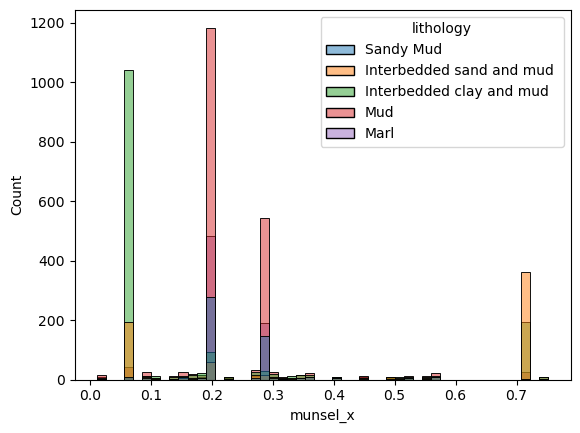

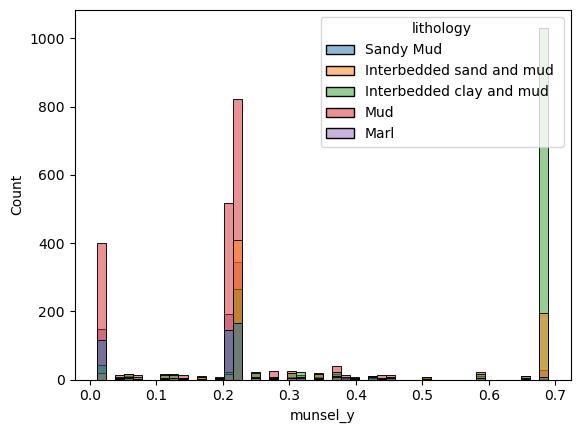

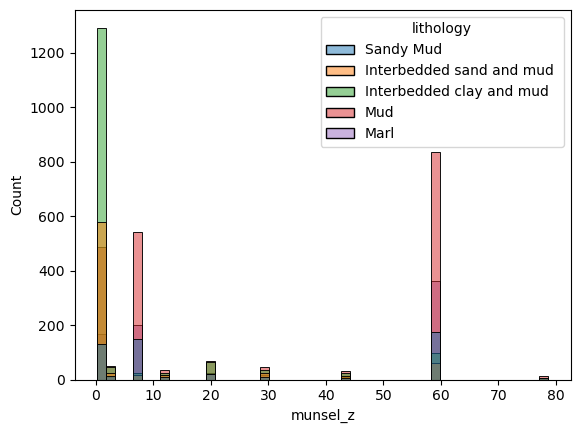

In [29]:
columns = ["munsel_x", "munsel_y", "munsel_z"]
for col in columns:
    sns.histplot(eda_train_set, x=col, hue="lithology", bins=50)
    plt.show()

<Axes: >

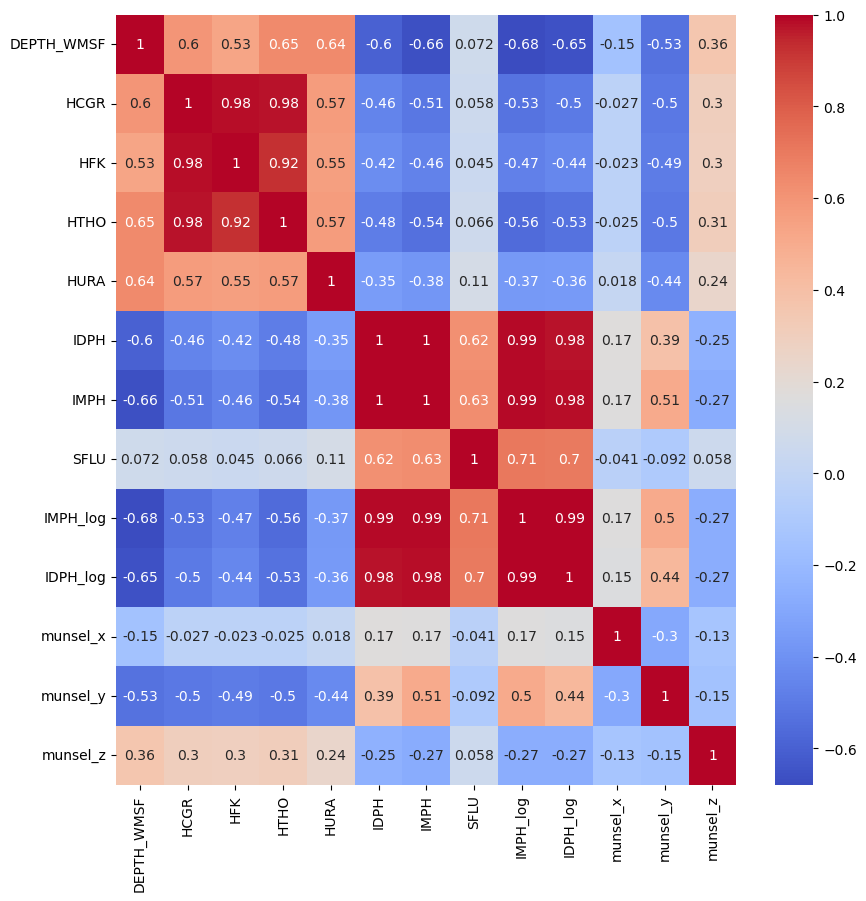

In [30]:
# eda_train_set = eda_train_set.drop(columns=["munsel_color", "lithology"])
correlation_matrix = eda_train_set.drop(columns = ["lithology", "munsel_color"]).corr()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", ax=ax)

In [31]:
from sklearn.preprocessing import LabelEncoder

X_train = training_data.drop(columns=["lithology"])
y_train = training_data["lithology"]
X_test = test_data.drop(columns=["lithology"])
y_test = test_data["lithology"]

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train) 

In [32]:
feature_encoding_pipe = ColumnTransformer(
    transformers=[
        ("drop_features", "drop", ["DEPTH_WMSF", "HCGR", "HFK", "IDPH"]),
        ("values_filter", ValuesFilter(min_threshold=0, max_threshold=1000), ["HTHO", "HURA", "IMPH", "SFLU"]),
        ("munsel_encoder", MunselEncoder(), ["munsel_color"])
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

log_transform_pipe = ColumnTransformer(
    transformers=[
        ("log_transform", LogTransformer(), ["IMPH"])
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

# Preprocessing Pipeline
preprocessing_pipeline = Pipeline(
    steps=[
        ("feature_encoding", feature_encoding_pipe),
        ("log_transform", log_transform_pipe),
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]
)

In [33]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [34]:
dummy_pipe = Pipeline(
    steps=[
        ("preprocessing", preprocessing_pipeline),
        ("classifier", DummyClassifier(strategy="prior"))
    ]
)

cross_val_score(dummy_pipe, X_train, y_train, cv=5, scoring="f1_macro").mean()

0.11374172185430464

In [35]:
lr_pipe = Pipeline(
    steps=[
        ("preprocessing", preprocessing_pipeline),
        ("classifier", LogisticRegression(max_iter=1000))
    ]
)

cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring="f1_macro").mean()

0.8604195802950786

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

pipeline = Pipeline(steps=[ ("preprocessing", preprocessing_pipeline), ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))])

param_grid = {
    'xgb__max_depth': [3, 4, 5, 10],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__n_estimators': [50, 100]
}

random_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy")
random_search.fit(X_train, y_train_encoded)    
print(random_search.best_score_)

y_pred = random_search.predict(X_test)
y_test_encoded = le.fit_transform(y_test) 
print(f1_score(y_test_encoded, y_pred, average="macro"))

new_samples = pd.read_csv("./new_data.csv")
y_pred_new_samples = random_search.predict(new_samples)
y_pred_labels = le.inverse_transform(y_pred_new_samples)
output_df = pd.DataFrame(y_pred_labels, columns=["Lithology"])
print(output_df)

C:\Users\emmanuel.osademe\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:50:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\emmanuel.osademe\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:50:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\emmanuel.osademe\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:50:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\emmanuel.osademe\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:50:42] WARNING: C:\actions-runner\_work\xgbo

In [ ]:
param_grid = {
    "classifier__C": [0.1, 1, 10, 100, 1000],
    "classifier__penalty": ["l1", "l2"],
    "classifier__class_weight": ["balanced", None],
    "preprocessing__imputer__strategy": ["mean", "median"],
    "preprocessing__scaler": [StandardScaler(), MinMaxScaler()],
    "classifier__solver": ["liblinear"]
}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(lr_pipe, param_distributions=param_grid, n_iter=50, cv=5, scoring="f1_macro")
random_search.fit(X_train, y_train)

In [ ]:
random_search.best_score_

In [ ]:
from sklearn.metrics import f1_score

y_pred = random_search.predict(X_test)
f1_score(y_test, y_pred, average="macro")

In [ ]:
f1_score(y_test, y_pred, average="macro")

In [ ]:
new_samples = pd.read_csv("./new_data.csv")
y_pred_new_samples = random_search.predict(new_samples)
print(pd.DataFrame(y_pred_new_samples, columns=["Lithology"]))